In [1]:
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

from vectran.data.graphics_primitives import PrimitiveType

from vecopt.contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from vecopt.contrib.handcrafted_data import make_syn_dataset

In [2]:
dataset = make_syn_dataset()

In [15]:
def conv_bn_relu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


def upconv(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        conv_bn_relu(in_channels, out_channels, kernel, padding),
    )

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.renderer = Renderer((64, 64), dtype=torch.float32)
        self.conv1 = conv_bn_relu(1, 4, 5, 2)
        self.conv2 = conv_bn_relu(4, 8, 5, 2)
        self.conv3 = conv_bn_relu(8, 8, 5, 2)
        self.conv4 = conv_bn_relu(8, 8, 3, 1)
        self.conv5 = conv_bn_relu(8, 16, 3, 1)
        self.conv6 = conv_bn_relu(16, 32, 3, 1)
        
        self.fc1 = nn.Linear(32 * 8 * 8, 2 * 10 * 6)
        self.fc2 = nn.Linear(2 * 10 * 6, 10 * 6)

        self.upconv1 = upconv(32, 16, 3, 1)
        self.upconv2 = upconv(32, 8, 3, 1)
        self.upconv3 = upconv(16, 4, 3, 1)
        
        self.last_conv = conv_bn_relu(4, 1, 3, 1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        down1 = self.maxpool(self.conv4(x))
        down2 = self.maxpool(self.conv5(down1))
        down3 = self.maxpool(self.conv6(down2))
        
#         print(down3.shape)
        
        y = torch.relu(self.fc2(torch.relu(self.fc1(down3.view(x.shape[0], -1))))).view(x.shape[0], 10, -1)
#         y[:, :, -2] = torch.clamp(y[:, :, -2], 0., 6.)
#         y = torch.cat([y, torch.ones(x.shape[0], 10, 1)], dim=2)
        render = self.renderer.render(y)
        
        x = self.upconv1(down3)
        x = self.upconv2(torch.cat((x, down2), dim=1))
        x = self.upconv3(torch.cat((x, down1), dim=1))
        x = self.last_conv(x)
        
        return y, x, render.unsqueeze(1)
    
    def to(self, device, *args, **kwargs):
        super().to(device, *args, **kwargs)
        self.renderer = Renderer((self.renderer.h, self.renderer.w), 
                                 self.renderer.integer_pixel_centers,
                                 self.renderer.linecaps,
                                 self.renderer.division_epsilon,
                                 self.renderer.dtype,
                                 device=device)

In [16]:
torch.cat([torch.rand((4, 10, 9)), torch.ones((4, 10, 1))], dim=2).shape

torch.Size([4, 10, 10])

In [17]:
model = SimpleNet()

In [18]:
loader = DataLoader(dataset, 4)

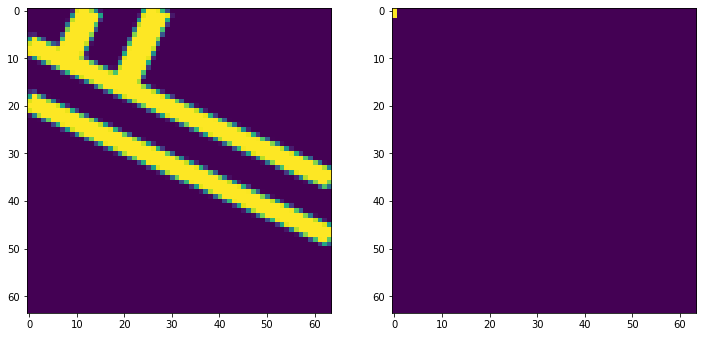

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4348.523309817285+6791.258027550357j), end=(121.70890282682112-92.29593681564828j)) to Line(start=(49.48283595407549+4.06874410331516j), end=(-82.6711335341696+32.15893746878154j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4355.170768218985+6786.941117588829j), end=(115.0614444251197-96.61284677717775j)) to Line(start=(49.48283595407549+4.06874410331516j), end=(-82.6711335341696+32.15893746878154j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7611.834358104802+3402.211845177094j), end=(-97.79712684675096-30.337245081183696j)) to Line(start=(16.515407028006738+20.557974090162176j), end=(74.023054080573-108.6063159706

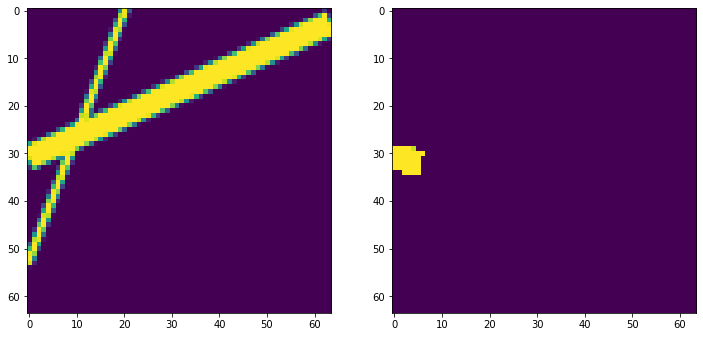

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7859.289232458449-534.4522493133311j), end=(150.63495833499996+25.65621325805725j)) to Line(start=(35.12138989979175+20.224352196746988j), end=(-5.0854952523711106+136.99362541312092j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6645.31514226947-3518.371381243516j), end=(74.83449977850785+54.79556560990271j)) to Line(start=(-17.838140490654816-31.704815717840923j), end=(81.02420973632977+60.485817319847264j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5989.264531709012-6629.050044631893j), end=(111.00884786545743+145.98991460288923j)) to Line(start=(23.881259703859087+49.22492480373429j), end=(-62.43772544643913+12

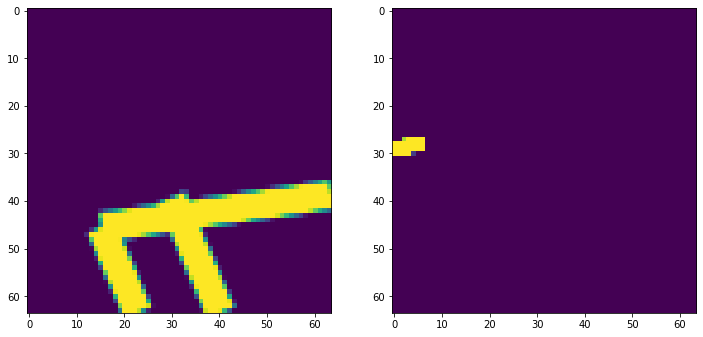

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-268.2276190053681+8786.206855886005j), end=(42.16937889221292-102.40019416566915j)) to Line(start=(44.655212109272+29.643559589368966j), end=(144.24195129011486+136.437262620294j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(11222.392495801578-1319.9837599366008j), end=(-159.8661020327412+77.58186408179732j)) to Line(start=(88.28380920763784+1.4474540617759253j), end=(-58.378555132282784+60.702895598094784j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2195.638002908785+7496.348875334575j), end=(17.385647802859147-100.119850192289j)) to Line(start=(40.23342098858564+15.785636592707306j), end=(7.79070043703485+145.90628

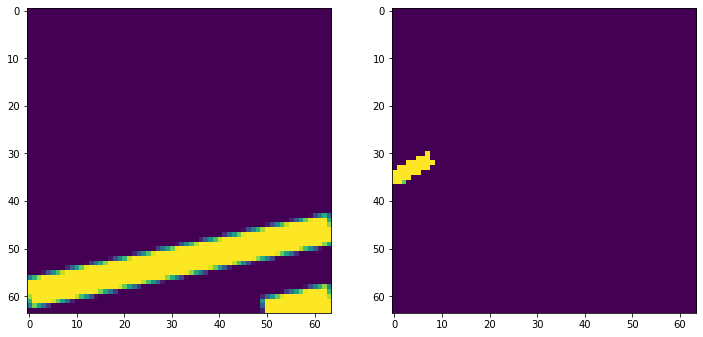

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7764.562780378441+2679.53380823247j), end=(-80.28060635379686-21.662391752252407j)) to Line(start=(30.01689201849486+26.532267165062994j), end=(87.80146988308603+145.00820914487224j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7761.823332897532+2687.489741405341j), end=(-83.02005383470353-13.706458579381565j)) to Line(start=(30.01689201849486+26.532267165062994j), end=(87.80146988308603+145.00820914487224j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8886.741004541893-1849.9069252486443j), end=(-112.71911727763676+62.9873751317931j)) to Line(start=(12.607929442903325+23.16927280875236j), end=(94.96871445847715-103.655

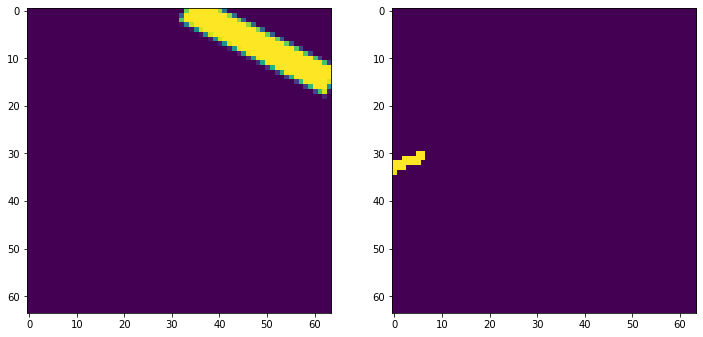

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(595.9521036182232+7660.338744649451j), end=(53.43247333091107-98.05342580421518j)) to Line(start=(-2060.108169581473+10762.04800117867j), end=(43.57589665649931-60.468310118626135j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2512.4499679845267-6972.576902390958j), end=(48.13054303678742+62.56023233568233j)) to Line(start=(-41.747934940111406-11.341939468891496j), end=(47.70360433732236+63.716814147043124j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10035.660088917142-1930.732164631838j), end=(196.7973626525559+58.256078042834176j)) to Line(start=(42.70602871045087+23.272183564860352j), end=(-53.553446350350

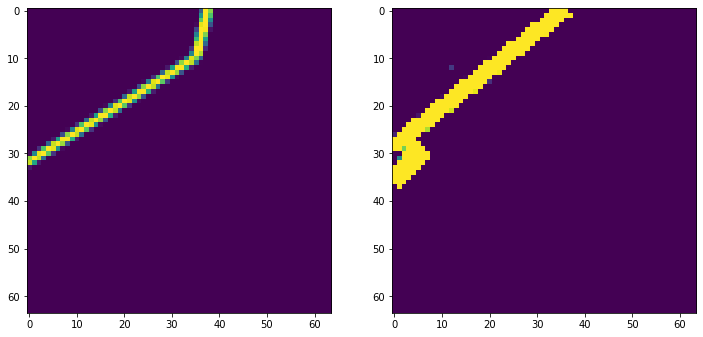

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(8335.151286528147+610.7908252624765j), end=(-32.26908961694241+25.68379416748186j)) to Line(start=(10766.68823499237+3763.2016805743997j), end=(-57.90445241164909+35.995515687814105j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-32.009458823702296+36.166119521008014j), end=(8411.983828439605+2943.666174758333j)) to Line(start=(-12.49759375233571+7.015882436429379j), end=(91.88919879621099+77.42566305628758j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8341.197069079073-2834.2343428313297j), end=(102.79621818423456+73.26571240599566j)) to Line(start=(-6.650127198774304-1.653343240564487j), end=(97.7366653497724

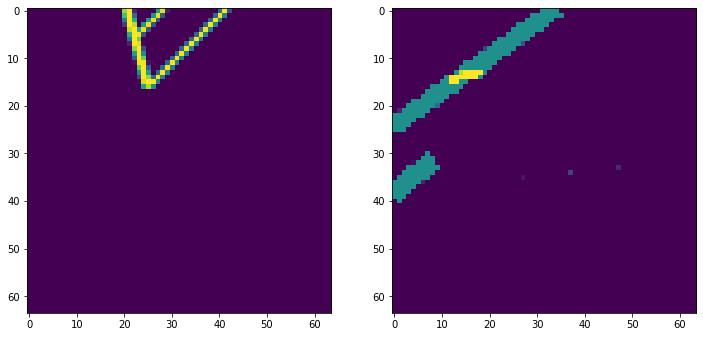

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4974.77795118414-9271.64840130555j), end=(-46.90367844768769+172.7611400865335j)) to Line(start=(-17.925251668014752-64.08067213182319j), end=(-12.321596330007711+96.38702143750798j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3119.7779056843037-10101.991471356421j), end=(-26.74665836189715+189.82663807876511j)) to Line(start=(4.552509383827648-51.85334405655449j), end=(-0.8691514121440376+103.40270771094457j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3129.0972275477243-10099.142268732387j), end=(-17.427336498475462+192.67584070280162j)) to Line(start=(4.552509383827648-51.85334405655449j), end=(-0.8691514121440376+

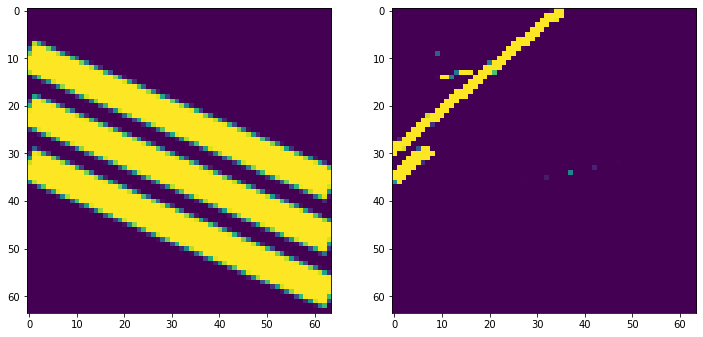

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4448.9730819792785+5809.802058627914j), end=(98.20673190324268-10.322694228296342j)) to Line(start=(-14.631234980176544+73.77565743440753j), end=(114.4145038298677-23.467281694408626j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10071.667126715785-2283.168718598079j), end=(-139.94828929464077+74.36846096616512j)) to Line(start=(11.92453499441079+49.82837948286675j), end=(161.32551284975003+143.18447168995237j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8462.712166640926-4468.6553687115875j), end=(146.8039079342273+109.1055301811317j)) to Line(start=(14.601240304519584+45.16973386754991j), end=(-136.80719075463503+9

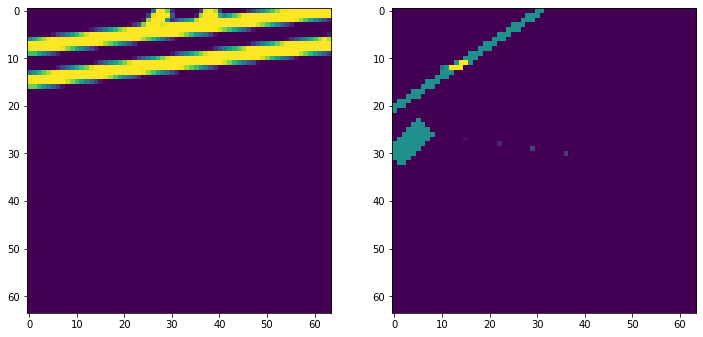

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6551.405888809157-3291.861098546132j), end=(-80.66707527864304+87.34885956055507j)) to Line(start=(51.99193253463905-29.202377138402444j), end=(-37.572096567111956+51.44143688842357j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(6558.375358948197-3278.1827432334467j), end=(-73.69760513960321+101.02721487323905j)) to Line(start=(5694.5257659449535-5109.762660828441j), end=(-37.572096567111956+51.44143688842357j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2350.3629945324637-6857.680396985967j), end=(55.907266322443036+130.63586921668977j)) to Line(start=(26.532069168188784+25.453943220780893j), end=(100.76257072

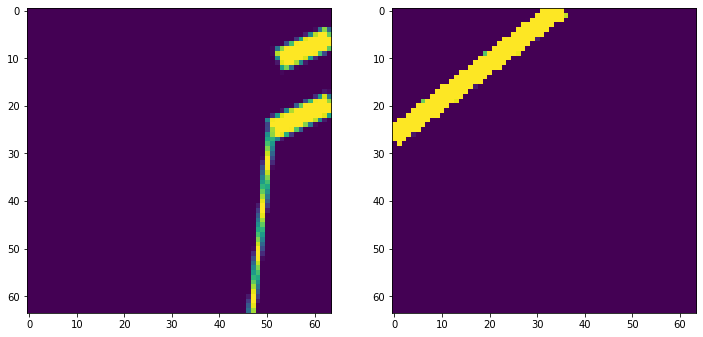

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8711.929147116029+4079.997028284513j), end=(148.34995006917865-51.618968123604276j)) to Line(start=(14.082359999782712+1.468816988306548j), end=(-152.73735304059616-59.24859304722078j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2401.1230915941605-8094.808940901624j), end=(25.992529980489984+188.25568567791254j)) to Line(start=(23.74641396161909+144.1493950004636j), end=(23.09206620043997+181.6369531315899j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8053.853569665202+2322.248532740412j), end=(-102.27261087110656-16.483015194982656j)) to Line(start=(19.388183875278507+9.634656287839185j), end=(121.97736125130581-47.

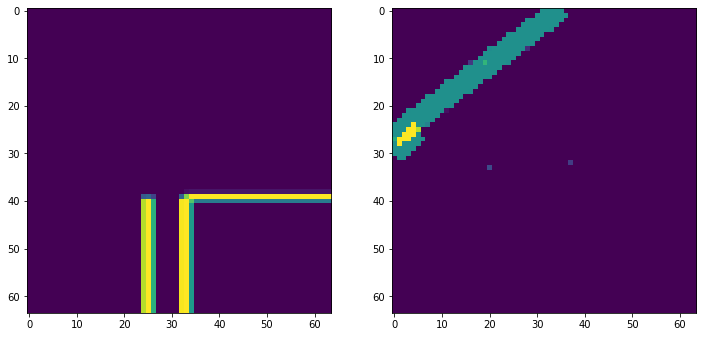

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7297.075177695291-8120.609037817574j), end=(149.0157600359482+149.1127441829817j)) to Line(start=(32.04021787558437+31.926541483112615j), end=(-111.65116853637824+24.395995019160267j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-8647.272554733578+660.4373440746234j), end=(106.6966231822169+48.300187611216074j)) to Line(start=(-11174.976812778925-2145.285366977459j), end=(127.59499626897443+51.71203531652577j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4891.912621394986+10105.446025003763j), end=(91.10956158659339-111.2634994382219j)) to Line(start=(24.564319754944187+44.47669906380469j), end=(82.645936186844

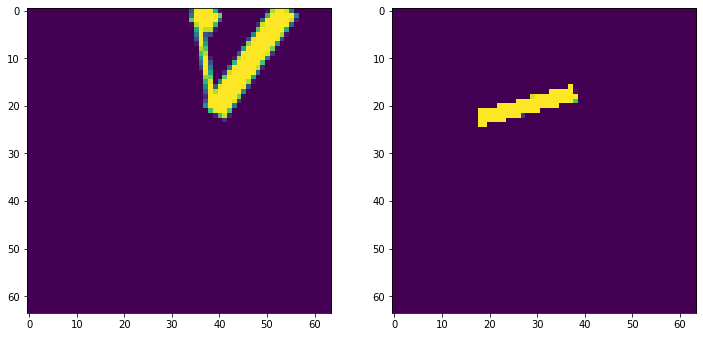

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7694.388392353006-97.70219478923994j), end=(83.99153845864899+38.06993193941887j)) to Line(start=(-7985.165690767441+2059.7499018085746j), end=(89.63184890015077+46.47675788022379j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-32.6508107295391+21.853037156562674j), end=(8388.897660959452+3771.3679914687636j)) to Line(start=(-6283.902991179179-5093.243047945564j), end=(92.43023910450037+70.20979226890162j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-8322.61258754839-3669.0757459945107j), end=(98.93588414060139+80.43920831769083j)) to Line(start=(-6276.095339827938-5102.884694398428j), end=(100.237890455

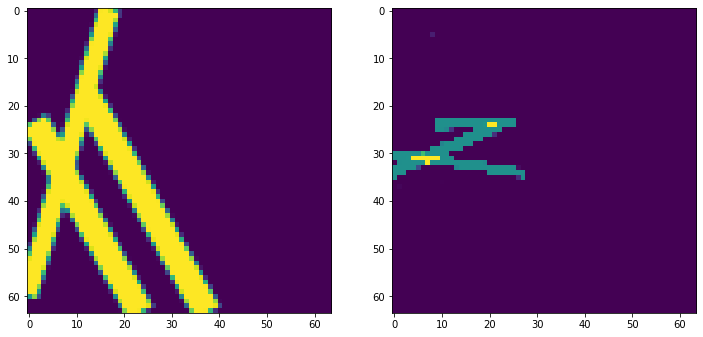

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5537.223302105263+5427.426416394514j), end=(121.21720022724529-36.866059621695314j)) to Line(start=(41.96974216761568+48.67349776461639j), end=(39.31141769176975+200.9688049879429j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-1782.6759430482566-9182.141447599424j), end=(21.63275285731418+100.2220999717381j)) to Line(start=(708.8550395610583-9695.101010303235j), end=(23.735352461403604+102.5669808118619j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7349.526979678276+544.6871729517071j), end=(168.26236190706126+18.992131431739626j)) to Line(start=(55.204846892696224+40.00771376507717j), end=(-75.20276646981966

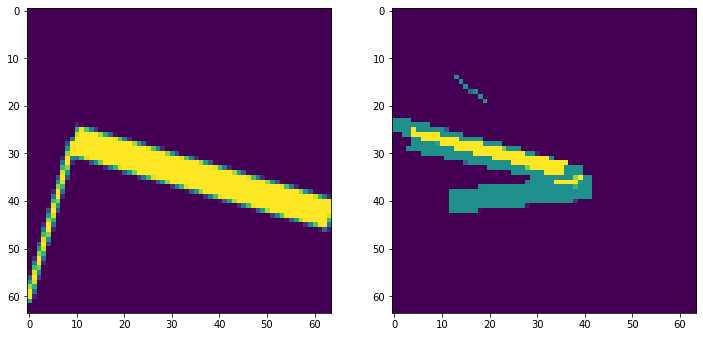

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7501.051794832059-3970.763426563418j), end=(132.40863297517018+88.01947911635153j)) to Line(start=(11.890194227214382+29.996367302802433j), end=(-149.77918055282052-7.32794881306495j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(10589.755795441826-3018.1605576059605j), end=(-116.54452915590247+51.82165902047227j)) to Line(start=(10861.110641073978-162.18688942768648j), end=(-31.840083156256185+27.950272723626128j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7187.17876179681-1485.7129678488175j), end=(-79.71077508414326+58.91208614645734j)) to Line(start=(19.9236104725762+37.73414372841573j), end=(-14.1187472024

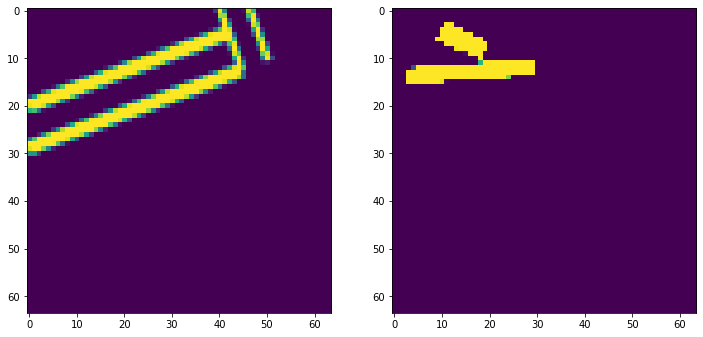

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4205.952538654221+6802.065881106498j), end=(50.431475651243574-9.57242584489677j)) to Line(start=(15.469044785650416+120.07517525189343j), end=(57.17399889028609-16.335583085015514j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8384.661123573185+2923.1214273622168j), end=(-116.40536057155299-4.030505540107001j)) to Line(start=(10.625077963339503+35.03557304737667j), end=(128.15672305510842-67.13312730462168j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6233.602763028457-6844.156563868235j), end=(-64.8486286306036+150.98237575166246j)) to Line(start=(27.754482252482582+41.98782908587766j), end=(19.3815553050122-117.777

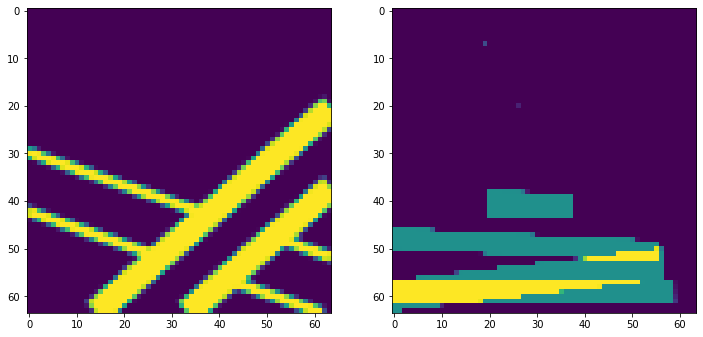

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6533.28564929749+6442.280857807934j), end=(170.92351420152073-31.898675341788035j)) to Line(start=(43.52051232938707+43.045407522769075j), end=(149.18010630318-15.522661789728886j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-28.034158614131627+44.0461752582634j), end=(7335.866884562769+2724.286963056492j)) to Line(start=(114.21849533486929+46.6092737689879j), end=(-37.03268683116761+33.37650998456529j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4776.036051849968+5887.552882238587j), end=(-49.4242659718287-71.39434321226904j)) to Line(start=(17.55350842649481+20.82922499787201j), end=(0.03228645649704376+187.5325165

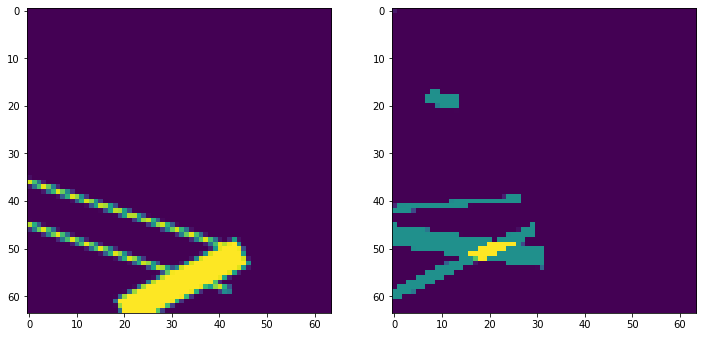

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10322.47828602701-4575.484508340428j), end=(-152.82443303414257+88.42074947610537j)) to Line(start=(3.6124407580097477+12.768157394336896j), end=(48.69132307795882-104.66634598598114j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4362.264021640589+9364.01984383409j), end=(-58.40786592713634-116.14161235695653j)) to Line(start=(5.929276017564594+21.82983378926052j), end=(137.37390761176093-39.46380454647567j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(4787.829398281523-6279.260989081904j), end=(-6.138637856536263+82.54946828886787j)) to Line(start=(37.53008052749741-57.345276552136454j), end=(-4083.937572922515+10143.6

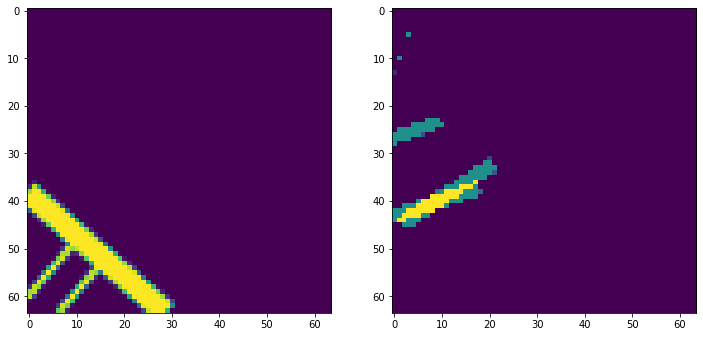

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7380.52233529476+3945.7114482605557j), end=(-90.05944990359652-26.467346927858685j)) to Line(start=(22.67126662329389+22.523943680721107j), end=(185.11886554215474-27.141271438065264j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7384.974980258898+3937.337241035712j), end=(-85.60680493945908-34.84155415270303j)) to Line(start=(22.67126662329389+22.523943680721107j), end=(185.11886554215474-27.141271438065264j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3150.4155876656628-8760.223052051078j), end=(79.88916377247114+114.9663104821476j)) to Line(start=(-17.605256143318023-19.770717989673074j), end=(84.73090492994751+126

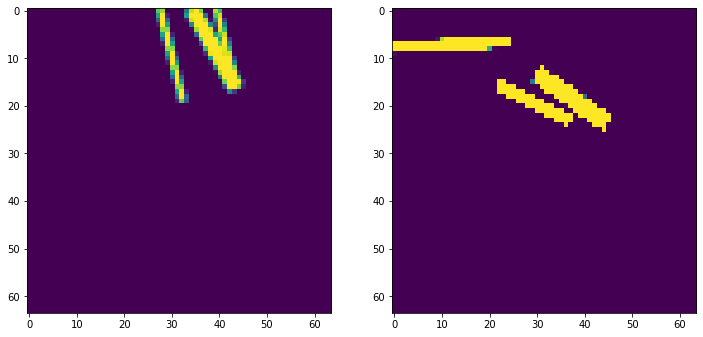

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(197.8849653489352+10555.785565110193j), end=(10.890145183289784-157.1405073303979j)) to Line(start=(51.49986611209419+72.96074170063184j), end=(13.517039569199198-59.50111620296414j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7971.8229290652935+7721.8225952734665j), end=(-104.39815837077153-77.29345172372396j)) to Line(start=(21.607243709780175+33.9374460247299j), end=(138.15027834369045+31.90317978826348j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9892.11936875206+3593.1632249791055j), end=(-110.75915434702685-47.58681440963376j)) to Line(start=(39.72325984928344+5.229904717973999j), end=(108.17249811713205-92.525

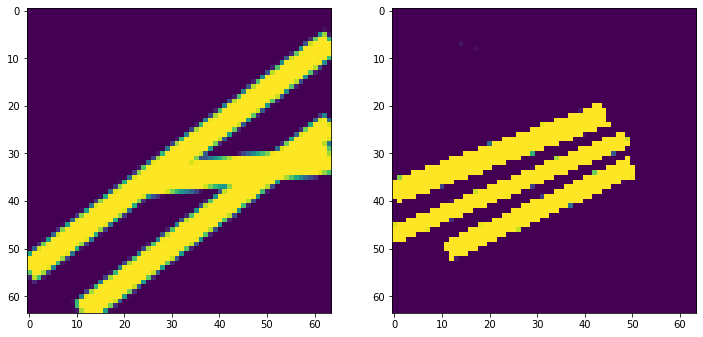

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2514.568208142879+8375.710268764657j), end=(70.45413540713804-79.51683247592926j)) to Line(start=(26.218951433085266+45.36618376627294j), end=(-131.9075931901189+129.44355893847026j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3527.800060098573+9185.782314670323j), end=(43.68058287562748-118.24285310735286j)) to Line(start=(-790.0663527203254+7671.016267385151j), end=(18.6690017572058-23.586642129011096j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10253.035149839921-699.6326484781566j), end=(190.18150194599002+30.628198416613465j)) to Line(start=(38.47221659304526+20.019651749653736j), end=(29.9516647419883

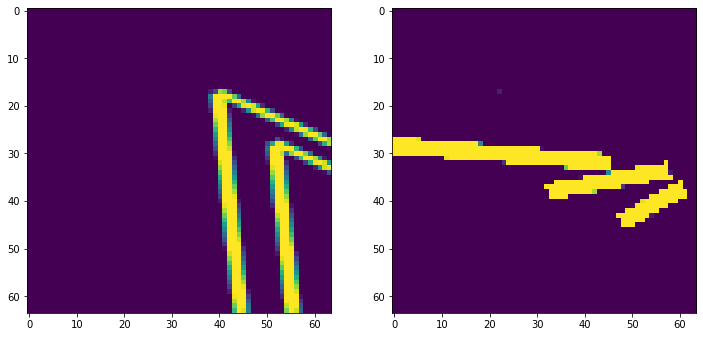

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4319.157872532493-8735.667617093624j), end=(-14.06389654577962+148.7536224625876j)) to Line(start=(48.17407759032274+21.146864999224086j), end=(-98.63825409229845-50.45829356573059j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7952.280439088307-7686.643888668903j), end=(94.76678695057646+84.29928785924929j)) to Line(start=(-5253.88006770222-8832.13433507275j), end=(98.50153811550834+75.72455320000934j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-2469.6095693164275-6838.6905864061855j), end=(52.085097360185976+89.60856904696192j)) to Line(start=(-29.48859419517313-16.974351109614386j), end=(5730.721347498529+8

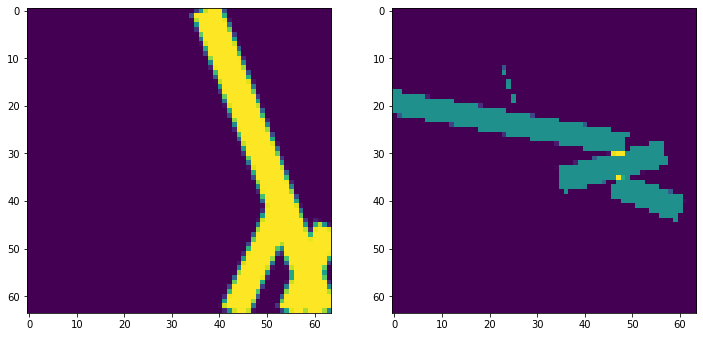

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6917.968531040202-6434.487324803371j), end=(129.14308380069951+137.05056973171148j)) to Line(start=(31.14020911867159+33.9474609214556j), end=(26.057657425857347-111.59777667748541j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9048.494761942577+1295.0191384232087j), end=(-112.07375567746979+7.585192608438003j)) to Line(start=(20.137708842117814+23.06505639748186j), end=(83.11144845172936-125.2917770465906j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5587.051013619484-7978.461273174409j), end=(123.37614524341194+176.87389140166397j)) to Line(start=(41.29443725930036+50.7064093942729j), end=(69.5221911126904-109.3811

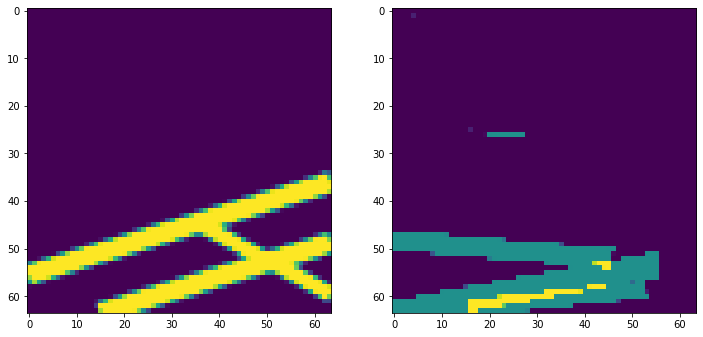

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(75.26076206850755-41.07810249226657j), end=(-1665.9380384991982+10952.418461942458j)) to Line(start=(28.96802381026062-35.550009874385836j), end=(45.03925773671226+117.35756693094174j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1789.253331377343-10862.8012831077j), end=(48.05453080963714+130.695281327026j)) to Line(start=(28.96802381026062-35.550009874385836j), end=(45.03925773671226+117.35756693094174j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1800.8753610608542-9468.795184784316j), end=(75.33443005553616+183.46743090633228j)) to Line(start=(57.87119874257466+40.64547121353333j), end=(142.24714859138385-84.44701

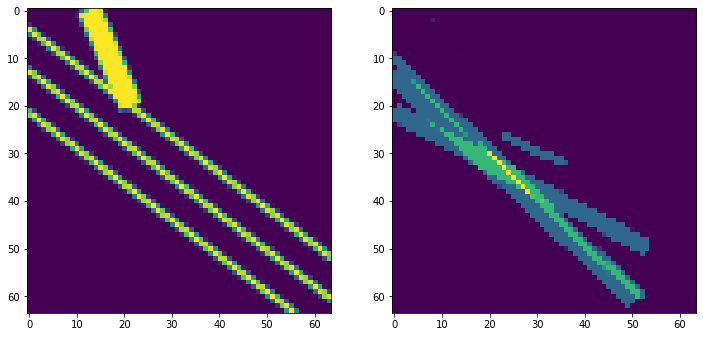

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7655.348366594792+5628.523659993382j), end=(145.50210566099446-39.12596271115194j)) to Line(start=(30.544830975474582+50.528827407925526j), end=(9.448663446467712+183.72478709803212j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3706.1938798728725-7656.428057701435j), end=(105.01746591702442+157.71320564218928j)) to Line(start=(41.677837887984694+46.622612494127j), end=(-91.17442703853762+0.877909191851316j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4621.778049414749+7158.155095556981j), end=(95.01979901653186-105.07665263836262j)) to Line(start=(18.513641896629448-4.790746012514711j), end=(-118.76496866755784+24.

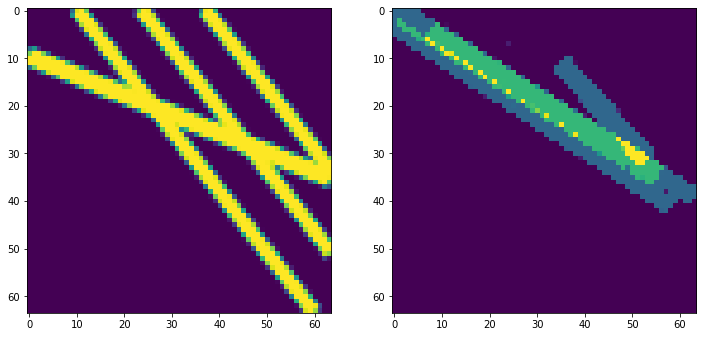

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4998.791360521075-5552.914840667134j), end=(98.76471000141916+108.49472629867196j)) to Line(start=(18.79967754837405+26.059476368156865j), end=(-101.48373370969105+19.755689899532896j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1872.4664513462574+7921.724733601743j), end=(25.315676544206504-79.16428361861827j)) to Line(start=(51.834376398877446+35.700825019271505j), end=(194.19145801288138+2.8351030931322043j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7603.447084718764-2265.834622247311j), end=(-75.59176699296486+81.88315883404697j)) to Line(start=(41.0459388103032+51.49537954374249j), end=(182.98084242515736+126.

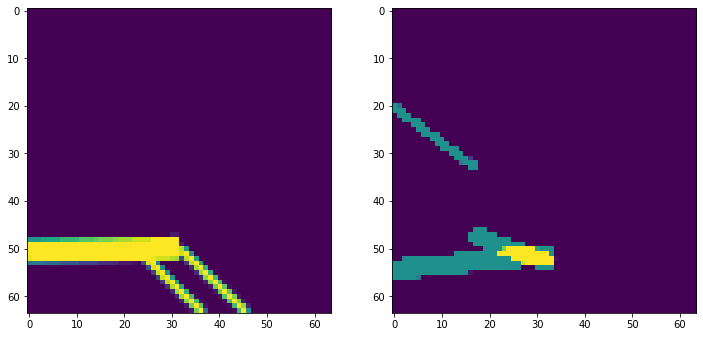

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5603.914988392955-6645.926583860688j), end=(101.9263218260652+154.0302963652776j)) to Line(start=(16.095471864608868+51.74107256829747j), end=(148.9143628107055-59.70720983794769j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9929.590568698908-2074.61475464414j), end=(-101.7585080810733+57.61431402796348j)) to Line(start=(45.33253569917234+13.582172851402081j), end=(161.78727495899557-91.27414535579335j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9927.993254225019-2082.129528412303j), end=(-103.35582255496227+50.09954025979967j)) to Line(start=(45.33253569917234+13.582172851402081j), end=(161.78727495899557-91.274145

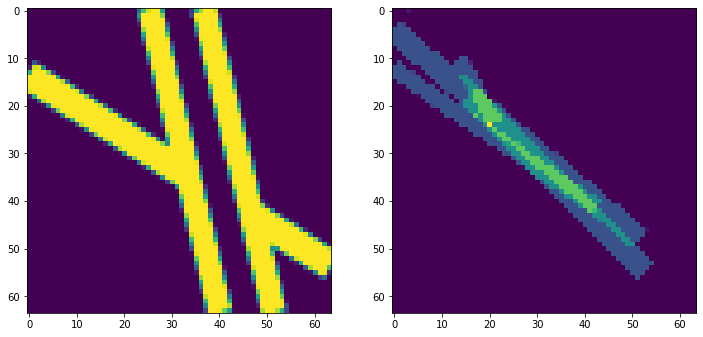

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9893.10775820486-657.2677056063882j), end=(-100.28210450435172+41.5381880014647j)) to Line(start=(49.472002948412644+25.062335557907467j), end=(144.76560598669772-84.56041478759579j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-11066.17209711035-2513.6627081418155j), end=(205.53061045047096+88.61490685786063j)) to Line(start=(33.22239206323038+40.78473327190041j), end=(-72.40027028666157-15.375832496732926j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))


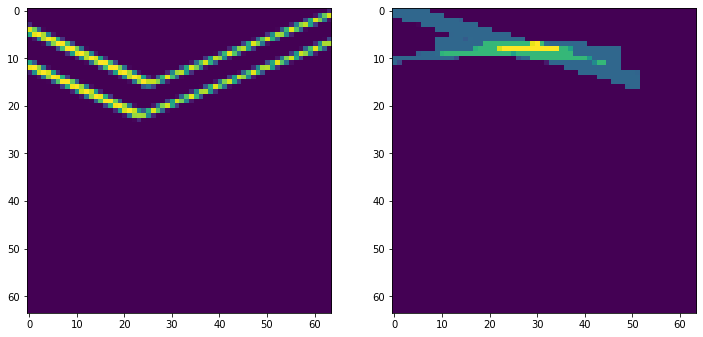

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(9589.705649720909-1483.677649321468j), end=(-127.62003991169814+55.39554148223213j)) to Line(start=(8084.002672843932-3582.797398889689j), end=(-46.718041025574095+37.2326951573171j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10567.578844159872+2312.2784833746573j), end=(221.31571304394703+19.028152074991553j)) to Line(start=(73.97500434645387+68.65085798091073j), end=(2.343358666045873+178.9539194645514j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10566.041049052295+2319.51324053997j), end=(222.85350815152333+26.26290924030362j)) to Line(start=(73.97500434645387+68.65085798091073j), end=(2.343358666045873+

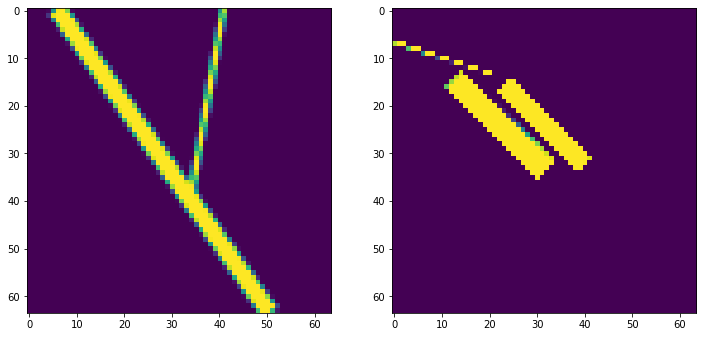

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4661.647707907997-8125.451415258819j), end=(124.50604758623842+164.41006209378298j)) to Line(start=(45.62477677993259+50.17349648205233j), end=(-115.18338419590468+7.085079612242829j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7931.060526233615+5754.649061967853j), end=(-95.88419575861744-77.26764850766862j)) to Line(start=(27.849212301647288+3.2009427016116323j), end=(165.53864341290495-18.606920783548738j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9774.252006917408-4322.20963969058j), end=(-113.13072156764377+79.93677365514901j)) to Line(start=(34.76090685173115+8.620222084395513j), end=(84.46300103625373-120.85

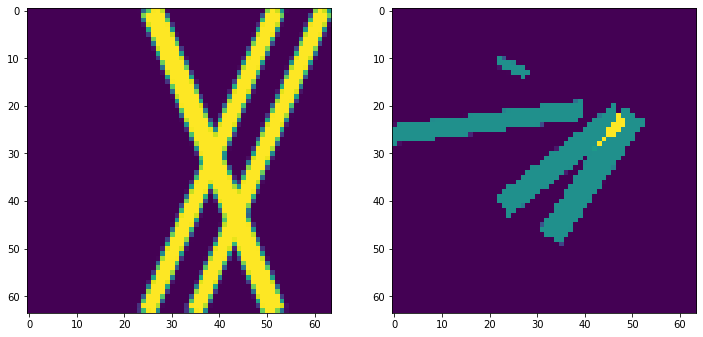

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7365.596427456593+4105.0206650388345j), end=(-68.86340382577524-15.967712103006484j)) to Line(start=(43.67285712455588+42.386100166753124j), end=(182.00566375625937-40.7326356577921j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7753.364903068203-206.5361672074408j), end=(93.61996274252148+67.4865824967707j)) to Line(start=(-9549.662159697136-2888.6940630116883j), end=(111.1796519625312+64.92168753133971j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7268.903035042139-4696.571444062691j), end=(-100.27799319568445+89.03067132199298j)) to Line(start=(12.148777691474645+27.036625398896973j), end=(136.9172210441557+

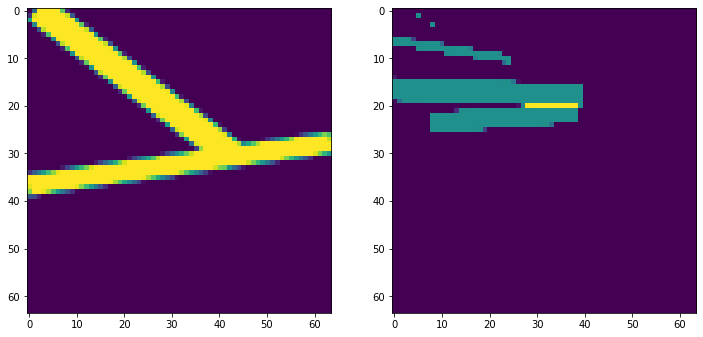

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5569.661788271166-5120.121108980135j), end=(-64.71969474876187+134.02462499064023j)) to Line(start=(16.08625125033044+63.50104044233403j), end=(153.48170569307413+149.3552490152588j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7122.474986159612+7613.028528571869j), end=(-57.01151381738096-86.02814804807923j)) to Line(start=(48.10091124558419+34.022825647718456j), end=(42.79989988493475+185.8239296268889j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10735.763764380503+1353.7136101584874j), end=(184.20086149765132+12.910548494790898j)) to Line(start=(20.05680703693402+28.977270078551342j), end=(-75.37741951254556-97.66

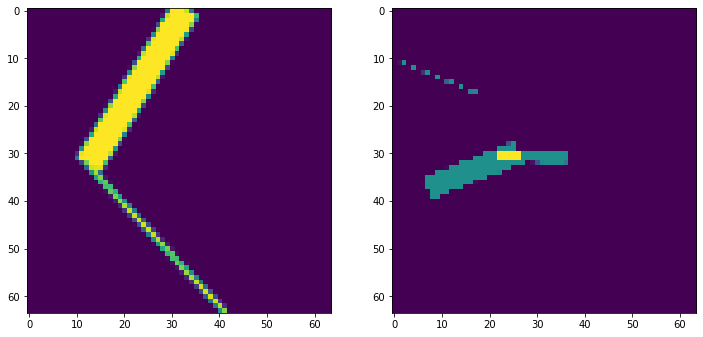

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4345.970889018016-10266.450257444523j), end=(97.1951113033802+200.99287616029733j)) to Line(start=(-30.565481015070695+2.5092453040386076j), end=(43.463146668305534+97.26156785011295j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3220.1571816986693+8305.01840433948j), end=(28.705322317013007-8.99793503236286j)) to Line(start=(117.23368421970784+99.30364571708147j), end=(32.06381039360258-17.92262878598079j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4930.715657105102-6506.0548054185365j), end=(-57.29554012572278+113.25962405124591j)) to Line(start=(21.256210823565684+14.202213815462471j), end=(197.05375250481245-10.5

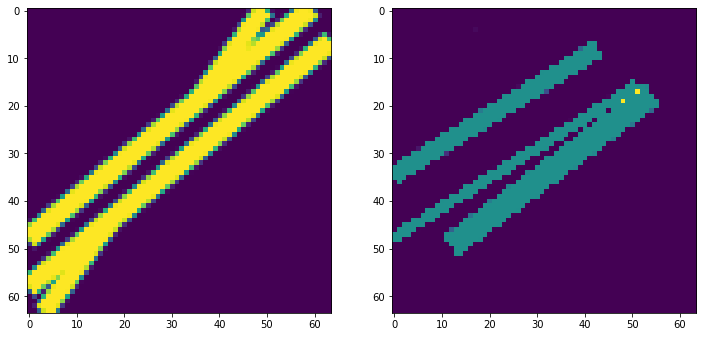

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4576.798481817261+8314.220941689073j), end=(89.57149145054268-104.13333385067781j)) to Line(start=(16.54351139046845+20.760724894869327j), end=(-156.47008645287232+23.780688478689353j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(59.77745926199265-49.12047948298882j), end=(-4846.937697343027+8449.55947002519j)) to Line(start=(17.84905261978525+112.3533877467967j), end=(62.93806903768788-55.921112388123504j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7666.064066399106-4038.9493781338574j), end=(-98.2289213029832+89.39843361042436j)) to Line(start=(13.360725684066757+21.919024960019932j), end=(54.68603637397986-113.249

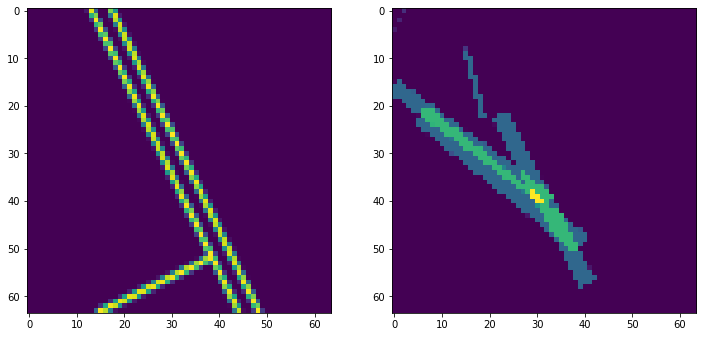

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(515.9415110025807+9219.94773558306j), end=(25.953148142469583-129.58719154680534j)) to Line(start=(21.904847328282678+5.960630520562539j), end=(-88.93913966403474+129.06534966779455j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-5531.182880749535+5419.377609470174j), end=(91.964366203378-10.832565999559819j)) to Line(start=(-8968.133140530885+5011.205843395808j), end=(109.17705002787386-20.429358075378516j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8599.387475984468+3164.477017740151j), end=(151.56585804140335-20.60951729784813j)) to Line(start=(27.390534290114037+35.013501577600636j), end=(-29.6991524874332

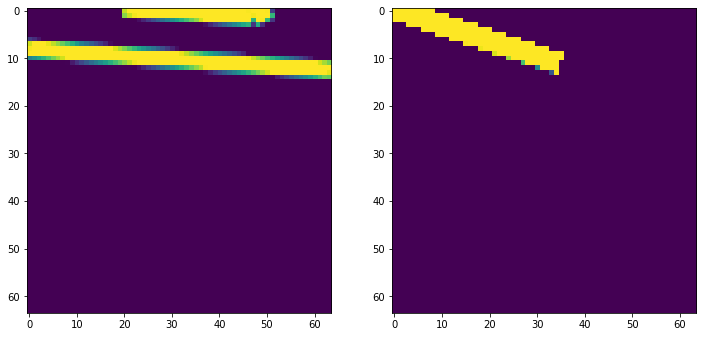

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8663.08651564925-2435.6144873167486j), end=(-90.6603689880506+74.48203995353771j)) to Line(start=(37.566409763312265+27.00464408485344j), end=(138.3763873230144-77.38714361076521j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7669.510402424265-7939.377085210841j), end=(102.49191649237866+108.76691487793806j)) to Line(start=(32.6100345307342-17.52167992485387j), end=(88.51030086317357+83.32507007125793j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4104.788704325842-8276.842190924737j), end=(-9.632257843745442+158.9709136859515j)) to Line(start=(44.77353378935102+30.563991762575903j), end=(0.9750614382991216-96.63600806

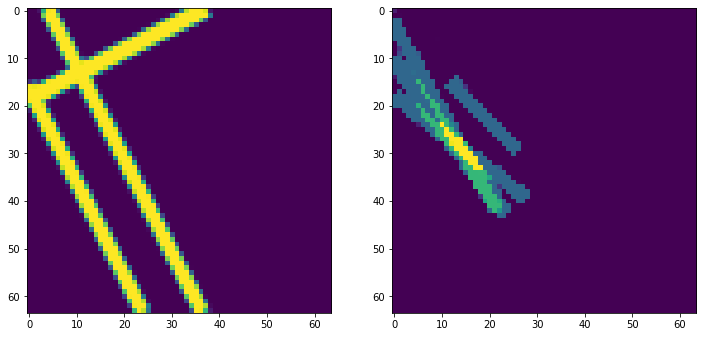

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10232.250977018808+2766.7703621028377j), end=(212.98528535084915-32.0222591513902j)) to Line(start=(58.943400653516136+2.543943653514207j), end=(-35.37210268794172-91.77155968794362j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2651.2162011631117-10038.445050292545j), end=(67.16847019496514+106.70465773221332j)) to Line(start=(-20.878086655706454-26.003954018181506j), end=(58.8152387524939+112.02893461294121j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3628.456421060278-6853.490900859022j), end=(51.0398092284546+66.63503858705775j)) to Line(start=(-43.45909783740665-25.455482008366353j), end=(55.64146322261322+80.

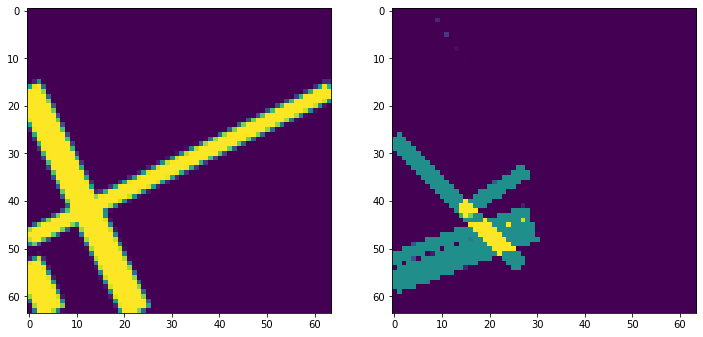

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8064.281779076025+18.909223155340605j), end=(161.96672936868114+18.909223155340605j)) to Line(start=(36.11567336610556+28.926334673834493j), end=(-132.1116984030333+74.00272308418555j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3624.4253610132673-7810.844508115072j), end=(92.38289091681324+159.8765103560244j)) to Line(start=(48.10948869368239+32.900377642498064j), end=(25.243037197250146-96.7817130083883j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3617.599165714275-7814.027615259055j), end=(99.20908621580654+156.6934032120422j)) to Line(start=(48.10948869368239+32.900377642498064j), end=(25.243037197250146-96.78

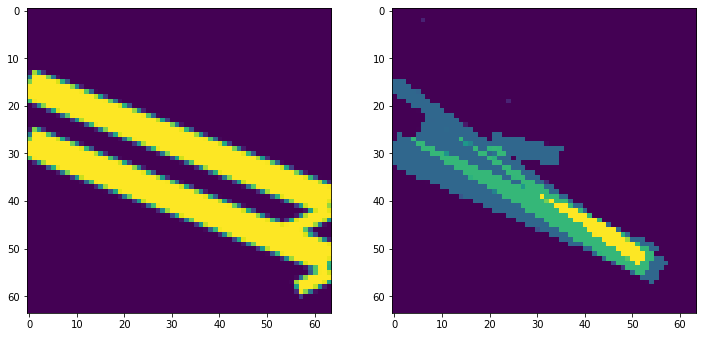

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7061.729446849776-5882.215120389693j), end=(-98.35752352532774+125.81121564930683j)) to Line(start=(1.7450734544390194+30.905733452564277j), end=(15.570442665405746-127.11895973377224j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7433.400723274569+4495.083594194788j), end=(-79.44937804315842-19.092168344252514j)) to Line(start=(14.15601503832573+57.3715683490273j), end=(48.05789482933238+193.344581425821j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7430.692041848512+4499.5915971164j), end=(-82.15805946921674-14.584165422639728j)) to Line(start=(14.15601503832573+57.3715683490273j), end=(48.05789482933238+193.34458142

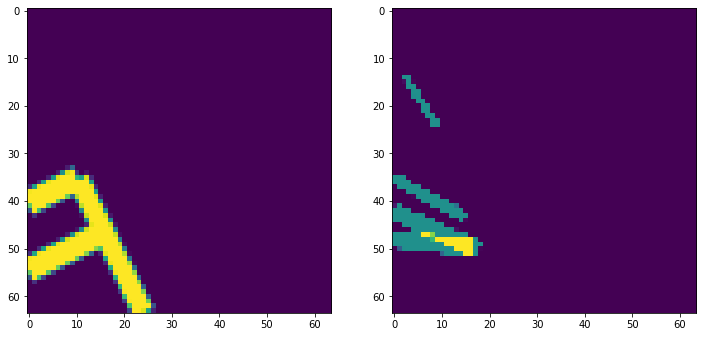

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1.2450322895090817+120.18400731993835j), end=(3224.8537442366714-8284.090637030464j)) to Line(start=(-28.469469290153857+99.21358763201297j), end=(45.17174827901438-2.1448528316743705j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3176.936015432468+8393.141860352367j), end=(49.16276109371249-11.132783998036686j)) to Line(start=(-35.15874415275737+94.35354496281431j), end=(38.48247341641086-7.004895500873033j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-1550.0632737774272+7330.034162299911j), end=(26.973132938949362-89.33880048166154j)) to Line(start=(634.2890918914568+11300.05312357506j), end=(34.35653983715844-147.

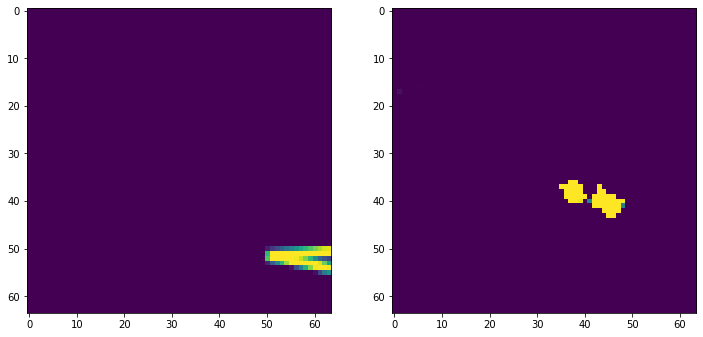

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3379.7893115674683+9896.788426829678j), end=(78.81636404710058-147.73179788150242j)) to Line(start=(13.102168237011822+1.339967512653721j), end=(-61.39247747458174+111.78282160784735j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7053.777442683251+7835.046578487311j), end=(-74.61171869401852-81.8316347110613j)) to Line(start=(37.42055678734745+29.44404971612184j), end=(175.5991320898819+36.68568199222216j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7059.950078737934+7829.488712019695j), end=(-68.43908263933557-87.38950117867651j)) to Line(start=(37.42055678734745+29.44404971612184j), end=(175.5991320898819+36.6856819

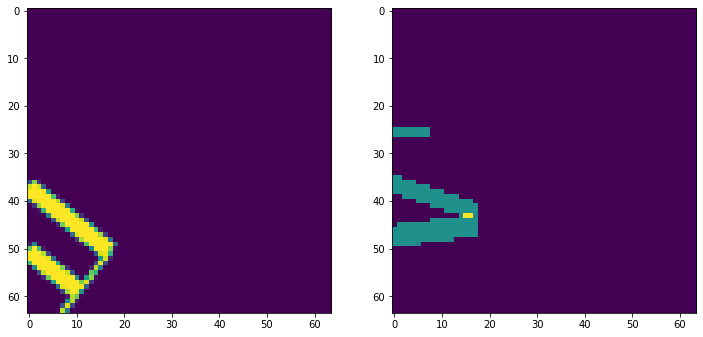

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8444.224219252364+779.2196561803794j), end=(164.39663285951642+26.062923027708642j)) to Line(start=(37.24555893287385+29.061326953354847j), end=(-100.56018378093921-86.57142093191682j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7202.280341632609-7731.23601869901j), end=(131.91961933940652+133.73053251162966j)) to Line(start=(30.150814419836923+11.288396205970995j), end=(35.240371392669076-134.4574463658785j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1220.9996344289214+11268.705136732879j), end=(19.731163449410047-160.60090353291076j)) to Line(start=(44.81584215349899+10.183802114589373j), end=(161.00746900877147+

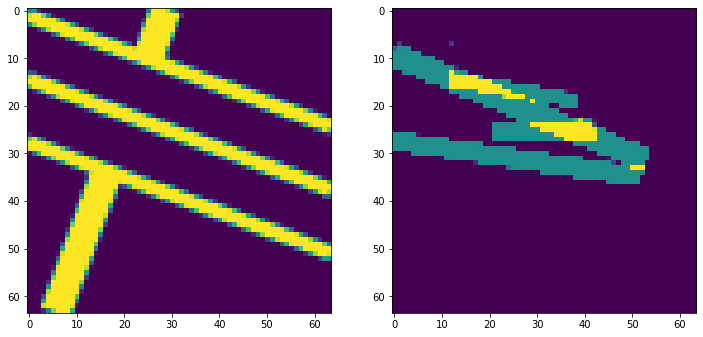

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(2602.7120227324835+10459.995281850568j), end=(-34.092036036917705-115.64816253167652j)) to Line(start=(3841.0336796077468+6904.643012976747j), end=(5.171273056645177-15.435951091800376j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3308.51478606297-7864.437224151973j), end=(100.75460463882905+167.29813566336674j)) to Line(start=(-4552.4285644749125-5819.960933205598j), end=(69.40652748898857+95.7182181299274j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10424.413077798436+3816.2482225517224j), end=(175.45090186659107-41.786753316836666j)) to Line(start=(13.89020680271203+17.016530713773857j), end=(54.36

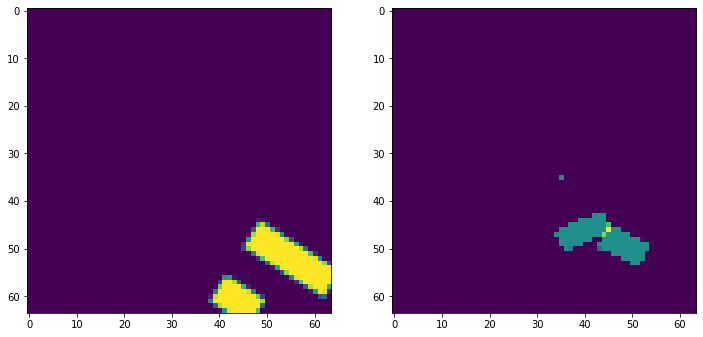

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6145.881342863928-8771.041698177993j), end=(129.1881253794602+190.6862550620931j)) to Line(start=(41.18180998442112+52.429868745070564j), end=(65.40384933695974-84.94014266904668j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6744.826353233536-2728.106780712969j), end=(151.32792525971368+58.12040520362703j)) to Line(start=(36.42289495896975+46.11461374828936j), end=(205.83173888200432+66.91540426244772j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7821.345301682385-2242.9347687827467j), end=(176.88242171349918+50.520125149197526j)) to Line(start=(57.79990251502957+25.310353019164538j), end=(-83.75926804001196+103.77

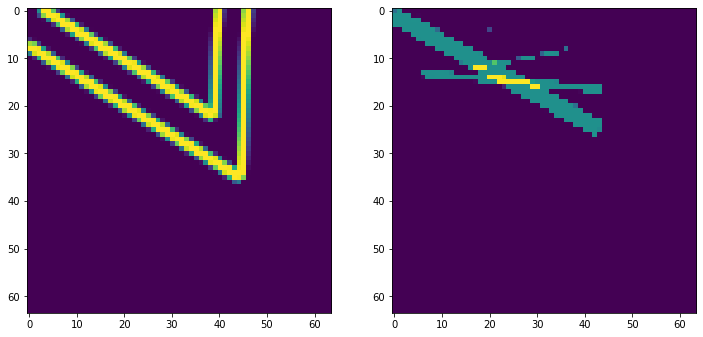

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3204.327641288644+8077.511968310091j), end=(91.04138935699709-78.81259659614085j)) to Line(start=(49.69023140694699+44.32623171976255j), end=(103.41778619839596+170.90041878512287j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5168.144301518993-5697.032072919578j), end=(-50.60934834169758+98.9810424262332j)) to Line(start=(25.819388979929226+8.686365999622558j), end=(19.57550109639942-110.45411216885856j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8029.7878275267885+3114.76358006263j), end=(156.94743613266104-27.829652012419437j)) to Line(start=(36.86428248230189+3.6766015701384305j), end=(-87.06853730651521-51.5018

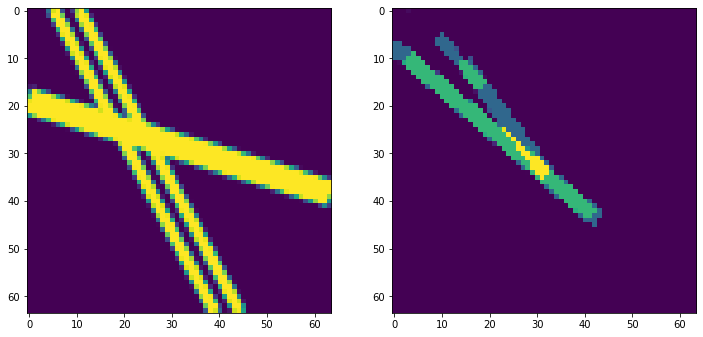

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8501.243328377355-842.2374953593982j), end=(-103.5232119302404+62.15991149931037j)) to Line(start=(5.459899181854201+50.70532494899945j), end=(23.631706630295323+223.59852380542486j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9505.399405484306-1795.5231116712462j), end=(-97.90456178794304+71.17008223061418j)) to Line(start=(39.63011801625947+37.69307138703032j), end=(88.71180585530878-104.85050032982599j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6591.478510763841-5262.439687110892j), end=(-83.92486652650146+143.19538295485728j)) to Line(start=(40.916335003846115-8.043629128275688j), end=(-34.030246935562715+95.111

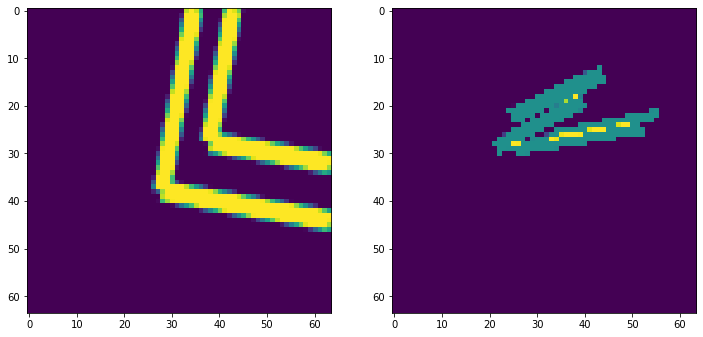

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3645.6612315614757+7763.44509142248j), end=(13.952195100184568-24.78007054584789j)) to Line(start=(113.74460632136451+89.40137503585173j), end=(5.739460193870556-39.31414588025176j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-6636.244975057529-7916.384240178566j), end=(142.10931085017563+161.74383192829367j)) to Line(start=(-6666.517544801404-4633.727199320706j), end=(76.11782836029606+87.51691636654594j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8420.188179345167+3756.7310858366536j), end=(-105.72414556186024-39.24964963754791j)) to Line(start=(17.956779014301375+15.816645809240747j), end=(90.60389467597928

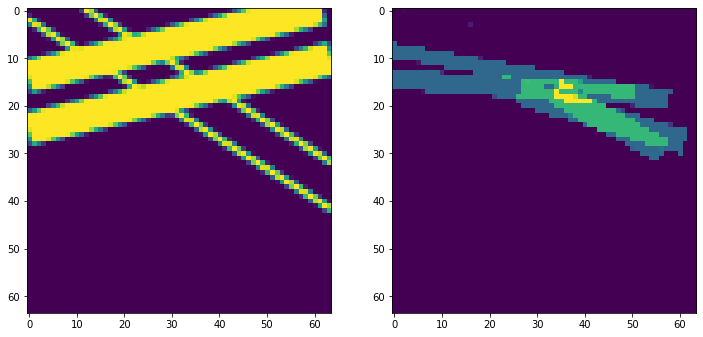

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5176.36984664528+7091.983978085472j), end=(-28.176103285447596-71.45897166064867j)) to Line(start=(41.29570537238687+30.874513801745533j), end=(-34.96081741602702+125.04347696040816j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8113.712717382365+4335.102423752709j), end=(-89.50524503847758-26.62593684131113j)) to Line(start=(36.18591386018762+33.40087261603276j), end=(158.92149622075578-4.123160618289212j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7187.538400582406-6039.511186074738j), end=(143.76309505463797+112.18119496374658j)) to Line(start=(30.09533649492985+26.163193885593465j), end=(-133.59996091877892+40.48

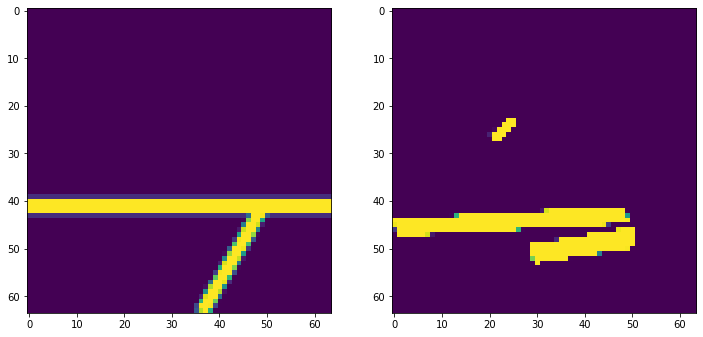

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9627.127308564706-5106.82508731549j), end=(185.0377865351784+110.39563876867038j)) to Line(start=(34.738223106906595+38.73987392575282j), end=(-136.52597411721806+91.1005936525549j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3331.9311406003917-8356.345546932327j), end=(118.8883013348186+184.7322873148668j)) to Line(start=(6.76160201344205+4.6467137673975945j), end=(90.68310935652912+116.01431550962049j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(4464.317102587656-5898.914564981183j), end=(-20.614447647407403+52.79062408026107j)) to Line(start=(8997.07042882622-6977.376599545373j), end=(-36.09576158333306+80.106306

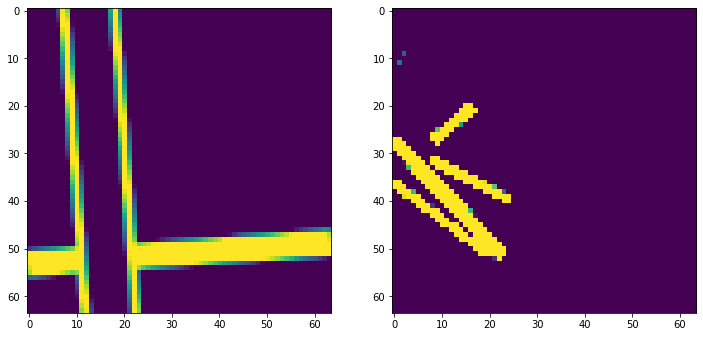

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7499.756967247068+546.1381282822024j), end=(-46.75314574794221+18.43473478100104j)) to Line(start=(61.215308429774225+69.72699016200458j), end=(-55.45799021706502+29.55315170430608j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3870.92485642102+7970.019939172169j), end=(-52.44976580561242-74.09012073380777j)) to Line(start=(12.927380198742952+39.76613123540907j), end=(160.24540268732497+90.49179431345567j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-0.5666186449234161-57.24451783877099j), end=(7785.700243000367+6953.5416543688925j)) to Line(start=(-7179.4060366587455-3664.4579826491213j), end=(100.5901624664597+44.885

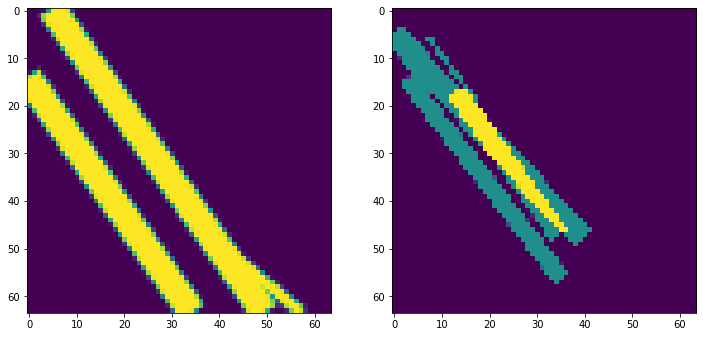

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3986.8579491699797+6473.330777744701j), end=(60.52520479899361-3.8362358109233554j)) to Line(start=(25.583887365653077+128.96406213638417j), end=(3003.6324934745926-9611.79401912812j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3995.3372753824833+6468.032306669666j), end=(52.045878586490275-9.134706885958082j)) to Line(start=(-2905.932709272835+9717.52279838113j), end=(72.11589683610526-23.235282883373685j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4705.547564840778-10028.071745761417j), end=(-61.26960059140475+194.40065431167568j)) to Line(start=(15.518236049036071+41.011080870577395j), end=(142.323

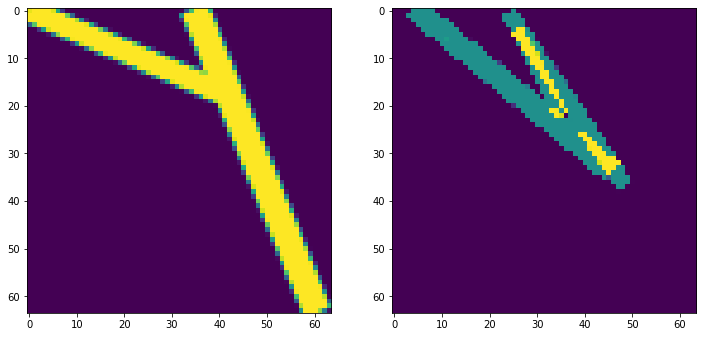

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2671.1318428587024-10662.149555742602j), end=(-33.41569410174137+185.1981393396699j)) to Line(start=(-3.627923069868844+23.201534738089666j), end=(-90.05349526407741-120.634771815135j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2799.710352942924+10322.58680912378j), end=(26.16188786872636-28.436979787805257j)) to Line(start=(102.94673307650126+100.39387464510465j), end=(33.850891093330446-19.283634261497767j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2786.996354331117+10325.993514784384j), end=(13.447889256918877-25.03027412720104j)) to Line(start=(102.94673307650126+100.39387464510465j), end=(33.850891093330446-19

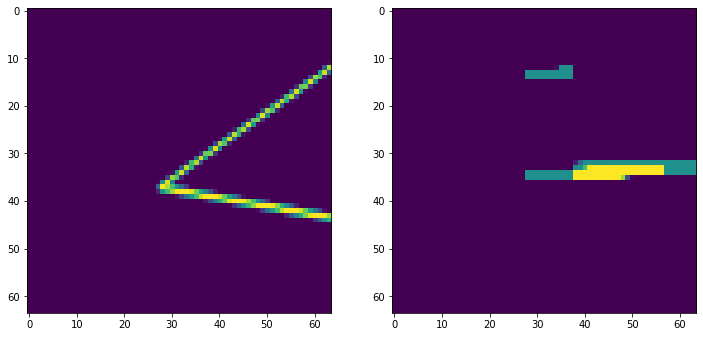

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8384.82687642015+6567.175852766745j), end=(-43.169289966957166-17.496412285216294j)) to Line(start=(101.77999372187415+35.709335445301775j), end=(-33.545104794637126-21.732760876040963j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8380.646488783654+6572.526504941402j), end=(-47.34967760345313-12.145760110559877j)) to Line(start=(101.77999372187415+35.709335445301775j), end=(-33.545104794637126-21.732760876040963j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8376.466101147158+6577.877157116059j), end=(-51.530065239949096-6.795107935903474j)) to Line(start=(101.77999372187415+35.709335445301775j), end=(-33.5451047946371

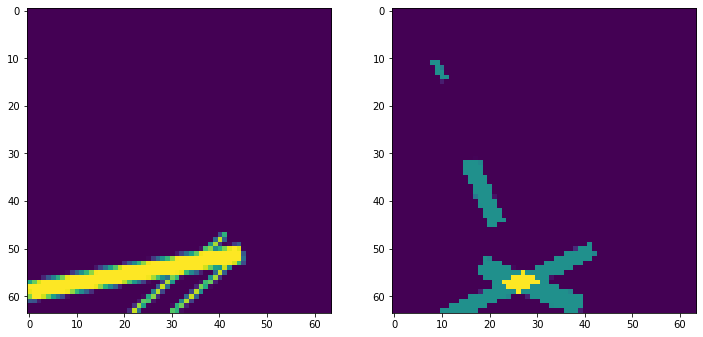

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(8364.941468075645+5616.331013574118j), end=(-88.07445397362908-85.300218852752j)) to Line(start=(5187.2669700600945+5969.133015686679j), end=(-19.053431912673844-20.05349261298339j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9106.792231049536-4796.288257505917j), end=(-95.2737837099704+96.53703331326778j)) to Line(start=(42.395359381678574+18.217664178707654j), end=(81.93085744164571-111.09712317381053j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-0.008794838903145306-8119.233493731627j), end=(-0.008794838902637157+179.89835534514432j)) to Line(start=(39.17169720100014-12.752965191833432j), end=(5.42221808489

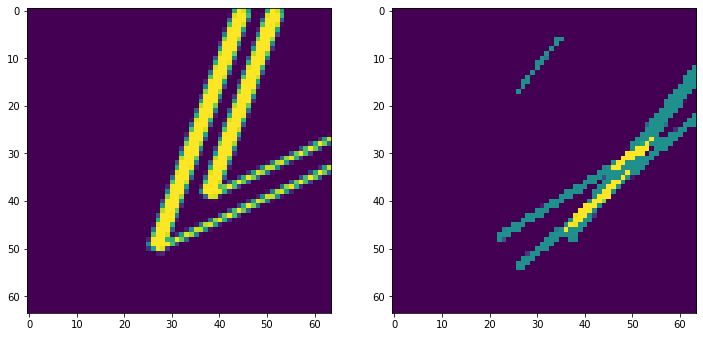

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7521.962227482945+2357.060757080021j), end=(150.21234758529647+11.441595974603771j)) to Line(start=(-39.31382350304643+23.186214656333235j), end=(89.5819838814794+18.68507387820551j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-11269.917525606463-142.14383169487826j), end=(225.74461554038447+58.51369737168773j)) to Line(start=(56.1779376204477+55.553899998933154j), end=(53.547348713530404+206.26023754253063j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1479.0307298410899-7751.093861193822j), end=(57.69759083604302+154.68799240103726j)) to Line(start=(53.661489566073236+44.63364657546078j), end=(139.50106253192422-82

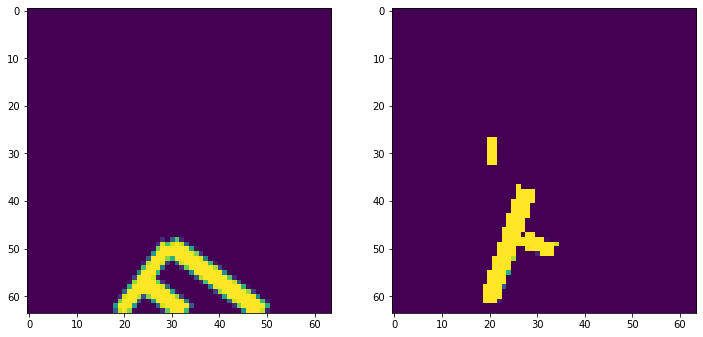

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6575.981487126063-8447.74564680829j), end=(144.02131316918914+153.46570574367578j)) to Line(start=(38.389696629026+24.21552592005003j), end=(-140.18791952868045+2.288951733038637j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4010.16310718368+6295.399091745217j), end=(109.37033758416703-48.126127115193526j)) to Line(start=(42.476795085137084+39.108347153548564j), end=(-113.37712223927211+72.23611994282888j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5738.489903153283+4800.452422257722j), end=(-57.20057023926842-62.7093163836441j)) to Line(start=(32.146714542038-0.5571079556482683j), end=(165.59033327041334-12.231911

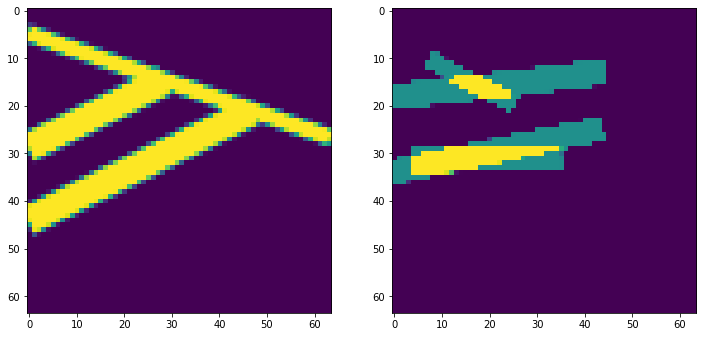

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7944.814548187813+6731.575031237166j), end=(173.4548156903335-80.46179779080451j)) to Line(start=(61.00430915606259+36.05748227765492j), end=(-21.07030639154192+153.2721808760919j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3545.105617005675-8627.434044986934j), end=(-17.04984848926391+189.21011748459605j)) to Line(start=(25.509075691643368+61.68470271280795j), end=(-83.9475154409013-78.41334519567182j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8739.98487842554-584.5167709727089j), end=(175.29386678962408+38.90024926792755j)) to Line(start=(45.63140167949564+40.24748939383707j), end=(-44.69124720347824+118.763770

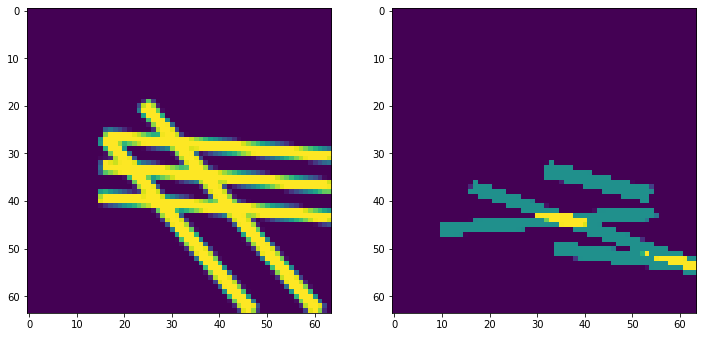

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-6919.405383999726+5896.829124087988j), end=(123.89980721021621-13.20566412529989j)) to Line(start=(-7691.479771305054+1367.5793261781698j), end=(111.39967629359684-8.278847649035969j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2238.391548288133+10785.823838166085j), end=(79.25329056248208-117.83785376785156j)) to Line(start=(43.801007587864156+48.952024164286165j), end=(-80.17486295200032+22.600139392284756j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7339.436930219565-4718.259609866992j), end=(-68.94082245673175+92.79715599650115j)) to Line(start=(38.12261217811555+18.079946961188732j), end=(30.17077705746

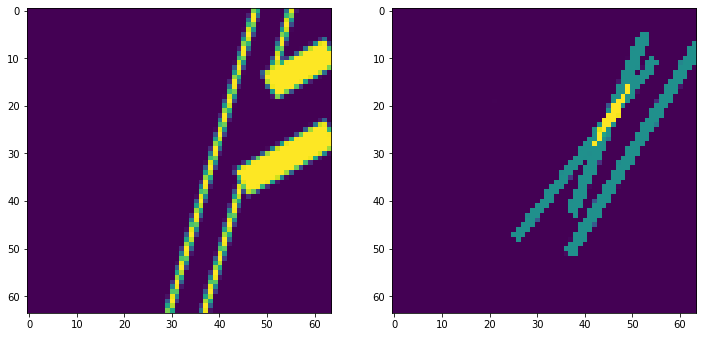

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8045.162573006471+7768.25573577326j), end=(-117.31590899759105-114.15810890234872j)) to Line(start=(-1.3068295162127583+6.1299436105925835j), end=(-34.535488781711656+139.40281663961474j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7418.521287050986-493.17362593455056j), end=(135.8540809406254+35.07975977368615j)) to Line(start=(31.240348357827163+42.2676358164351j), end=(-77.93585001533935+137.17305714742224j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7419.244390038193-482.83277144526886j), end=(135.1309779534182+45.42061426296783j)) to Line(start=(31.240348357827163+42.2676358164351j), end=(-77.93585001533935+13

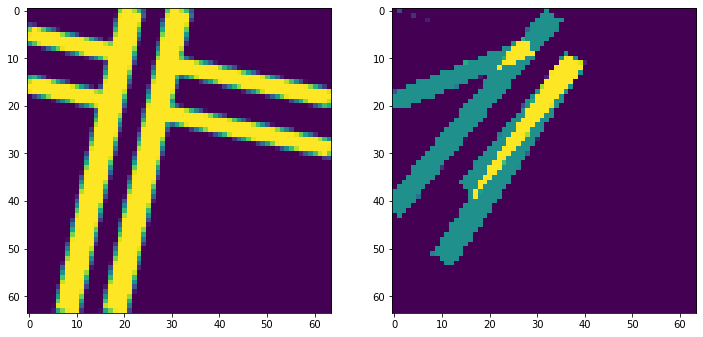

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4027.8237907376356+8199.837188053021j), end=(-21.57157698210453-102.65369045615958j)) to Line(start=(37.810584706006225+19.09778377425667j), end=(155.53873598032226-38.322072193838856j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4252.853329191191-10421.354570754309j), end=(-35.55434165423939+192.8268774448113j)) to Line(start=(19.897420198762525+31.884932425554112j), end=(-48.66493499621189-129.63785426697478j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(963.5531255783569-7696.358067568852j), end=(-2.516796693371848+171.65005305864742j)) to Line(start=(14.515827082294182+62.500456138754345j), end=(193.3881336653318+3

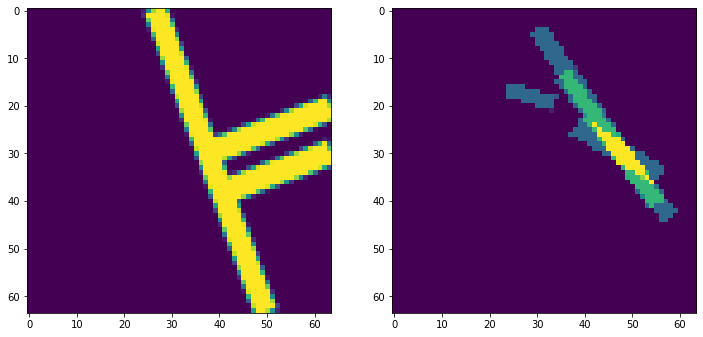

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7348.894934737731-2634.364051540746j), end=(153.43148465216478+96.25945286611265j)) to Line(start=(40.96570690763696+63.797180139615165j), end=(-69.68886867974851+115.39625614590418j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5791.9157052182445-5023.151152820052j), end=(80.02230773538083+81.24668711949607j)) to Line(start=(13.182242723325686-18.626022569583732j), end=(81.91998494393319+83.28187111037906j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6843.651640400045-9001.450969640728j), end=(-74.89519662883156+179.77078357670297j)) to Line(start=(36.2535657275342+57.99094004782583j), end=(204.22992584556192+34.383

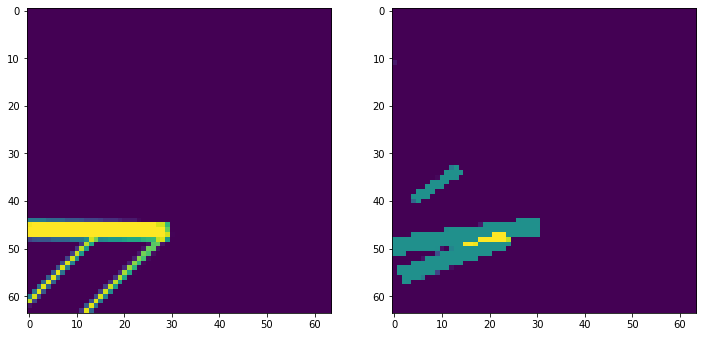

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-46.205448195011144-12.662490598016491j), end=(7930.938330463733+126.57907200019528j)) to Line(start=(-8124.011708883084+2041.4857120339823j), end=(79.79627504757525-3.9533483083909147j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7898.7063553122125-149.7284037806312j), end=(78.43742334653173-10.486841182419433j)) to Line(start=(-8122.173887470185+2048.8568111160816j), end=(81.63409646047435+3.417750773708711j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3011.1387452026565-6835.172378118725j), end=(96.67503941066273+145.09166856921166j)) to Line(start=(64.0827348321391+37.70327220362703j), end=(79.6871

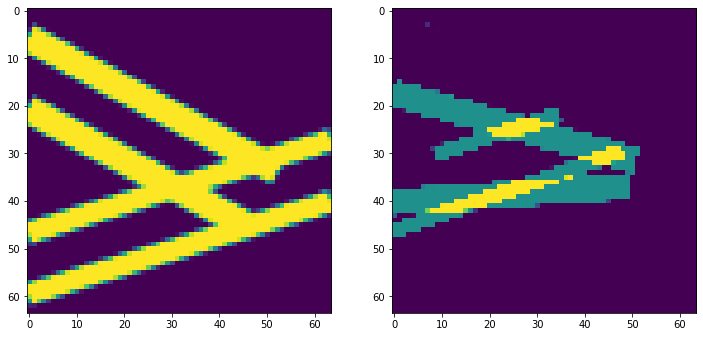

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3712.148828458655+9151.257047254396j), end=(-38.57427052871866-132.10838585407163j)) to Line(start=(25.850078946896488-0.7652151171110049j), end=(173.07797196698556+61.729317713518604j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4489.268466175367+5815.219327222704j), end=(83.00258992996065-37.02075115791865j)) to Line(start=(21.76397169979449+53.16771482345525j), end=(43.470143569779935+229.95029815777406j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4486.603655857433+5817.301305221473j), end=(85.66740024789472-34.938773159149974j)) to Line(start=(21.76397169979449+53.16771482345525j), end=(43.470143569779935+229.9

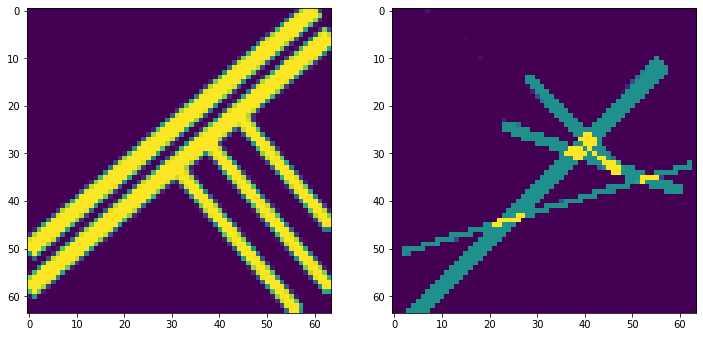

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-4370.571893548684-5962.550824707825j), end=(64.47490599927805+141.7674066335258j)) to Line(start=(-2611.7135594915208-6798.132695136926j), end=(31.8394081838505+88.55823289301979j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9108.54484640456+1998.447495857714j), end=(191.0559775274815+21.75631981900964j)) to Line(start=(56.87703273826472+59.868284300756436j), end=(-39.01785029708874+207.53345489599488j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(5030.646967119722+10260.830337742453j), end=(2.799178515310203-47.78529810913017j)) to Line(start=(12.4958074916667-37.3631142613104j), end=(6085.9515712730845+6949.

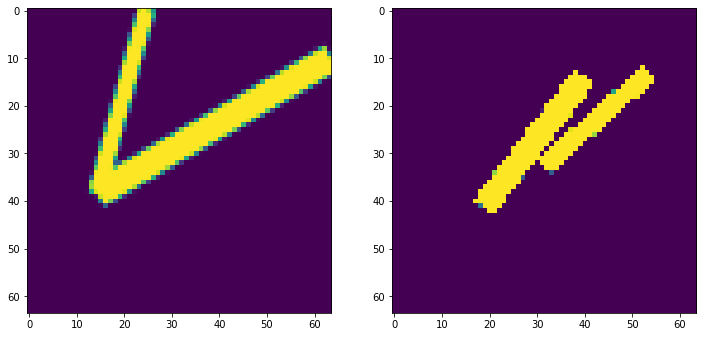

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4986.088306736398+10200.326620285889j), end=(-44.19977535704082-113.29235868082922j)) to Line(start=(37.71149352514883+38.236236115185434j), end=(207.63107142973024+96.7442388262572j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10522.780601887236-2176.6464405871525j), end=(-125.20628492599316+86.65304078135026j)) to Line(start=(34.45921664887558+46.93192022056326j), end=(131.34849433219784-102.264483853287j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5821.833233801066+9687.195095261379j), end=(-83.1754388593823-140.38968174926396j)) to Line(start=(-1.6153870172607423+10.497097430264617j), end=(-35.53536533891328+146.

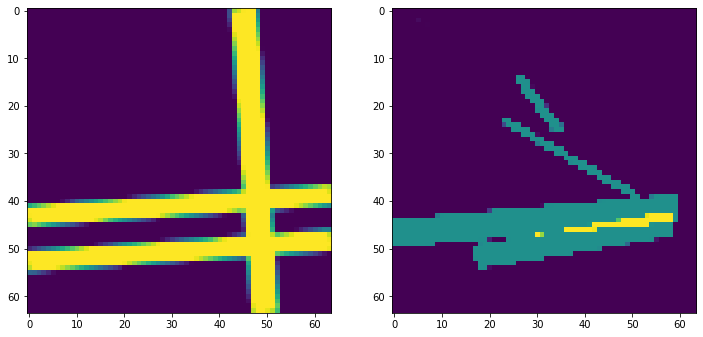

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9257.57432684354-4856.205304863415j), end=(-97.74486930152813+118.10614793060033j)) to Line(start=(36.252713268510576+36.65895194644616j), end=(86.82897783711572-128.76855545092263j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8098.80414263899+4162.679898073602j), end=(-102.83369963426219-16.263310101192744j)) to Line(start=(16.386736487655646+51.93426082960862j), end=(69.77145765380874+216.2355382993693j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5802.655240239892+9606.345609511221j), end=(-53.545223318514104-140.00866652062066j)) to Line(start=(25.113731125022525+9.075705843448972j), end=(-17.158614285358162+178.6

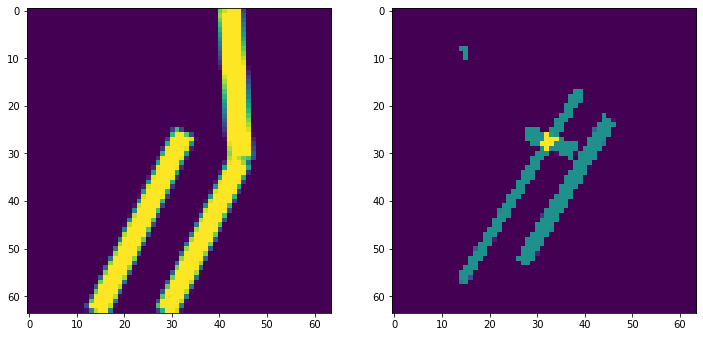

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-24.2178799996582-6.090640562222827j), end=(9679.356603896262+4518.760452755874j)) to Line(start=(89.9828471851028+81.24950126498712j), end=(-0.05629723791534502+5.6976883881147415j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9576.174012584705-4460.240935547225j), end=(127.40047131121554+64.61015777087243j)) to Line(start=(89.9828471851028+81.24950126498712j), end=(-0.05629723791534502+5.6976883881147415j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10639.552848275558-2822.490503492956j), end=(223.71181545882703+88.31249032021927j)) to Line(start=(-3.392644602415352-23.897632482116506j), end=(140.44513843467396+59.

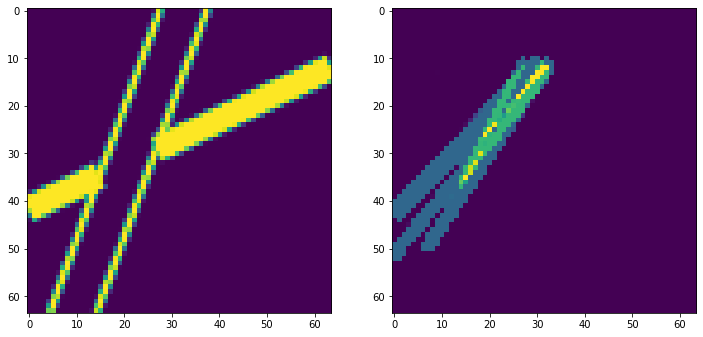

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6516.5771196738015-4745.112084887852j), end=(145.86110900568872+95.43262845650489j)) to Line(start=(9.186712219877242-55.428428480673205j), end=(105.82823263848483+63.913910287489415j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6521.52725995163-4738.298801305652j), end=(140.91096872786002+102.24591203870446j)) to Line(start=(9.186712219877242-55.428428480673205j), end=(105.82823263848483+63.913910287489415j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7606.736788387795-7282.227911333698j), end=(-110.24696893696637+169.97667848333987j)) to Line(start=(-2.8948032262829795+66.30789710530406j), end=(-121.24333521025443

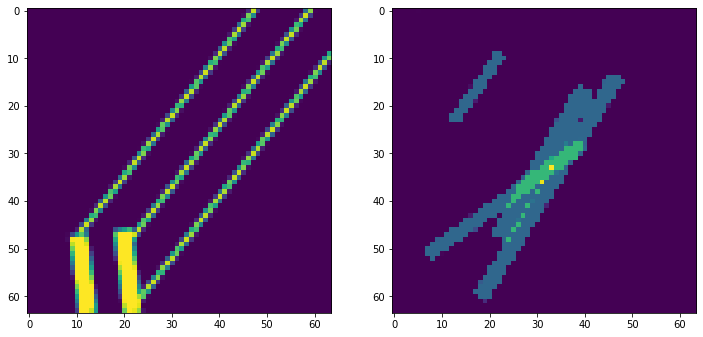

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3677.139862925197-7108.751777595957j), end=(18.153841130490157+72.41262827483344j)) to Line(start=(43.30311767015725-75.87347652130586j), end=(6.894732631526722+95.41450796892019j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4406.464904278984+7390.295460634377j), end=(97.45206104794826-105.48113496964667j)) to Line(start=(60.394802371909094+89.17858547535565j), end=(62.76092649668616-46.376574846739544j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7428.158536392311+3333.9112592497804j), end=(-109.12674331702908-21.904356630593426j)) to Line(start=(-6.085775865744649+23.972437840661605j), end=(63.9256744663483-133.275

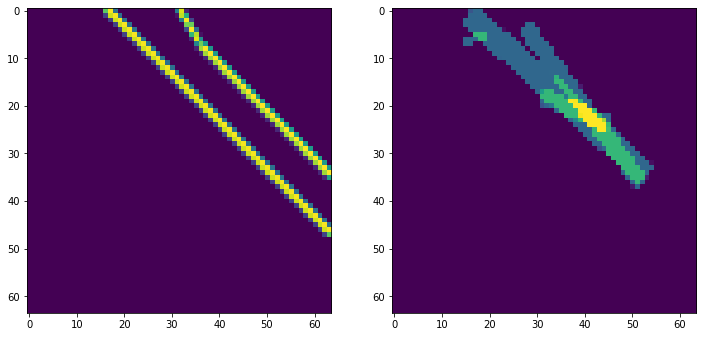

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(26.91939507464261-15.740307387585855j), end=(2185.437315551769+7044.453684849951j)) to Line(start=(-22.612027244877027-20.000913294993225j), end=(61.03391708443981+113.86057962945789j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2110.157618599322-6961.86258100118j), end=(48.36030187780332+98.33141123635687j)) to Line(start=(-27.619015042529334-16.872200074856316j), end=(56.0269292867875+116.98929284959479j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2097.8716828950282-6965.618768496411j), end=(60.646237582097704+94.57522374112565j)) to Line(start=(-27.619015042529334-16.872200074856316j), end=(56.0269292867875+116.

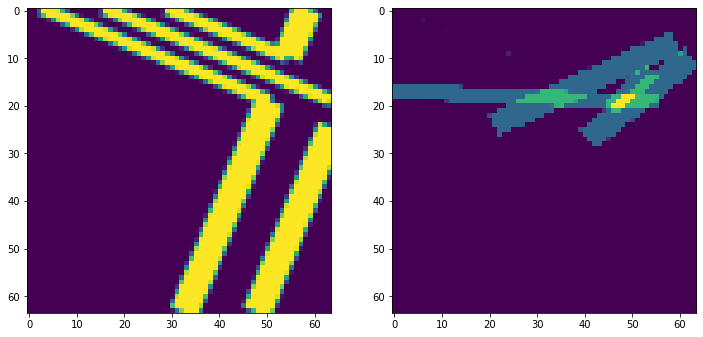

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(902.5806018374444+7324.908873381655j), end=(-4.781418864945284-64.96175880568178j)) to Line(start=(8.349362770126474+41.979875700429595j), end=(-125.22873949631531+58.381204333457944j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3556.8066556142917+9322.04370581557j), end=(40.17839460839107-48.42271438664727j)) to Line(start=(-759.2266244429507+7576.752765575621j), end=(40.211846901067-29.39620951797839j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10326.640007816171-3876.092794009092j), end=(-21.203589580120536+96.07220320284569j)) to Line(start=(74.73625102571822-22.65303066767797j), end=(-13.073081195047507+

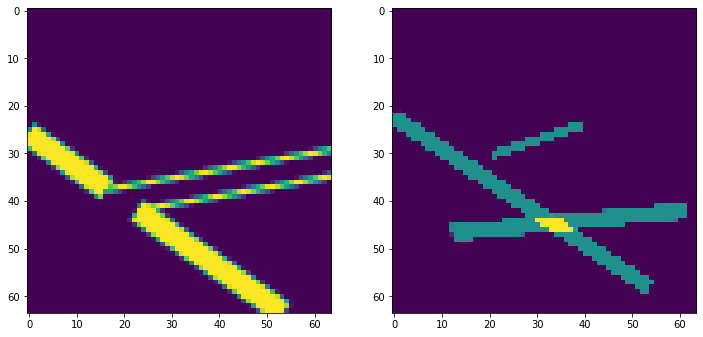

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(38.66197662290279-9326.351621584896j), end=(38.661976622903246+182.07327731159734j)) to Line(start=(74.93134760506581-25.13548637202528j), end=(41.864585658621316+98.27134925389078j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4359.560290286426+9862.51000197061j), end=(82.23967085365261-113.9360530763135j)) to Line(start=(19.191129268092077+27.673289865884506j), end=(-141.94433010088724-44.06883886555321j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5674.149540853903-5047.459349283616j), end=(-56.39612066623135+112.34714038255159j)) to Line(start=(49.5439603126824+59.76596060585938j), end=(-94.7409025820119+133.28277

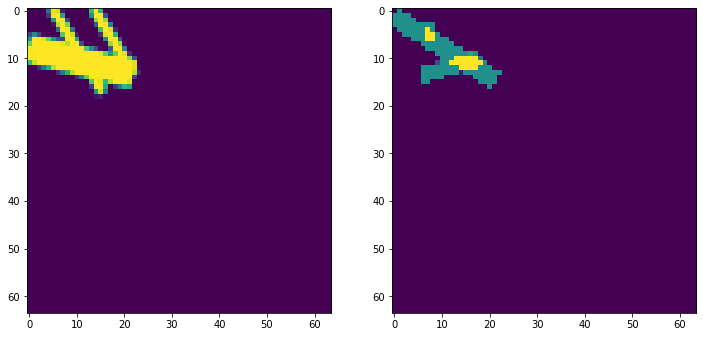

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6927.148349816166-2485.6836134930986j), end=(119.27721121535699+79.0055486949009j)) to Line(start=(10.799053275388626+42.4111885544403j), end=(-147.22151389053747+116.09738916990797j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3001.656332240683+7123.158204442596j), end=(60.030462475306386-89.72387430041593j)) to Line(start=(-1013.3042251055666+7495.89625031374j), end=(44.13996604448541-28.21013050639924j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-8664.600815752061+3558.0156357696287j), end=(195.17508521961594-21.566183245237312j)) to Line(start=(-7615.210579176413+955.8891742313333j), end=(109.20748769070

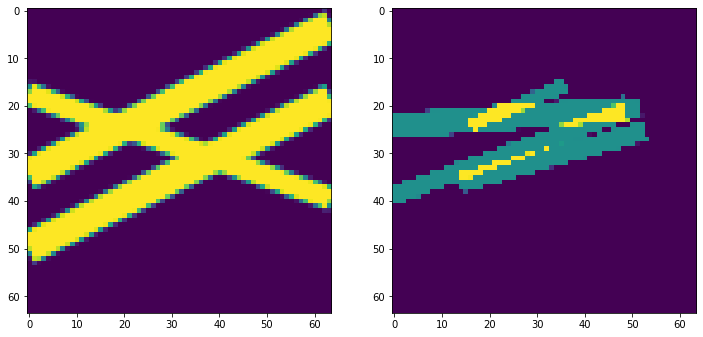

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1327.0349454633563+10662.673170058215j), end=(11.475195125694125-51.701183391499924j)) to Line(start=(69.59067367443339+82.54636558363913j), end=(23.367058585911302-31.861096439336933j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2372.691109952433+8404.425908002973j), end=(64.46513293909362-94.94797535397318j)) to Line(start=(30.03355763610852+25.129197681852865j), end=(-127.39305428229403-20.012156881391597j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8967.242399858313-892.6922829642783j), end=(-102.80549138868392+60.60816446829698j)) to Line(start=(34.93412553971798+46.1311473652501j), end=(48.026512645552+170.696

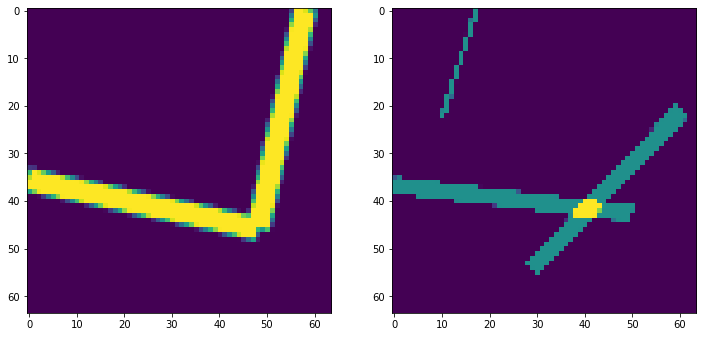

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7111.702424600987-2118.8674472229923j), end=(-96.31203641704815+84.84372590793294j)) to Line(start=(4.3773990832502125+72.85869581775137j), end=(143.46702519657438+146.8139618684745j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2326.473173540655+10248.778699247381j), end=(69.12408057933052-127.69301147470527j)) to Line(start=(26.866630233835803+26.71575528700913j), end=(-102.90664037175584+107.80709478547897j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6692.686683505067-7439.14760305258j), end=(121.25533544565573+128.50167851459003j)) to Line(start=(22.442112301199547+18.758476259747347j), end=(-81.66815267255112+1

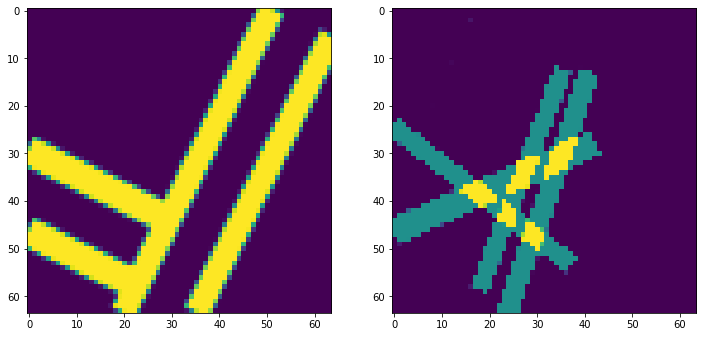

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7137.872191913352-4757.277749148507j), end=(-35.912263743832966+81.50096418408484j)) to Line(start=(62.22019810553463-41.02479605819715j), end=(-54.34168389289541+93.06431047902018j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7143.744451574154-4748.571766178433j), end=(-30.040004083032926+90.20694715415881j)) to Line(start=(62.22019810553463-41.02479605819715j), end=(-54.34168389289541+93.06431047902018j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6090.8561988050515-8597.845760628614j), end=(4.330349137920663+94.6139995578738j)) to Line(start=(14.70281166995506-65.8486102761395j), end=(1.211229482646921+88.360879771

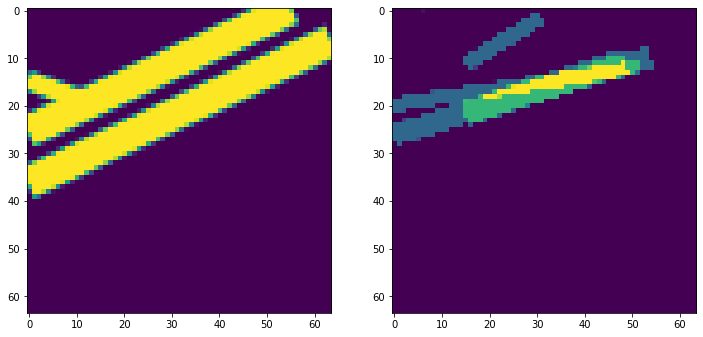

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-709.5147706872499+8380.783350142281j), end=(31.072179956949217-84.16423046347876j)) to Line(start=(6.275603188493616+32.33974664593203j), end=(-100.97799183166595+122.33619866978532j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-717.5602255004702+8380.079464053215j), end=(23.026725143729035-84.86811655254559j)) to Line(start=(6.275603188493616+32.33974664593203j), end=(-100.97799183166595+122.33619866978532j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9146.281721776384+6384.603742860136j), end=(-104.95506064329014-93.1819899530604j)) to Line(start=(23.452797595844693+10.879808580585376j), end=(45.493293651645644+135

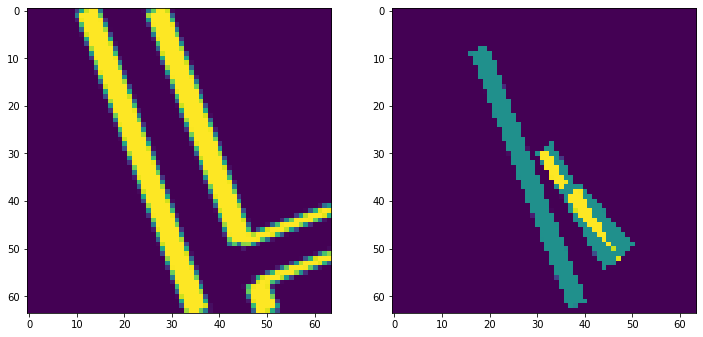

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9548.343277041271-4223.496747713708j), end=(164.23756850541895+100.82285310191679j)) to Line(start=(19.332543147375382+51.110770964257824j), end=(-125.85558407193349+106.843271317897j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9553.484957407438-4211.9483445316355j), end=(159.09588813925222+112.37125628398859j)) to Line(start=(19.332543147375382+51.110770964257824j), end=(-125.85558407193349+106.843271317897j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10002.773867715314-5082.6233594702435j), end=(205.51445208985433+118.75933524720848j)) to Line(start=(53.5171246964146+35.048500775747385j), end=(10.09827054410010

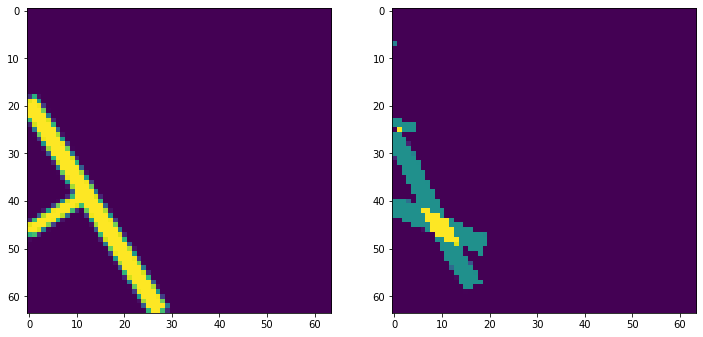

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2548.9220309367333+7337.59541201714j), end=(-6.365832786737286-83.49939740158064j)) to Line(start=(29.306292127499045+26.148027024989542j), end=(-91.25073442176254+107.46476819766505j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6438.156505235533-5814.333645491501j), end=(132.45277664646125+101.86952541596693j)) to Line(start=(14.421481194572504-55.66388900504209j), end=(83.00246122646608+49.941559330138155j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8665.2870086501+2052.5952867004817j), end=(151.28273940830434+17.12977703387266j)) to Line(start=(18.5163480781925+40.94423790922051j), end=(-112.91520140831764-41.18

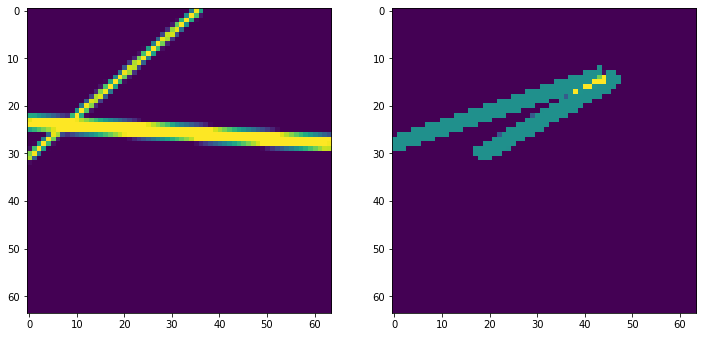

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1814.2193352448494-8746.931778869619j), end=(64.100551930391+89.86851756719616j)) to Line(start=(-36.59677296653527-12.778597555796514j), end=(59.992504308112956+94.49466258373475j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8344.606924771306-2045.901058481718j), end=(-117.33818757392072+63.89881654793209j)) to Line(start=(8.071648124450874+32.63063267636567j), end=(43.02369328054141+172.8156289764975j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9409.710944233122-4993.35219177257j), end=(190.12252396057562+110.96980564554363j)) to Line(start=(44.803717141779465+38.702085355255626j), end=(-90.15200685630452+123.031

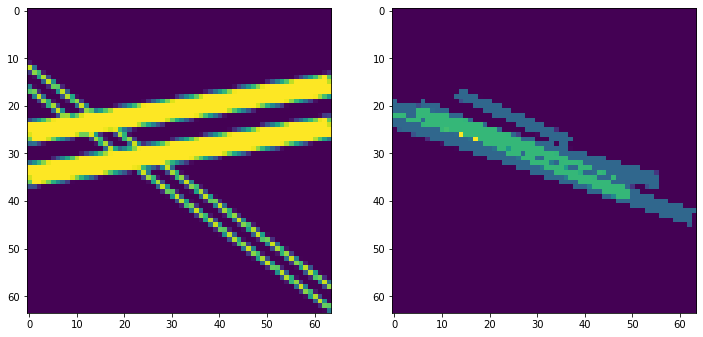

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-4138.2565882251165+7884.422384403371j), end=(107.59319727450671-100.85967507080953j)) to Line(start=(-5135.971977619475+5550.022606378941j), end=(67.4320109976649-29.945016631706864j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2563.2172025034442+10200.460186443985j), end=(-14.995985572834549-140.18811088301788j)) to Line(start=(35.76159801228958+3.954515547691564j), end=(167.63482600835482+83.19194495456992j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7465.26738552279+164.1104628220109j), end=(157.79139116467422+31.04947692331183j)) to Line(start=(46.761126237550336+24.761440422789832j), end=(-49.0647999440

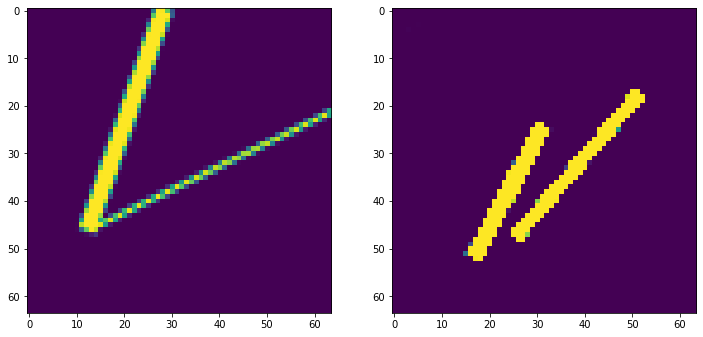

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(6330.112535827473-3731.1207959463854j), end=(-4.628294238293506+75.17550058609517j)) to Line(start=(7582.71811399376-7787.292766541089j), end=(-25.993454503055816+91.75871152635096j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3470.256767280732-8967.895996665571j), end=(-32.43689414878013+156.9329576967433j)) to Line(start=(33.230823184587564+38.92494497248751j), end=(166.86997344774352-20.575038204927317j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-729.5231959532008-7482.4862178548165j), end=(73.84768187394309+161.07710570134518j)) to Line(start=(-3957.140331051457-10335.994891783283j), end=(60.2757364248993

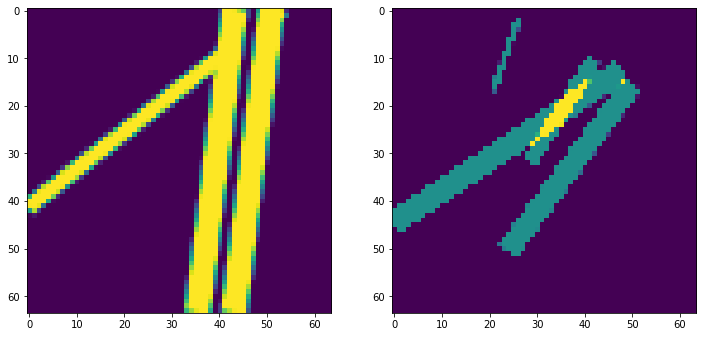

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4055.095693549082-6170.824872864616j), end=(-23.860116938796544+110.21626865359136j)) to Line(start=(42.928786339075366+26.448674887905934j), end=(186.90712452141042-4.15486563109495j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-404.993303729911-8004.888354236091j), end=(21.99981903387911+142.62578593960862j)) to Line(start=(20.421877177620484+19.907378748819347j), end=(106.12144062243324-75.27162892838822j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-5082.811034671434-6710.497635076456j), end=(96.53313446397357+162.72422396454908j)) to Line(start=(-1092.7256742973004-9261.708414710198j), end=(57.96603167443616+109.

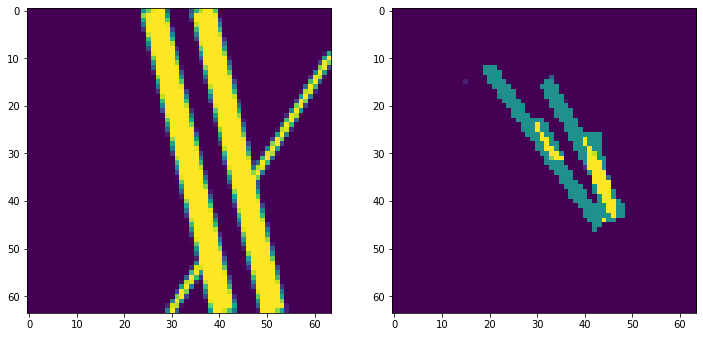

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9507.145753723484+353.2357023674174j), end=(178.31728637514075+15.011880123292485j)) to Line(start=(32.504474256101894+20.10377572424494j), end=(28.37516835396015-98.14407397212513j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-9662.87720335147-1855.3998243408425j), end=(108.01224727630805+43.868687622659465j)) to Line(start=(-17.43151286340634-18.940891429035858j), end=(7479.85520410555+3637.730166258681j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-9665.935847766814-1839.664462930456j), end=(104.95360286096344+59.60404903304565j)) to Line(start=(-7397.573124879723-3618.4764638403826j), end=(99.7135920892335

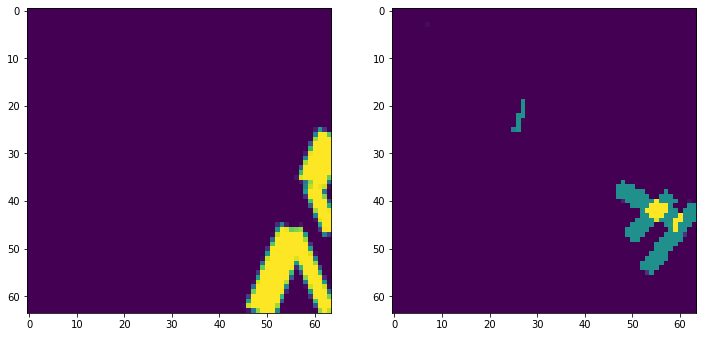

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2082.4214446522533-10489.298183625233j), end=(8.63070624320391+179.43028793906885j)) to Line(start=(41.87686339706438+24.78939653005567j), end=(208.01496033836293+13.171889068588728j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9521.986357214037+4264.211573450709j), end=(-120.35583245604731-28.835762951134548j)) to Line(start=(28.651303010049364+33.93308277632656j), end=(149.41577080077963-12.424053118727741j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1821.9524330197873-10094.992802663752j), end=(6.391260306170409+201.5662685507972j)) to Line(start=(28.093679573377777+45.34992329501699j), end=(-57.9058226345855-77.4

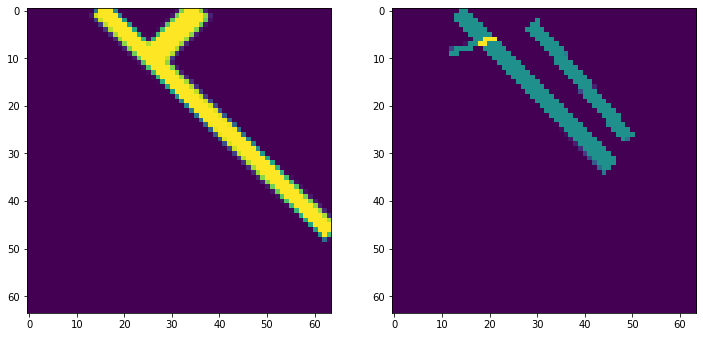

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4129.636190477622+9001.648400109145j), end=(110.57768409173178-91.51959834550121j)) to Line(start=(40.838404644731085+40.983616632518235j), end=(-108.50007622306252+95.33837849892788j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9266.863994447156-1110.6866456342732j), end=(196.09240860424785+51.21830115772438j)) to Line(start=(53.55275184205521+28.907849181417678j), end=(-19.15463676040965-64.15336445891771j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(970.6182142982311+7757.16910722076j), end=(6.918715671175052-91.53346206342898j)) to Line(start=(11.451300375280178+22.879312509549145j), end=(-93.05356165649997+156.

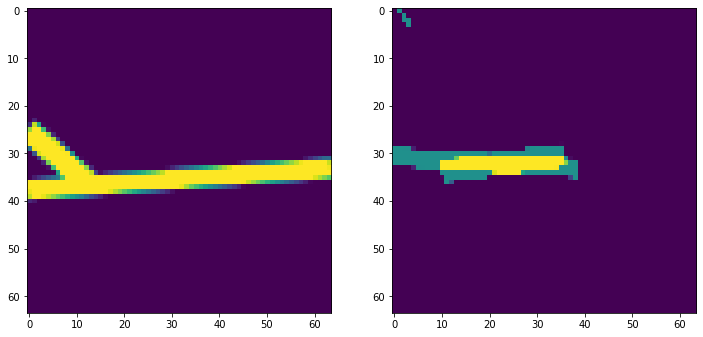

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-443.29156977259424+8944.867827654189j), end=(30.83493462575221-102.00481004541304j)) to Line(start=(30.28949848649074+28.784804286070035j), end=(144.8638225986022+103.19024034994774j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6389.687770103817-6128.0503948088035j), end=(-86.23367013070984+125.67424655813588j)) to Line(start=(4.854052775629393+33.557516485119535j), end=(-56.63772775856138-77.37659215523044j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1491.523888419527-9657.91728113155j), end=(69.62185227358297+198.76900379806398j)) to Line(start=(42.93153655672095+66.6167101134119j), end=(-132.67995509452933+48.15

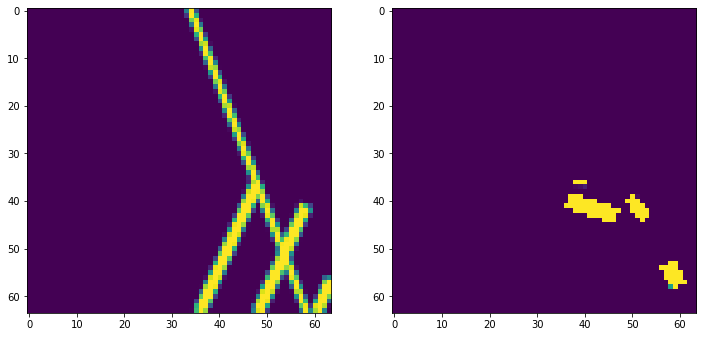

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2855.638457767466-9867.004608484447j), end=(-28.306599090040784+190.5070380440785j)) to Line(start=(26.353627833794235+43.29804472908515j), end=(133.45930575149023-60.132706154135874j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6746.771440341289+6384.422212537487j), end=(155.21253831467817-51.781971839639176j)) to Line(start=(26.859791264733616+127.28338427093514j), end=(108.93340854722972-4.0618593895435j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7149.783502427386-4442.0790031408815j), end=(-95.24555312523374+85.1176073665323j)) to Line(start=(6.911524852963058+11.829874619797419j), end=(35.879979039582075-113.6

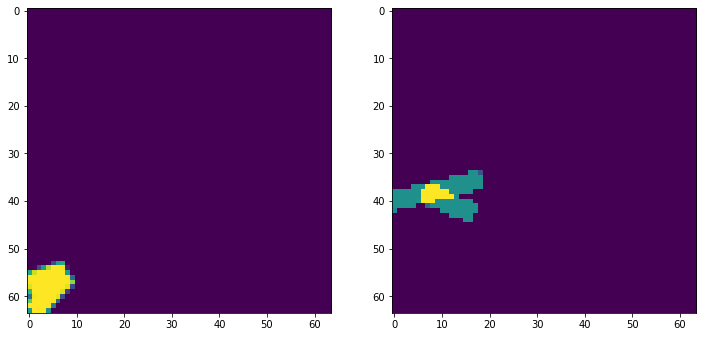

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6946.506978338718-8560.838034736335j), end=(130.96759900143658+179.115196270126j)) to Line(start=(16.369731231488338-27.146412054673135j), end=(69.4943623547556+92.17346304828156j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6957.00494093287-8552.336952246511j), end=(120.46963640728363+187.61627875994952j)) to Line(start=(16.369731231488338-27.146412054673135j), end=(69.4943623547556+92.17346304828156j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1176.0465316822551+10994.276191682298j), end=(6.910728675191965-129.30793460709666j)) to Line(start=(31.014617897683685+37.29103183414592j), end=(169.71770859890327+149.610

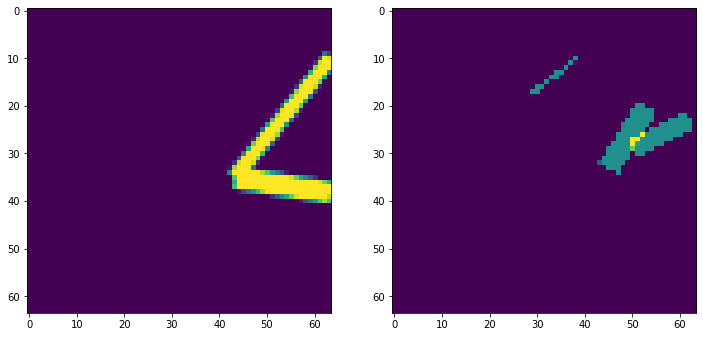

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2003.8096924905317+7070.544688734129j), end=(44.854731686175725-73.99721472273592j)) to Line(start=(16.34235366901284+25.43726420256985j), end=(-140.89987061137725-19.651218056283575j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(5311.919695202483+6371.286176369445j), end=(-84.64894293483057-60.09388581193963j)) to Line(start=(7280.069430376348+5113.855667379237j), end=(-43.64715678549949-14.265894662974091j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4894.178752723608-9095.793595404133j), end=(-36.246027475778234+176.9867741162323j)) to Line(start=(36.594612545131966+39.993454676141184j), end=(141.80930848831

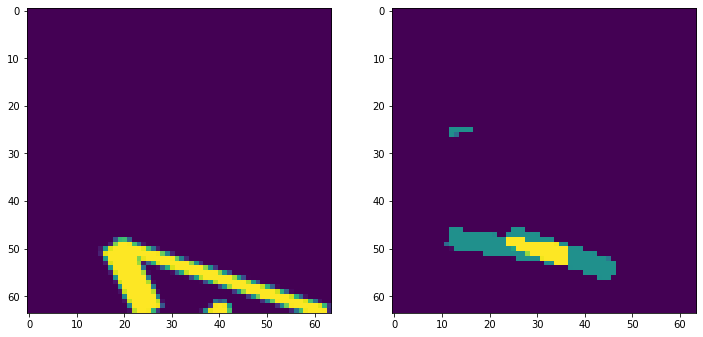

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-967.6097515855611-9623.187575725873j), end=(61.96596639333413+172.57103834322584j)) to Line(start=(40.279148499910164+26.427360271627784j), end=(-65.28155875692488-59.05401499772959j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8070.444438311686-2269.918248276778j), end=(154.02545079891937+88.41054273794346j)) to Line(start=(28.801146950284437+57.48441301708507j), end=(-87.3319211793792+121.85802385433871j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3245.375274702485-8773.806065476783j), end=(-14.433799139625918+182.4457566377026j)) to Line(start=(33.26595687497361+51.39175407409559j), end=(160.28416514214268+97.62

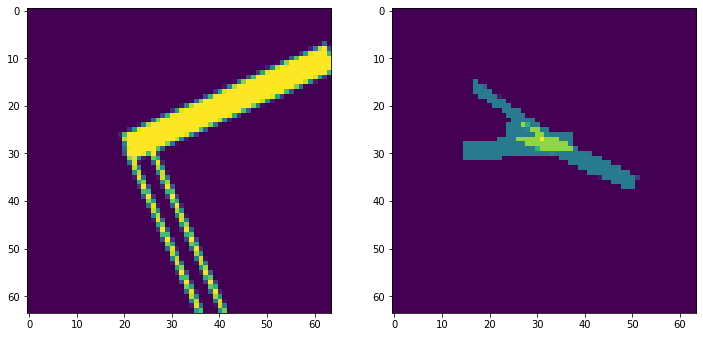

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9103.261454024825-6801.111763762921j), end=(-89.33530761036934+126.00675692910944j)) to Line(start=(53.05475074202672+26.623943008921348j), end=(202.66651199899562+47.650504817270665j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7646.611107653747+433.0676856263192j), end=(-90.06657469175772+27.605589265923687j)) to Line(start=(20.125864641284423+43.56908953586329j), end=(138.81754543271308+175.38955562893568j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7646.348645204296+438.0757674996963j), end=(-90.32903714120908+32.613671139301054j)) to Line(start=(20.125864641284423+43.56908953586329j), end=(138.81754543271308+175

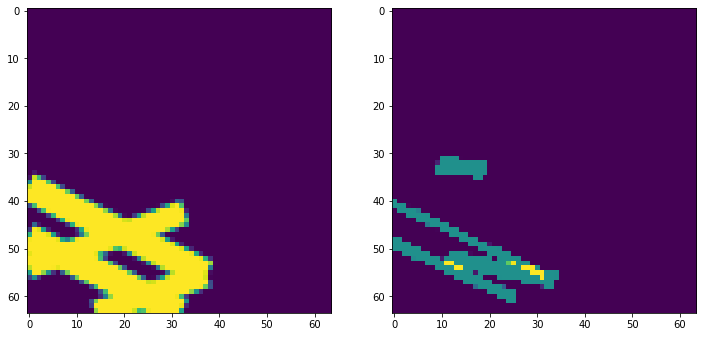

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9462.548010098591-631.1078561763889j), end=(164.5083513536938+42.08150358046075j)) to Line(start=(22.117120553945927+34.3283956162292j), end=(-30.005668564830106+185.7039667497816j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1957.3982837604365+7977.399352615071j), end=(52.86105112861746-85.31045922040455j)) to Line(start=(30.27604153647312+35.36661086556386j), end=(120.17891028218727+184.99011072350743j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1953.0386595269235+7978.486329018361j), end=(57.22067536213046-84.22348281711604j)) to Line(start=(30.27604153647312+35.36661086556386j), end=(120.17891028218727+184.990

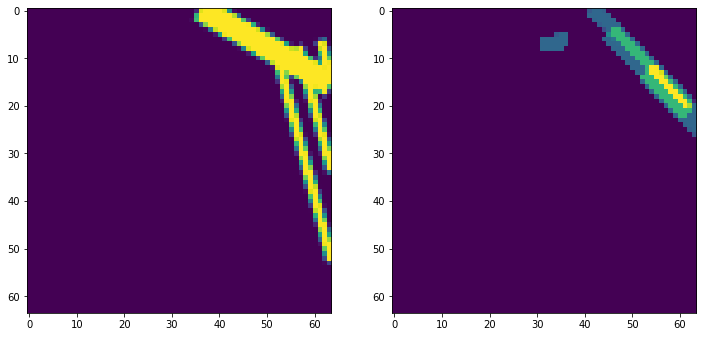

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6686.496916502716+5433.291119571462j), end=(-62.6566363399264-32.06566510186775j)) to Line(start=(24.514659528391284+55.25228450151655j), end=(40.92975844961722+211.43151819017606j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8823.02628590713-2341.230399691886j), end=(181.0137979835417+71.39486940407276j)) to Line(start=(49.16354390094178+31.329498848094957j), end=(17.662699170264172-86.23325416813186j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6596.689554455913+7038.572097012575j), end=(-48.37568188221215-87.38793850920129j)) to Line(start=(50.412324076215114+23.779146615203388j), end=(44.781129161489794+185.03547

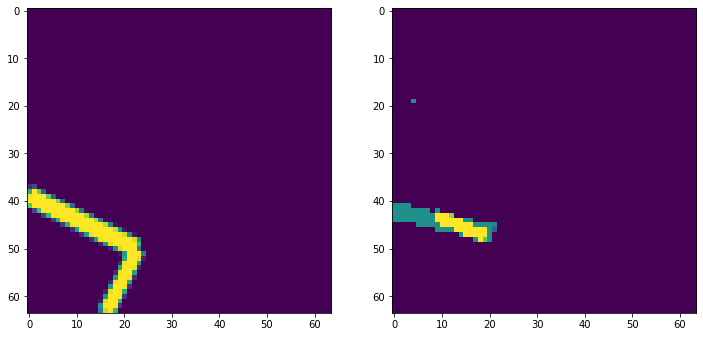

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7282.770488591525+6410.615946544897j), end=(145.23028774227683-46.44661681071278j)) to Line(start=(29.573812547899816+48.63838703439248j), end=(-111.67932185114901+38.76100566883879j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3952.1654634926717-6115.971531163741j), end=(67.09742240226035+73.1505671861562j)) to Line(start=(70.03939044828934+76.66884321084602j), end=(32.99167753452904-37.35229291382903j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6313.123572558521-7253.83687058859j), end=(118.10622768558446+144.44671119051372j)) to Line(start=(21.870465742098855+37.566839776421965j), end=(-119.89000550034716+106.7

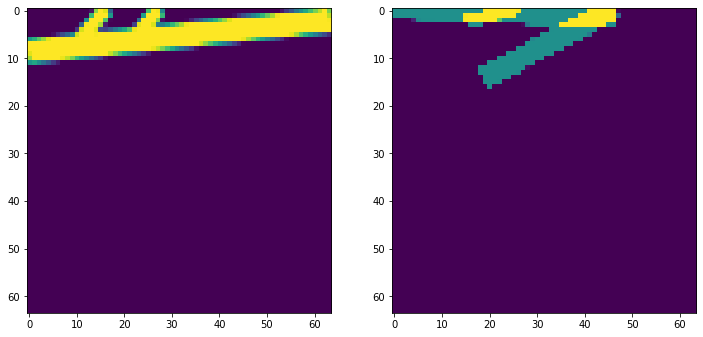

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5179.204634290346+7774.318437234151j), end=(120.3764214644684-82.63358549747326j)) to Line(start=(47.694385208431264+43.61723429030888j), end=(9.340758788016238+155.0042533387929j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5172.223969355131+7779.026955186177j), end=(127.35708639968331-77.92506754544749j)) to Line(start=(47.694385208431264+43.61723429030888j), end=(9.340758788016238+155.0042533387929j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8404.658249804952+1237.0156314506341j), end=(142.31063352890894+35.81749041152331j)) to Line(start=(20.948966151164154+52.8737604456656j), end=(44.71055930999498+221.94628

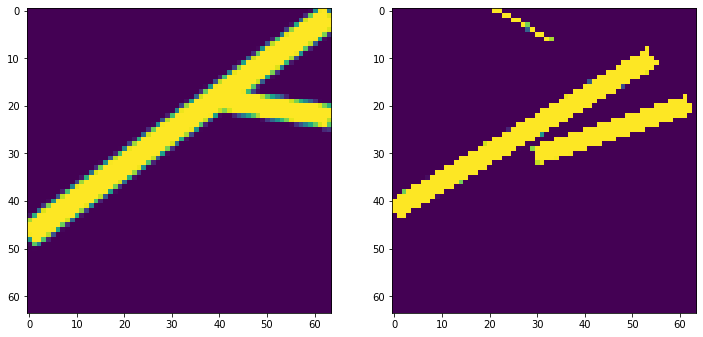

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(6976.837374335345-6220.770050244113j), end=(-9.638644908508184+69.88121287292849j)) to Line(start=(3516.8733998729354-10786.532865811661j), end=(-16.61994333303641+88.44142529171097j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10262.166914921108+2969.825348042272j), end=(-126.8563535837422-9.17913674238126j)) to Line(start=(19.126019399378674+32.68063511264988j), end=(54.41652906140851-90.39199801322002j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-9885.874409881302+3461.372838496892j), end=(116.92798674136938+17.13176305966423j)) to Line(start=(-7893.295468490594+579.2404172490973j), end=(96.5054320884016+20

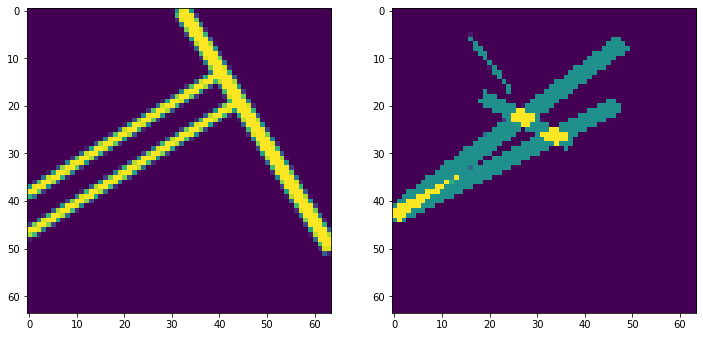

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7337.552781404551+7126.1059738577715j), end=(149.1343889021463-103.70378699954898j)) to Line(start=(49.03824199259171+9.556690311959676j), end=(46.91720870934089+131.07060572696628j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7333.92023570522+7129.867585045657j), end=(152.76693460147635-99.94217581166312j)) to Line(start=(49.03824199259171+9.556690311959676j), end=(46.91720870934089+131.07060572696628j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9786.10536977369+2815.225768107915j), end=(-146.2652407525528-32.83567410687587j)) to Line(start=(53.52815613781056+65.04847692808004j), end=(-59.144991467569234-2.6523802

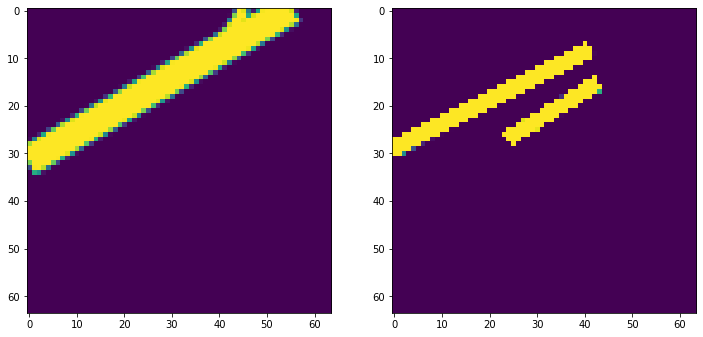

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(8457.570080397607-4068.231303776308j), end=(-43.63186039406831+78.08192472714508j)) to Line(start=(4617.065985721703-6822.580889517862j), end=(-31.540073889894735+69.26101245410472j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9155.357222630308+1163.0524253945525j), end=(178.26861774603086+17.027274951942573j)) to Line(start=(-29.093382101949413+90.26824264170702j), end=(108.08581388797334+34.84424982279734j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9157.144863026519+1148.4932627191724j), end=(176.48097734982034+2.468112276562298j)) to Line(start=(-29.093382101949413+90.26824264170702j), end=(108.085813887

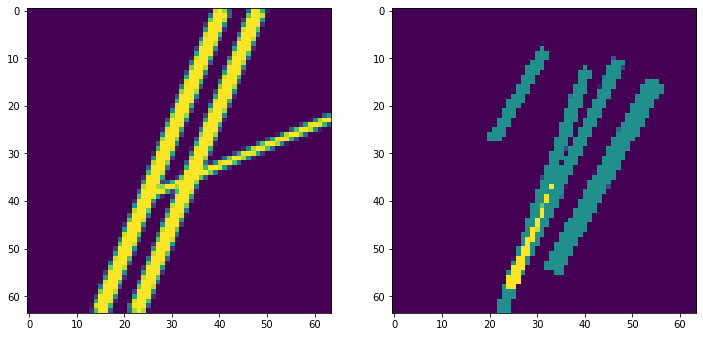

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7077.627934732414+3814.8132316442898j), end=(174.67940565781873-41.306982548971845j)) to Line(start=(50.639582180001035-13.538317143521635j), end=(207.74622737097718-49.809244132568j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-5219.008822029297-6027.818026374921j), end=(133.54482754836866+129.59059005473955j)) to Line(start=(100.13715831315864+89.6797976811335j), end=(-3974.600394252762-8264.770259772184j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(5845.058563442866-4392.907228582746j), end=(-88.80469338667345+78.57946135730738j)) to Line(start=(7217.491274435072-2877.644164714681j), end=(-40.32620225621858

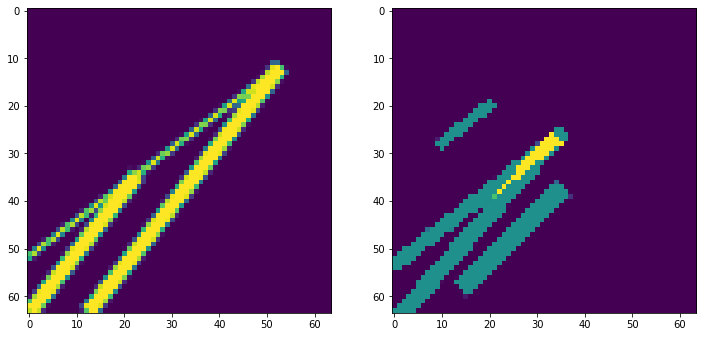

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9345.456232713223+4189.369221212726j), end=(162.88832334009555-44.018524939468946j)) to Line(start=(24.40655842498455+25.999856844294598j), end=(-22.247575922559893+147.53803205583813j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9342.715430087817+4195.525164699402j), end=(165.62912596550188-37.86258145279307j)) to Line(start=(24.40655842498455+25.999856844294598j), end=(-22.247575922559893+147.53803205583813j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3045.984663311006+7472.870211394343j), end=(-7.54655148778113-84.8847548504202j)) to Line(start=(44.308914170457754+23.442419053118535j), end=(207.05133297593238+92

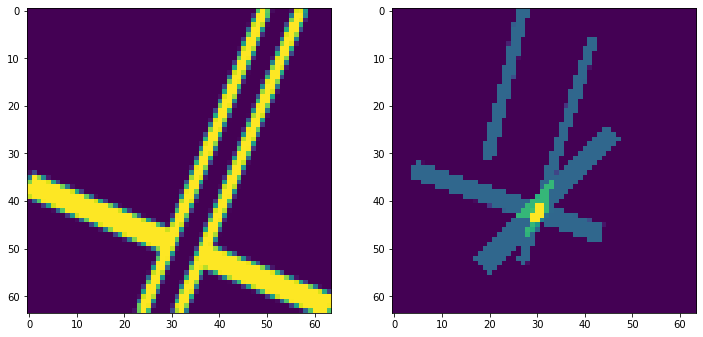

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6065.345546808254-7678.433965800822j), end=(-41.14697693743173+137.52004201706237j)) to Line(start=(53.261372469650915+22.550949943257642j), end=(177.59812282080966+40.02534062179235j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9485.56133136353-611.7742971554225j), end=(-128.21324976169765+60.4863100462241j)) to Line(start=(14.129848562371471+43.13910028074989j), end=(96.17794795654333-51.246441134834726j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1695.5560278695964-8373.466480001278j), end=(50.6261355031982+88.96420376187696j)) to Line(start=(-4.467138560494636-49.820300481161524j), end=(48.49107017152237+103.9815

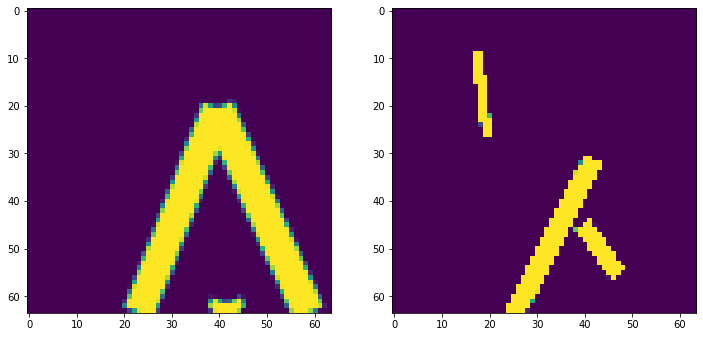

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7148.578791485564+5187.110398331857j), end=(-71.17352357511746-58.34670022488505j)) to Line(start=(40.095301497083135+13.891621732141994j), end=(188.91974477499136-9.679854423040231j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3529.75689559965-8634.91324542399j), end=(-34.073809881535176+185.8772815138125j)) to Line(start=(9.921733806970712+53.01424770467779j), end=(-54.78493824670753-99.42511873756177j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3038.8944815412056+10772.3395086744j), end=(84.71081830213353-120.96673085726249j)) to Line(start=(-7.669821973196834+31.16476255870832j), end=(62.85253620101955-86.204151

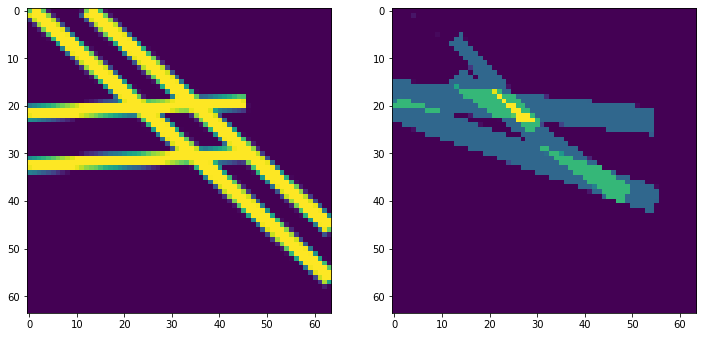

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7517.075866769402+2034.0471169603488j), end=(143.56670599751723-18.61587391602502j)) to Line(start=(-6480.404717035775+3790.5902401515277j), end=(81.29391411298562+2.191769116594486j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6319.835212449194+5201.774429926947j), end=(137.9365436645023-27.626028191611212j)) to Line(start=(47.503866330817694+45.60490999228269j), end=(151.21247130906468+173.67437138813662j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6144.672042682051-8683.334295170038j), end=(-44.01657763495981+155.02902228331607j)) to Line(start=(48.62518005234074+28.074743109237026j), end=(182.72396409818

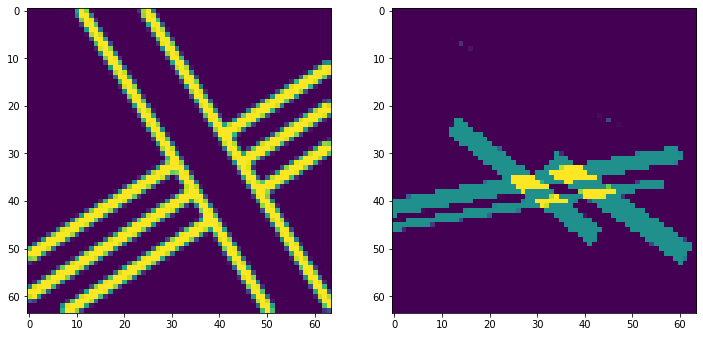

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(9679.209072306887+1393.6976568690754j), end=(-33.92662172580981+28.60545885212665j)) to Line(start=(8104.984935837091+3482.823646470005j), end=(-26.663426744072552+31.143702282233562j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6637.279228189768+8541.446242436028j), end=(117.40368975643011-104.15363650673018j)) to Line(start=(21.236228180704806+23.869700041828732j), end=(120.45487679907615+155.53729389901343j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4331.337202991316-6204.827720178875j), end=(90.63336025784857+110.40072559771878j)) to Line(start=(33.87580540066544+13.90040407396351j), end=(64.73451376472

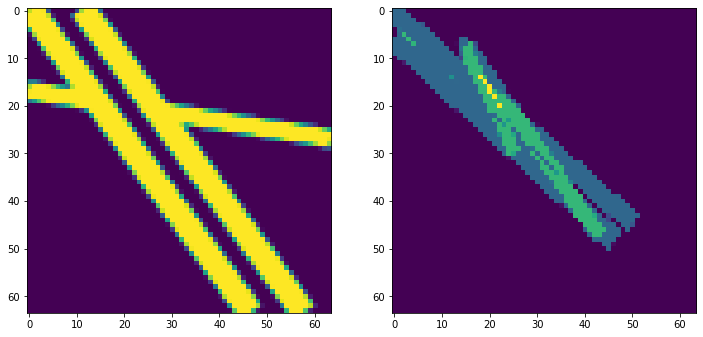

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(175.5092748916664-9097.96084434827j), end=(14.004917121112943+154.6176155274477j)) to Line(start=(24.135895649444763+17.92384593070284j), end=(111.49547025864292-66.43831464132099j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1216.3371661550032+9530.751192532342j), end=(43.34096083974834-22.536262254731838j)) to Line(start=(-22.32325538811295+119.68738589539018j), end=(44.00141635033374-36.563748932113384j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9197.484137532809-4043.363315545414j), end=(-93.36790524861155+93.19052485828777j)) to Line(start=(38.37481408556607+23.402788649962034j), end=(92.34300181735142-117.1891

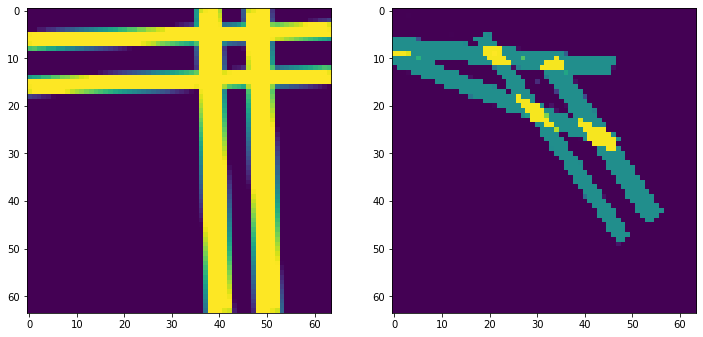

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7855.896979171549-2224.4564855088197j), end=(-110.69700967970661+59.927581008138255j)) to Line(start=(6.225453969457561+32.05809907698168j), end=(114.32807972534935+136.45159129661647j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7734.93339048709+6026.5528485333425j), end=(-72.9292167793437-73.61798026318368j)) to Line(start=(69.53146090228275+80.74655694468181j), end=(-2.052940354144198-14.24915205145713j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7741.359128068443+6018.32827948542j), end=(-66.50347919799034-81.84254931110551j)) to Line(start=(69.53146090228275+80.74655694468181j), end=(-2.052940354144198-14.249152

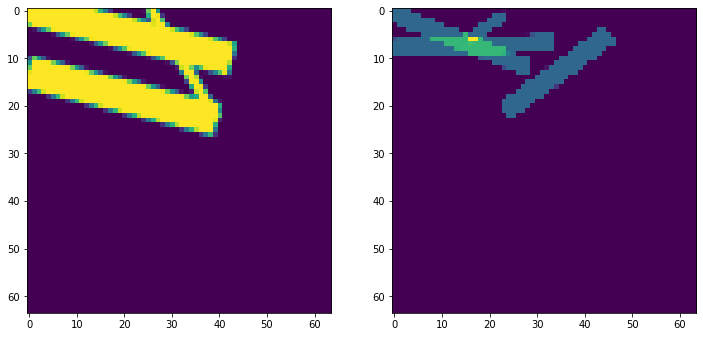

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2592.1771319942973+9503.029426101391j), end=(8.948355674236701-137.7116146990546j)) to Line(start=(40.866943816240706+8.049609685222869j), end=(-25.319606433763283+122.6880774959404j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7838.519370905401-7576.165680673851j), end=(150.8757776774916+139.1035318107434j)) to Line(start=(26.260084134749096+31.07635988787436j), end=(-122.0783686885299+33.66561721325603j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8546.14428307572+45.85844450259752j), end=(-95.52785652572898+45.85844450259843j)) to Line(start=(34.51795010605561+40.87812395311037j), end=(141.23264214485457-65.836568

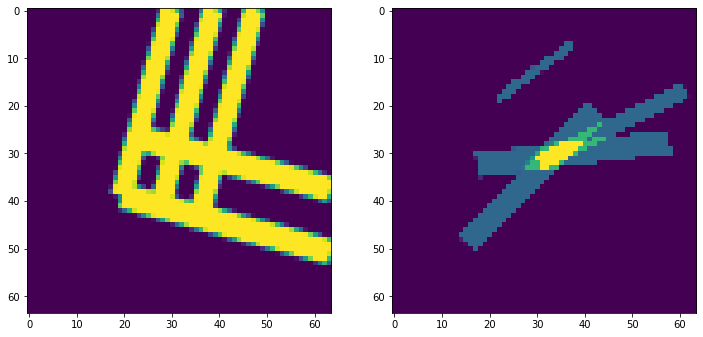

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(676.3020018437654+7551.810790952169j), end=(9.410137914747276-70.79809404250327j)) to Line(start=(11.138728203701785+46.77260706667111j), end=(-19.477403131808586+220.4053160967792j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4966.57174174593+6092.177112718974j), end=(-27.92567538356076-75.51354601588685j)) to Line(start=(40.74391486048057+19.871853552268448j), end=(22.80354866662589+190.5630359628158j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9160.041698709916+1140.2462380353863j), end=(-122.48969501046435+0.4946967900039567j)) to Line(start=(14.84912134864924+24.31978949400294j), end=(116.36765043764282+154.2575

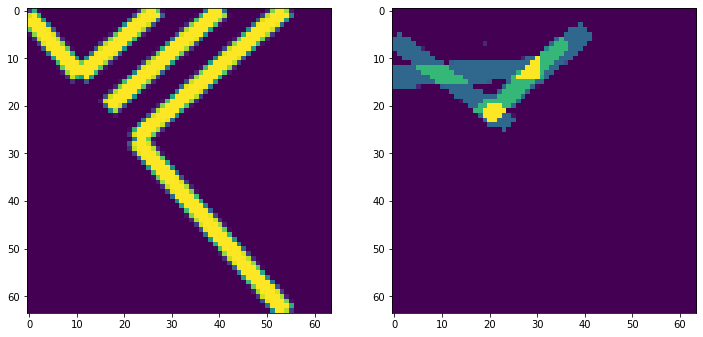

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8099.5059141719885-7828.013160860964j), end=(150.24434017890067+138.67805472749566j)) to Line(start=(16.894500408052014+22.22199252721114j), end=(-116.01235154638516-51.44947851122642j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-165.64433234158878+10749.209882988496j), end=(24.278366936579467-131.4542714677087j)) to Line(start=(21.404155502306647+33.20919132046617j), end=(-107.52129275211934+30.95878925028559j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8134.605096861988+5490.250800569236j), end=(-90.58260943254126-57.70835995404512j)) to Line(start=(27.137289229397183+21.694714295259708j), end=(-50.85346243899782

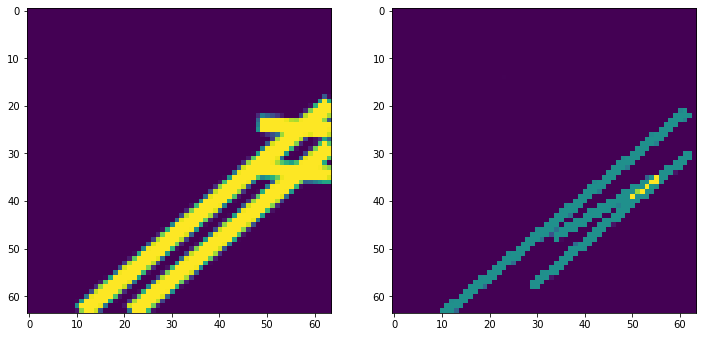

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4081.5964008040555-6945.845991237431j), end=(-14.607577849469564+148.98741795625864j)) to Line(start=(106.59302960196689+7.567228368778746j), end=(21.302764429709796+92.85749354103585j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4075.750963077621-6949.22085628232j), end=(-20.453015575904416+145.6125529113703j)) to Line(start=(106.59302960196689+7.567228368778746j), end=(21.302764429709796+92.85749354103585j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(45.46340992280088-31.19175899117006j), end=(-2138.499512124641+8119.468827936475j)) to Line(start=(3923.774209322413-6679.387228495456j), end=(15.422936244343788+90.075

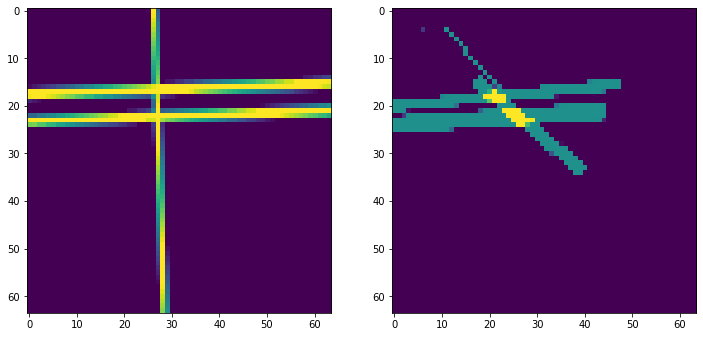

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2606.8408280438107-8084.550593005955j), end=(79.00859636446964+181.6439638270351j)) to Line(start=(32.335783665499946+57.71167776704581j), end=(-92.8263835076307-54.98484374872325j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3495.3468635896525-8092.260516342262j), end=(-16.210499759676814+180.4502058300838j)) to Line(start=(47.875848631362885+58.3911984206331j), end=(124.68298381785286-39.91745155403726j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3939.326845978634+9763.434176156772j), end=(-48.64717289163813-107.14788971478414j)) to Line(start=(17.975254425653418+36.925446227083924j), end=(141.63882705069307+89.41

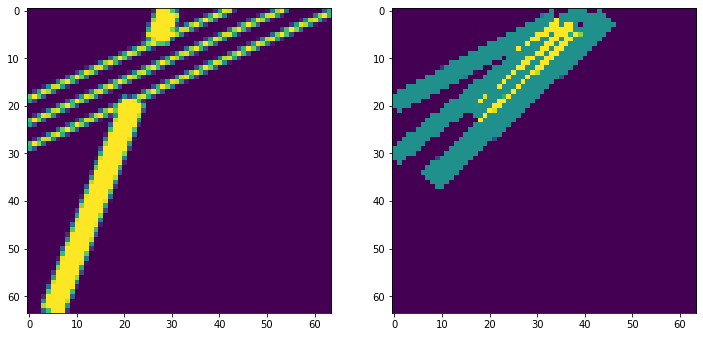

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-292.746471425758+9275.663754292886j), end=(34.7957510203653-103.91828852330214j)) to Line(start=(47.49457107913376+26.02336986821936j), end=(128.23317710542906+112.60492466182875j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-278.97230188461583+9276.144758892371j), end=(48.56992056150726-103.43728392381567j)) to Line(start=(47.49457107913376+26.02336986821936j), end=(128.23317710542906+112.60492466182875j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8250.976684365676-1721.0703403873806j), end=(-92.67556111963953+52.42769268333684j)) to Line(start=(29.007401987306867+26.563180431504165j), end=(-6.828463845747638-142.0

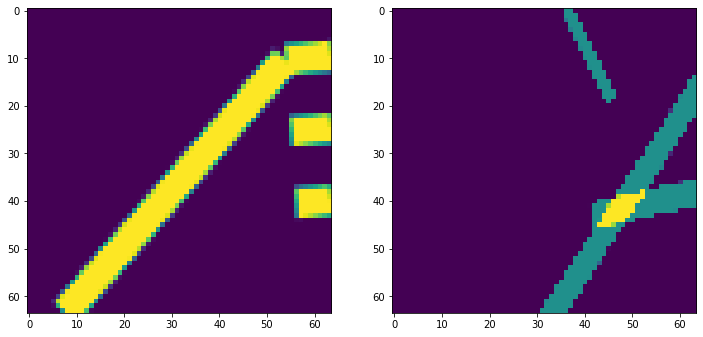

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7382.264432008021-6185.820419723698j), end=(131.72024391307679+119.16135051341432j)) to Line(start=(39.898631059523325+25.15722995450513j), end=(64.13640361878477-112.30200890886364j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7373.983774257903-6195.6889233464435j), end=(140.00090166319416+109.29284689066883j)) to Line(start=(39.898631059523325+25.15722995450513j), end=(64.13640361878477-112.30200890886364j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3487.5122455784026+6386.693621003036j), end=(100.51929386341149-86.28662357003489j)) to Line(start=(41.19455489016208+3.4786320478631794j), end=(-122.88108972839065+

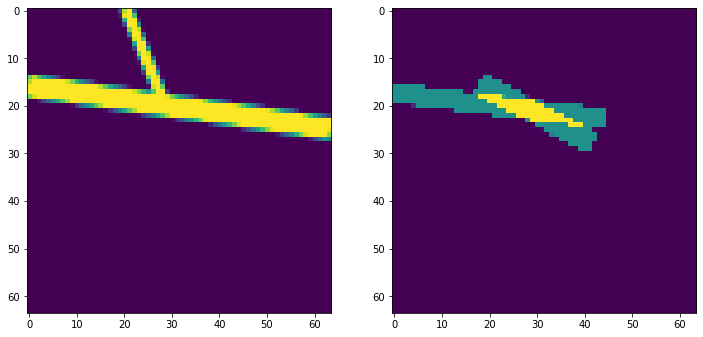

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(75.11635360707207-36.86827916764693j), end=(-8781.750749965238+6637.259797951469j)) to Line(start=(78.60622967992674+11.82750822995984j), end=(-36.814756243344846+58.46061355471205j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8801.081737365004-6596.7777478530315j), end=(-55.785366207306495+77.35032926608415j)) to Line(start=(82.50069189175005+21.466640451570242j), end=(-32.920294031521536+68.09974577632245j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8793.594908686066-6606.713105081777j), end=(-63.27219488624529+67.41497203733925j)) to Line(start=(82.50069189175005+21.466640451570242j), end=(-32.920294031521536+68.0

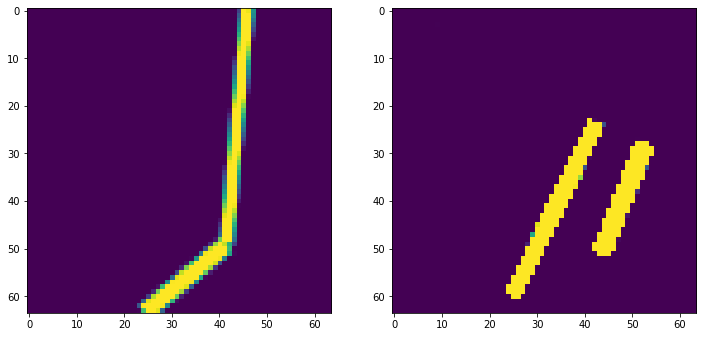

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-886.3011641002975+8598.99024545572j), end=(26.916800503257434-89.69829592588447j)) to Line(start=(25.04221208474314+36.02564107578445j), end=(118.0251175802463+150.84996667854858j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1578.1189353336836+7287.942897840638j), end=(11.607384339428272-81.91451181274194j)) to Line(start=(34.46952059570645+25.64338278554363j), end=(-125.90067581211139+59.73112032833552j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-4818.033716857264-8756.469997258817j), end=(92.81130479159785+102.92894053264278j)) to Line(start=(-7120.577305101925-7363.808065066616j), end=(93.05295399620017+106.1247

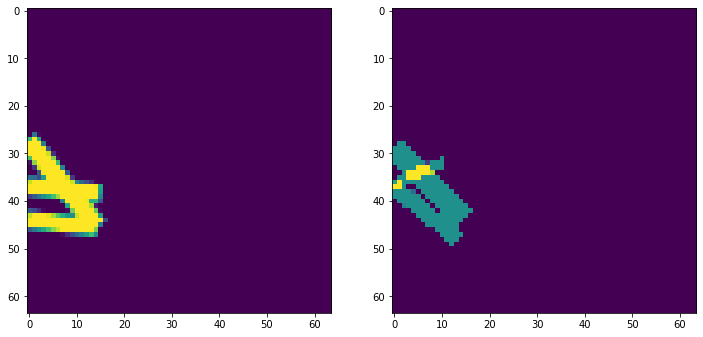

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7312.208756684645-1541.885237599624j), end=(148.55250880290666+43.94852443329361j)) to Line(start=(37.60027944160601+27.827247440149467j), end=(-59.238696422233424+90.71521368359728j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7617.560148594966+2223.4712495765034j), end=(168.55856222174464-9.162363720505148j)) to Line(start=(56.934395859623265+31.284439416421225j), end=(-30.056343861961793+188.2198881405474j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7615.908487520882+2229.2312762626j), end=(170.21022329583042-3.4023370344086388j)) to Line(start=(56.934395859623265+31.284439416421225j), end=(-30.056343861961793+

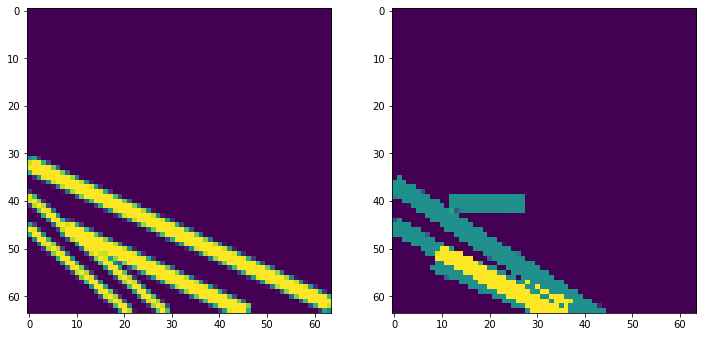

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8728.368171426104+3019.6000514925963j), end=(-86.0093855353229-15.43353532991808j)) to Line(start=(29.920252964572327+42.61900151296324j), end=(91.98454349225035+169.86965480675502j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8144.36218758171-8067.708979885685j), end=(-44.75886320119287+121.41207089722013j)) to Line(start=(35.001978471686144-19.46535735973533j), end=(-35.61930679495977+102.85429681791084j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9604.042075499447-3490.1239551649437j), end=(162.5414417709408+64.62173559638953j)) to Line(start=(14.689251779501813+19.266694880998276j), end=(-132.43536083614998+87.8

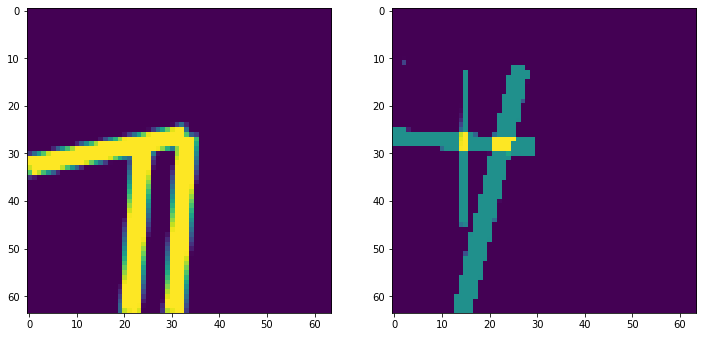

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8125.398042570381+608.0623102496844j), end=(169.37858486883087+28.035024909314163j)) to Line(start=(41.980055490469425+43.50857688003188j), end=(-107.20063098255338+94.87560660220184j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10663.164987303142+2321.2339376015793j), end=(221.01218993329496+7.730660200868911j)) to Line(start=(56.48156098668941+42.7027249791657j), end=(82.89515878633676+166.96893248704015j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5795.675011399967-5546.101493785239j), end=(-73.5465584269094+121.73989305212716j)) to Line(start=(6.2609567360382545+32.97217231079377j), end=(9.221306076418053-136.6

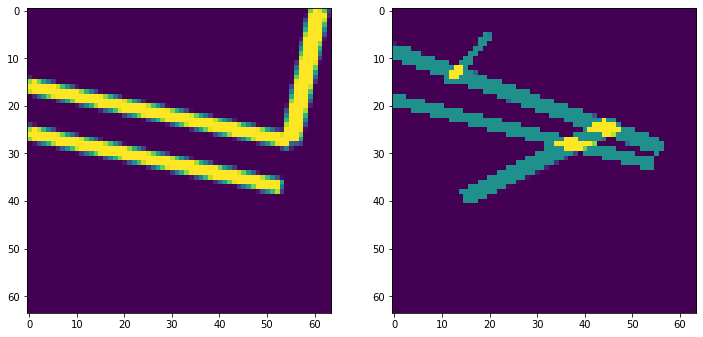

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(19.670804108694316+108.8182629757648j), end=(1496.7246663537937-10400.966066773672j)) to Line(start=(-14.905124379787416+80.3417020167629j), end=(33.254138007022334-33.11441021352982j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1456.3398721326923+10451.290285574885j), end=(20.7139901124073-58.494044174550936j)) to Line(start=(-41.507125414917674+69.04982251656827j), end=(6.652136971892077-44.40628971372445j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1445.3219818357588+10452.838749073875j), end=(31.731880409340647-56.94558067556055j)) to Line(start=(-41.507125414917674+69.04982251656827j), end=(6.652136971892077-4

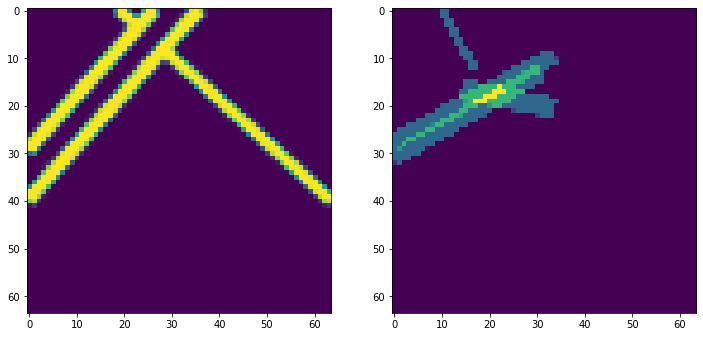

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4291.597217762999+8753.194951741021j), end=(-31.30909442643054-110.07646692834561j)) to Line(start=(37.16816345566364+15.086119555087535j), end=(193.19670217858393+25.996697840185753j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5947.289995456246-5147.959773257258j), end=(-86.14553704416267+96.82571861453027j)) to Line(start=(2.6094073686667985+19.67222252084121j), end=(90.72129644189047+121.03335601123982j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7728.100360367891+549.6030962460738j), end=(-110.28969269012799+1.4894690660033891j)) to Line(start=(9.085123336931531+6.4875695830202815j), end=(112.37659125810063-83.3

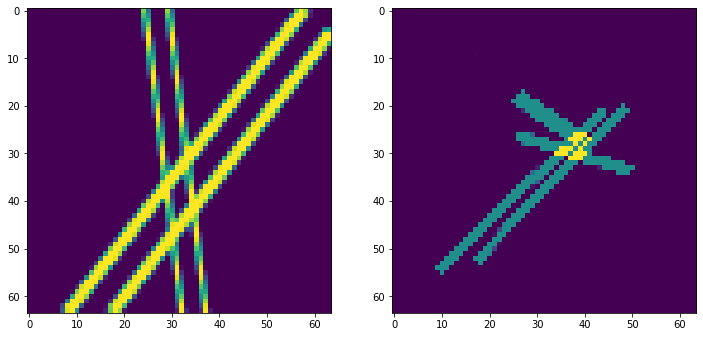

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5055.407814395905-6155.697482030554j), end=(-53.20130883301154+152.90939809385407j)) to Line(start=(23.051269190256143+58.74530631445367j), end=(-112.85956843477092-51.313119932452494j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6643.4279122196+8189.06856712049j), end=(-7.629607012181239-24.303451329900355j)) to Line(start=(127.95166708200433+73.97415364403362j), end=(-10.390957510341636-26.537646558185997j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-967.1741321312272-9373.991077747325j), end=(39.21079844814655+201.12193302233578j)) to Line(start=(16.045449408565503+60.699148870177424j), end=(-104.74668520996352-37

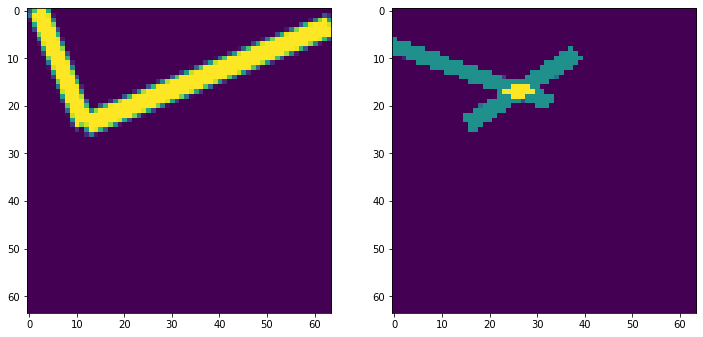

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6867.188532745263+2545.8407207062205j), end=(119.01310508055843+3.07127395583057j)) to Line(start=(17.81948292015423+46.51655004667141j), end=(-52.7778899281149+197.91310468957846j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6019.266526537772-5003.621892971482j), end=(-30.788271853162982+72.9768569606852j)) to Line(start=(88.62238518704021+24.613809416618544j), end=(-32.0235406689754+80.87192856847878j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6808.39053934333+9062.859820701413j), end=(119.50940109308847-130.77391995907075j)) to Line(start=(9.977939381438155+3.7474089879474715j), end=(-135.8179982028559+24.23769

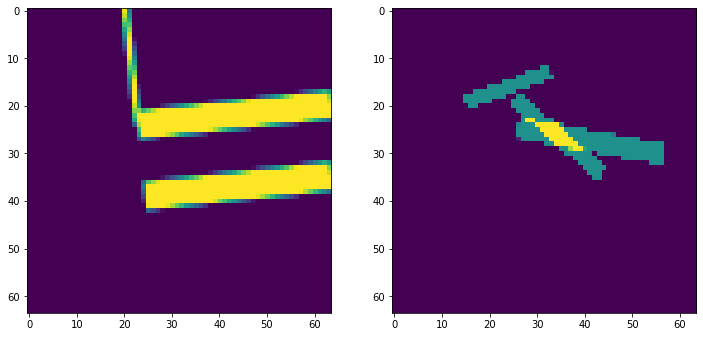

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10212.629828993468-1213.405791431827j), end=(-141.1956219121649+57.884120222939835j)) to Line(start=(19.43194797980114+46.209669904900565j), end=(190.47381087811374+70.2480360856814j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10213.535058125399-1206.0332917846865j), end=(-140.29039278023393+65.25661987008041j)) to Line(start=(19.43194797980114+46.209669904900565j), end=(190.47381087811374+70.2480360856814j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3092.961341036172+7392.624303804766j), end=(53.945409418917514-21.02340928160308j)) to Line(start=(-997.8433404411489+7470.142320739414j), end=(54.434416387702726-17.2

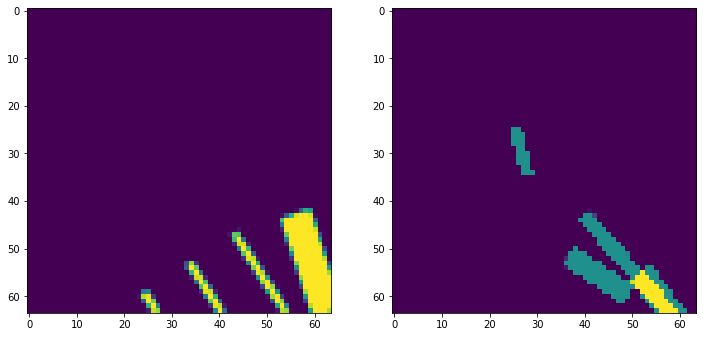

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4789.064952453546+6651.828457619702j), end=(97.70619549969325-74.23499990329947j)) to Line(start=(24.222239370403013+23.37833467594178j), end=(-119.71714903358775-31.874819757344007j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(61.94909665723892+87.94220363960238j), end=(-7746.7091508905305-7998.16012172686j)) to Line(start=(6980.307249126705+4199.685892498535j), end=(-41.9753389834969-19.727170379819178j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(7748.597059087075+8047.699180172215j), end=(-60.061188460694986-38.403145194248594j)) to Line(start=(6987.7470271980765+4187.304022501109j), end=(-34.5355609121246

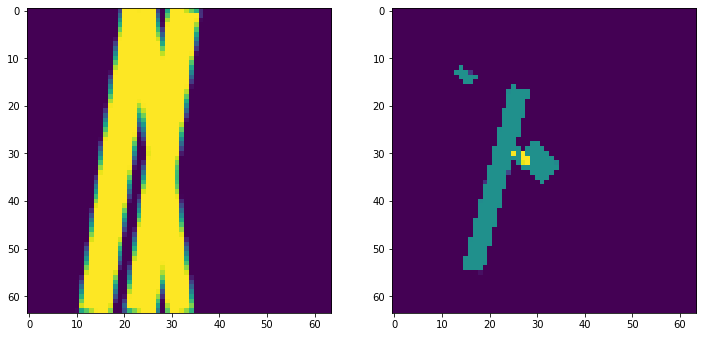

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-883.6655004573449-9036.07864377416j), end=(78.9968679701442+123.04197580999505j)) to Line(start=(-0.06825064367399847+14.577512214293918j), end=(73.53264814888365+115.88045864279881j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6991.89732806441+7861.637121251474j), end=(151.06484941989842-71.42606601418929j)) to Line(start=(47.623810832250484+47.223850381689886j), end=(142.5908574885168+193.46027824461925j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7228.941844328367-7428.928092230135j), end=(-106.6072381608173+167.2553509860102j)) to Line(start=(99.38895883320191+25.48837410303012j), end=(-55.264207861005985+118.4

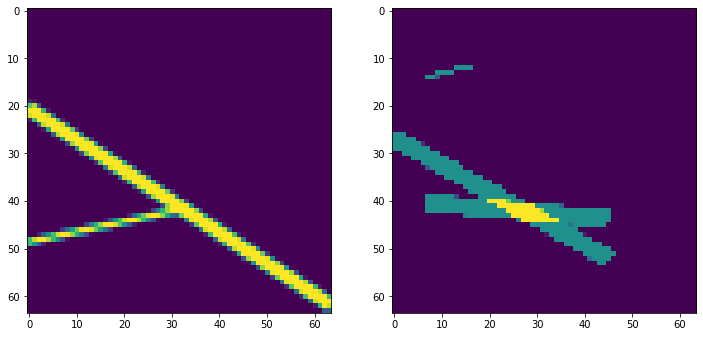

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3805.1870620589693+7893.468301471706j), end=(85.85967235179587-84.35976585526376j)) to Line(start=(35.76135160840012+36.60973860720427j), end=(87.26596766504841+186.190004809439j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7969.0777389255245-1822.137632332367j), end=(-116.54167661508784+44.57469626322907j)) to Line(start=(-0.6991479710385988+32.20326666114832j), end=(102.95551368371873+96.97388791173715j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7971.212219569955-1812.892180916896j), end=(-114.4071959706588+53.82014767869995j)) to Line(start=(-0.6991479710385988+32.20326666114832j), end=(102.95551368371873+96.973

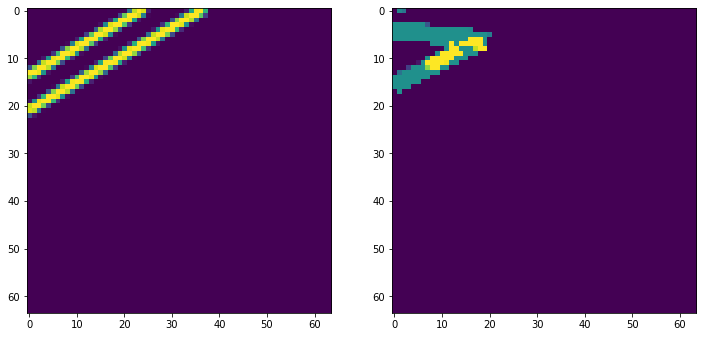

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1180.461668928675+11140.18809478546j), end=(-7.162531410860154-159.30138189955068j)) to Line(start=(10.81004747398907+11.696283793170329j), end=(158.38174454570117-3.814126574410029j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3737.9510649676954+6530.739982883122j), end=(53.007706208810546-35.39321819347627j)) to Line(start=(-39.709392422076974+51.301676981473435j), end=(58.78782035053287-47.19553579113645j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10840.997467341735+2359.3716334900346j), end=(206.4357928899745+11.167204416143377j)) to Line(start=(-38.452018429339645+24.310024501560694j), end=(103.82882272680378

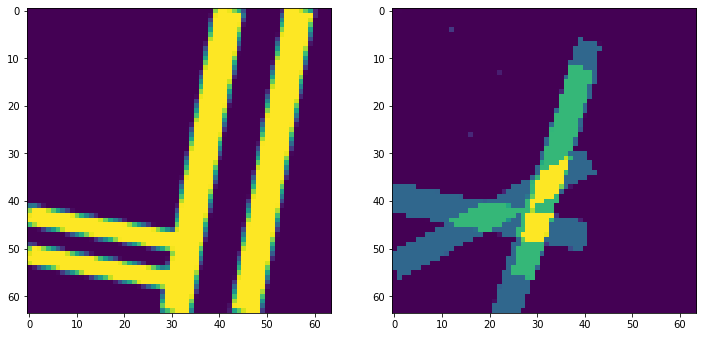

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-6737.197363623103+7021.8288230561375j), end=(77.13792662294597-34.62193832650716j)) to Line(start=(-3950.399546954025+7244.17818399805j), end=(76.11926036567829-19.854031905225924j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2279.791163689274+7667.875904883974j), end=(91.86975263939613-89.47741344615578j)) to Line(start=(49.855675818451274+22.40870614861487j), end=(-68.32184071587471+85.24480630024634j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8574.194905026508+2461.2561200475675j), end=(-117.02018945849089-30.909704933306834j)) to Line(start=(9.371974522655526+5.332664884357479j), end=(53.70870872232457-

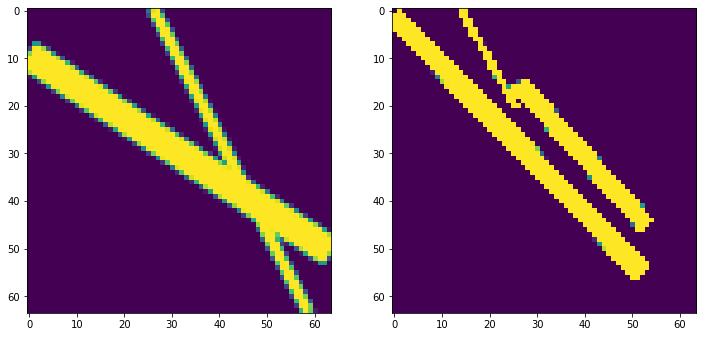

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9774.287565763974-2233.321157048869j), end=(-128.9606909387917+53.02385424348773j)) to Line(start=(73.25217041437423-31.433287057409483j), end=(-41.171388886012295+29.4067986268826j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(4589.252344637847+7099.520912854783j), end=(-17.04066208698398+6.451698735083767j)) to Line(start=(7720.157378561044+6950.42170932903j), end=(-15.126700123528877-14.459358911249637j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5338.9060574788455-5370.291208089335j), end=(136.97999098259862+105.59484037210328j)) to Line(start=(-21.886279816653534+8.193595179049467j), end=(93.4211510635811

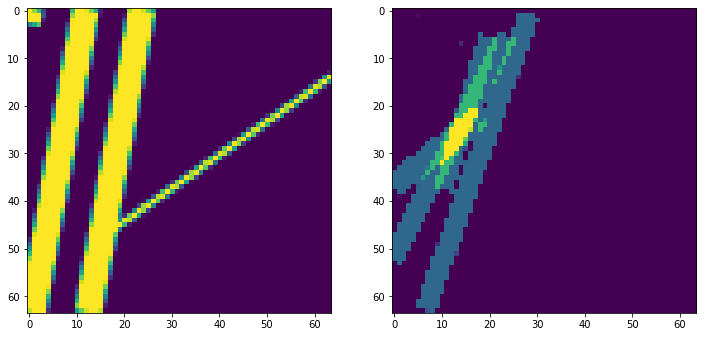

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7139.021517526908-4421.204203886019j), end=(-69.75624283995282+83.34008329279365j)) to Line(start=(132.14716427441954+16.21814216424942j), end=(-29.300326281684846+65.57759347175784j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7132.231058306191-4432.071210244977j), end=(-76.54670206066946+72.47307693383561j)) to Line(start=(132.14716427441954+16.21814216424942j), end=(-29.300326281684846+65.57759347175784j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4658.709442416212-8003.112045857468j), end=(-40.60053758190158+136.3316000147531j)) to Line(start=(26.85655654339043+12.599357251596857j), end=(-32.792272864851995-90.71

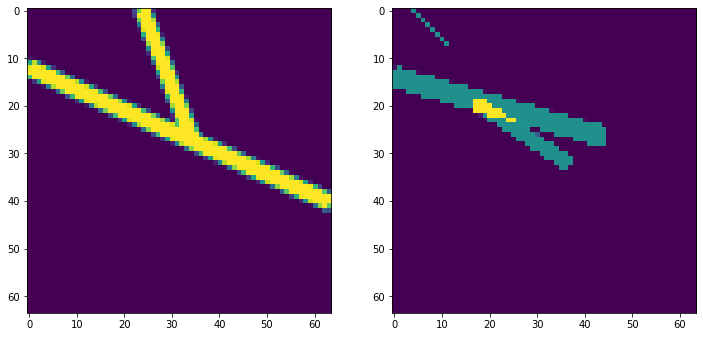

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8905.66497222289-4898.772959346086j), end=(-96.78991436399095+91.36926958423281j)) to Line(start=(39.50280588908087+28.640521079847698j), end=(193.72702247726036+72.86360355877517j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(214.22417992869703-9789.97146943349j), end=(41.55697102714554+102.12630342686606j)) to Line(start=(76.03539617654312-31.23869122487613j), end=(42.15947266118042+86.90069374104966j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(208.07421337042027-9790.078817499072j), end=(35.40700446886879+102.01895536128497j)) to Line(start=(76.03539617654312-31.23869122487613j), end=(42.15947266118042+86.900693741

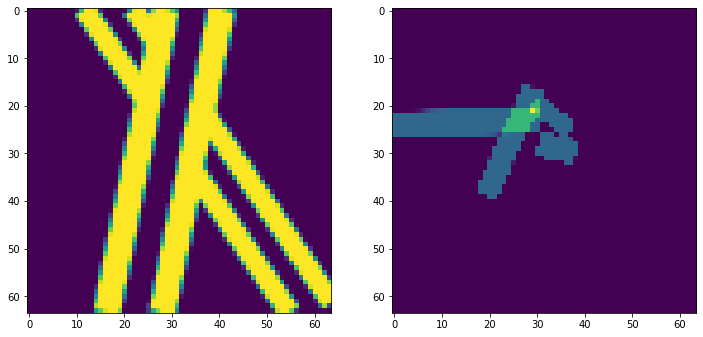

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3281.6132135078733+7353.898825678075j), end=(-37.52600983023119-101.00992764717101j)) to Line(start=(3.399310539289356+14.323577533207489j), end=(-12.965739579286378+170.02662867295544j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1417.2528634488378-8138.459066510814j), end=(49.01854101545543+177.17929225285172j)) to Line(start=(21.201658661234053+54.254496365933086j), end=(-112.64692015247168-39.46728749808013j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7683.032626003699+703.4030042820241j), end=(131.9787916032796+19.67809991575146j)) to Line(start=(23.29883455552114+14.356531846470574j), end=(-70.24956296773583-

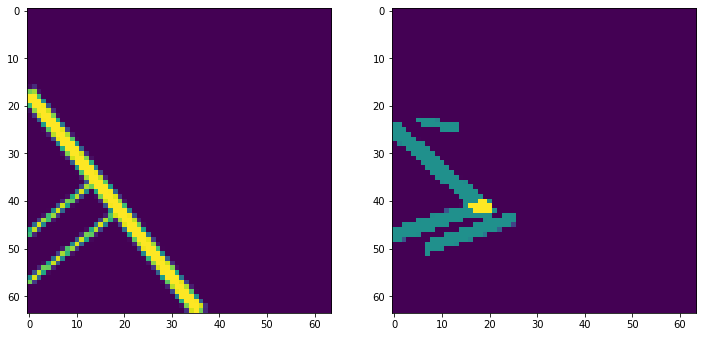

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6645.653654005293-4105.659617510951j), end=(-58.83386678037063+83.76915448655998j)) to Line(start=(35.44437639097606+15.88997572588089j), end=(70.6104562206151-136.43105064935136j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1614.8390775591704+10324.57381593823j), end=(38.40780504840554-113.6161932571601j)) to Line(start=(4.130627523022998+37.85671194480669j), end=(-120.23763622771891+128.2155446939082j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8631.137422625827+6524.136105288282j), end=(-120.60394433138853-70.77404723448709j)) to Line(start=(108.5318479103039+38.30762812447393j), end=(-45.003891322793095-23.72483

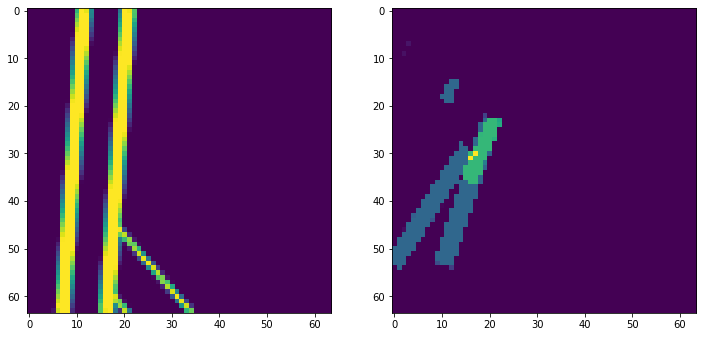

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4733.810299621491-6945.473912366625j), end=(-34.13503764615539+123.29574466870334j)) to Line(start=(30.781523544042425+14.708884554746636j), end=(-1.5407937035518877-151.5750224468305j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4729.236907455366-6948.558704333536j), end=(-38.70842981228026+120.21095270179167j)) to Line(start=(30.781523544042425+14.708884554746636j), end=(-1.5407937035518877-151.5750224468305j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4252.3984292296645+9085.129005364653j), end=(-39.167486772403166-118.16380132473108j)) to Line(start=(21.42791164068546+98.32727387485122j), end=(-2.3706385520333555

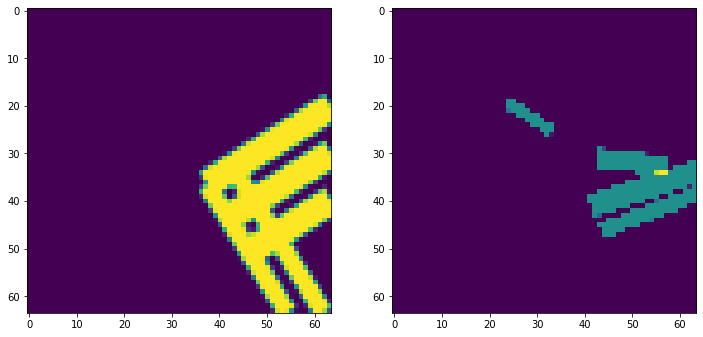

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6662.953190078136-3992.499271088792j), end=(145.94906566769018+98.70195319679578j)) to Line(start=(47.50472799206682+37.05505735848298j), end=(89.81047504158124-110.48261595947339j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4256.208587474823-7631.83522646733j), end=(-23.913651512657623+89.7096910653325j)) to Line(start=(9.172295519764525-43.79931826673515j), end=(-25.144455835614508+93.83765377030915j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8051.117197716788+4094.0922259299646j), end=(-92.94965967836224-55.517100296978896j)) to Line(start=(21.963447135796827+13.32938443803901j), end=(75.04653155644972+176.7023

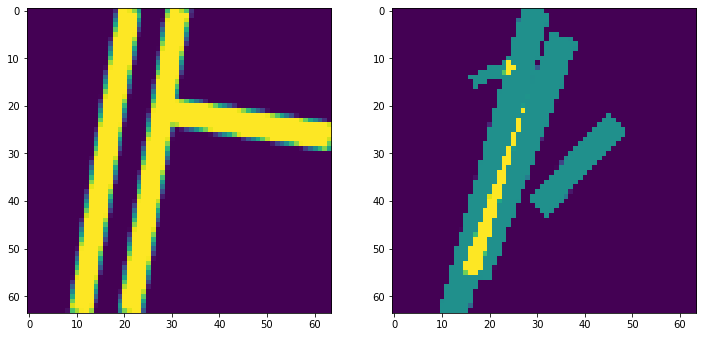

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(93.64801628213452-23.111625333112716j), end=(-6754.5552191639035+2883.7781843988646j)) to Line(start=(132.34126756013143+8.60423941729356j), end=(-34.452682646524465+32.045600402646144j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6834.8480761743285-2884.5812817880283j), end=(-13.355159271709823+22.308527943949432j)) to Line(start=(132.34126756013143+8.60423941729356j), end=(-34.452682646524465+32.045600402646144j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4549.044200078932+9248.285073638177j), end=(-25.231061409108207-130.3690674318821j)) to Line(start=(35.01074823673373+82.37464003198089j), end=(12.600815475807654

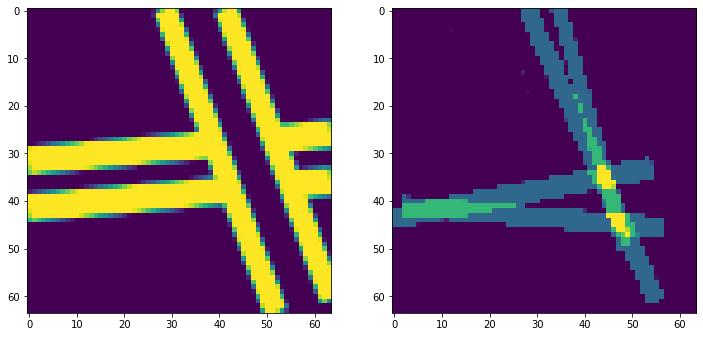

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(4962.598861691255+8510.256982084646j), end=(-18.349463089335664-116.99858631041221j)) to Line(start=(2184.27929818131+8047.124251878045j), end=(19.486793931127558-31.991361827874428j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-39.290875354751456+66.11927269997496j), end=(7672.3156656668225-3049.572013194683j)) to Line(start=(-46.977813169255185+31.19833536714217j), end=(74.32350563397318+16.304406200944452j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7634.045166430174+3124.1146003800886j), end=(77.56137459140035+8.423314485431106j)) to Line(start=(-47.86641830438301+23.961227308984025j), end=(73.43490049884

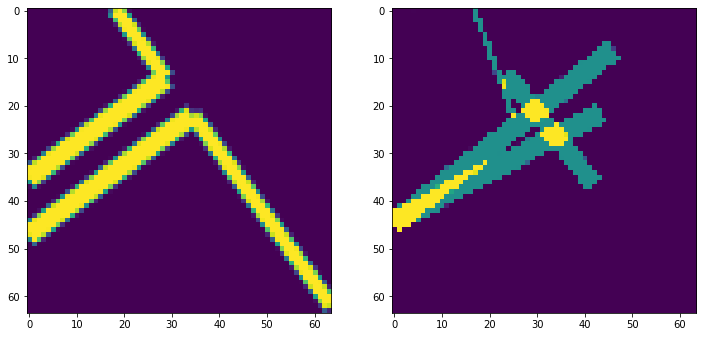

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9232.895184606587+35.608324791846734j), end=(-115.24422536049559+35.6083247918481j)) to Line(start=(27.62941207341734+33.765976499939875j), end=(97.5774180149972-87.38752367900639j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4355.564935807811+9026.161528533465j), end=(90.4784768476174-89.5783602622831j)) to Line(start=(36.41241075242399+47.5512725477028j), end=(76.10422709583582+162.82467732695042j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5594.193755829115+9793.67721994059j), end=(144.5095216460837-146.04842620848953j)) to Line(start=(69.70697855057958+5.276803826803828j), end=(100.2811475944801+119.38115609784

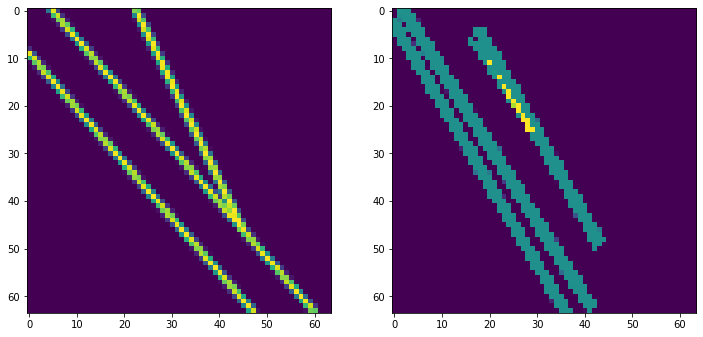

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9796.474575722952-2791.3603657350186j), end=(200.31824276164252+75.17384735222699j)) to Line(start=(50.74743497914264+42.34342717765848j), end=(-94.04928575627125+122.60556010197726j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9798.883207792318-2782.9604674664124j), end=(197.90961069227626+83.57374562083342j)) to Line(start=(50.74743497914264+42.34342717765848j), end=(-94.04928575627125+122.60556010197726j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(2347.5573191143612+10055.63871989866j), end=(13.8170471143953-52.90096511452042j)) to Line(start=(-367.67349656610406+10788.148338729148j), end=(11.018505559106764-56.

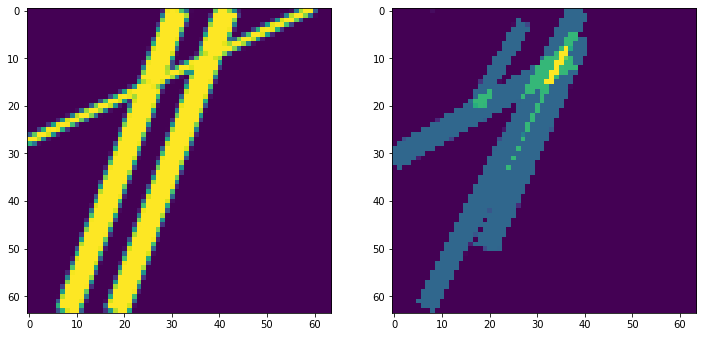

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7834.595234390331+1993.0121982115497j), end=(104.47083522320429+13.580710634745234j)) to Line(start=(-15.258406317320196+2.263660567553245j), end=(101.05167285867934+4.293860551376394j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7832.067825974205+2003.149079698209j), end=(106.99824363933114+23.717592121404845j)) to Line(start=(-15.258406317320196+2.263660567553245j), end=(101.05167285867934+4.293860551376394j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6824.874575754566+2916.113418337503j), end=(71.91728441772018-11.401038945026166j)) to Line(start=(-19.995256264357458+73.07665186091751j), end=(81.41627209485421-

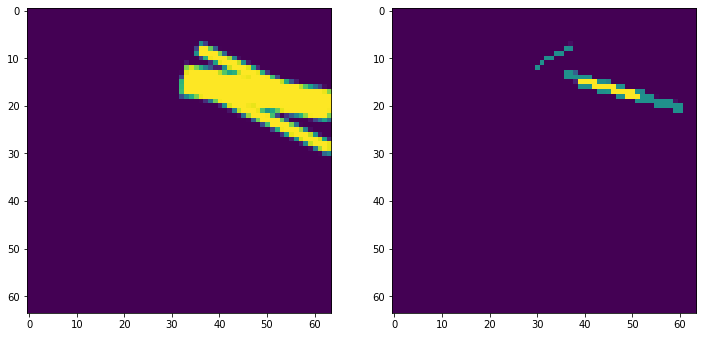

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7991.573171660721-3542.17594822375j), end=(183.26143677904082+97.49491710660742j)) to Line(start=(60.11447108710445+52.56893747601656j), end=(-93.68951821475397+111.60875741397186j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7778.602723304121-664.3011367423684j), end=(-77.42879236531704+23.012561181089954j)) to Line(start=(27.27683957916894+33.778311965291294j), end=(144.90512887958292+132.48016613328303j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7780.00944908756-648.2221874620228j), end=(-76.02206658187846+39.09151046143582j)) to Line(start=(27.27683957916894+33.778311965291294j), end=(144.90512887958292+132.480

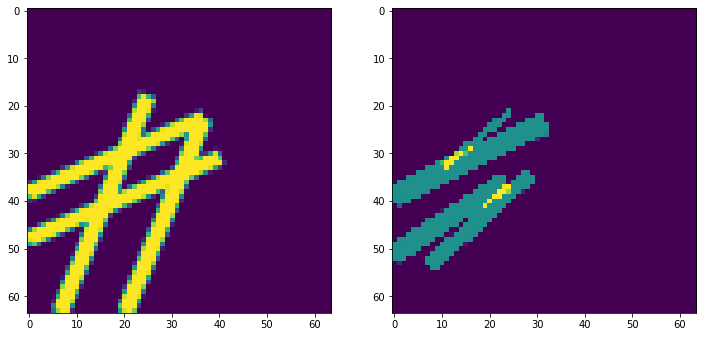

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3804.385812444652+8473.481656106385j), end=(-6.39937651395919-85.6820157441642j)) to Line(start=(39.36906187980501+124.36930737675088j), end=(17.32177821914565-14.83176323020733j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3814.098831919623+8469.157141215168j), end=(3.313642961012178-90.00653063538192j)) to Line(start=(39.36906187980501+124.36930737675088j), end=(17.32177821914565-14.83176323020733j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7205.578358355167+4394.937100467258j), end=(147.14606729834762-23.025449469981076j)) to Line(start=(37.43897844406442+40.64196539860514j), end=(-46.245395019814524-40.17109468

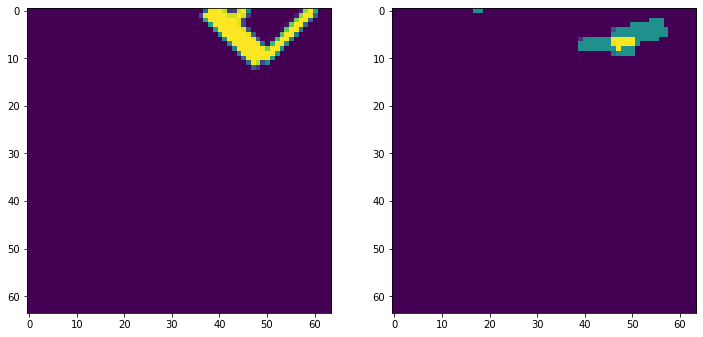

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-829.6849525354511+8185.351861244306j), end=(41.02963855370167-98.9440939873202j)) to Line(start=(31.617665492063495+27.102652486007646j), end=(141.47457456583555+162.7646371269383j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(10429.849692053242-4798.052047020424j), end=(-61.63826647912187+94.20913348416966j)) to Line(start=(8671.42154316074-7234.8246962898775j), end=(-61.35742373956607+92.84691398888381j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2950.5828662118565+8992.524166294259j), end=(-13.981445149209392-131.46660967898427j)) to Line(start=(36.53804360526424+2.8563709227382503j), end=(144.6100637140526

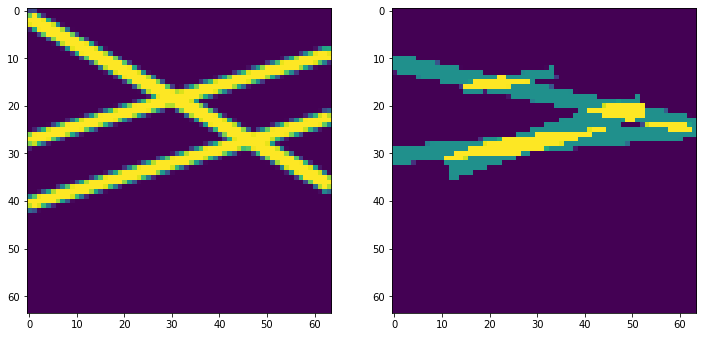

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9992.436302647899+3475.2778970131235j), end=(-147.41922411401418-16.15435561882328j)) to Line(start=(0.22838446334246854+40.49617696583607j), end=(28.8278544194849+187.62769498333077j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1812.1253903395661-7276.421352701136j), end=(43.25667235934422+165.1096487960622j)) to Line(start=(5.9189875700899055+62.728033691036416j), end=(-145.1415338342576-28.038284710605836j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1598.721965105411-9895.34052882587j), end=(0.15585773320968954+197.60865290363188j)) to Line(start=(29.893404075999825+46.45783232098154j), end=(172.17371728786603-56

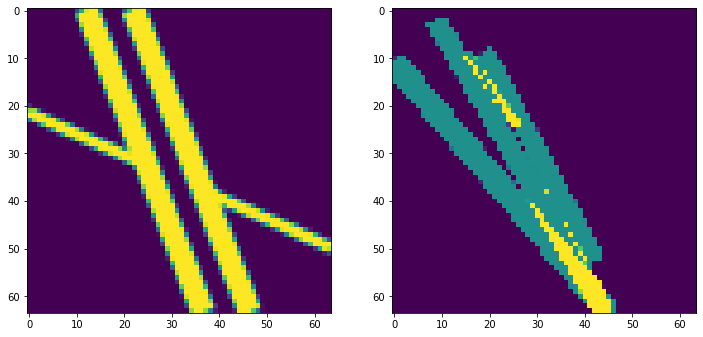

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7456.937989034273-373.6520011343549j), end=(-69.38044816162936+20.785634336091288j)) to Line(start=(36.99521499531244+8.904110355448513j), end=(96.50250709887062-107.88552628115853j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7865.026477465497-4188.148118878896j), end=(121.0544587695278+58.126436929195265j)) to Line(start=(-8149.7731994025635-1841.8202301655945j), end=(114.21164385849649+66.0710020871559j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5415.172731551518-6168.557769448293j), end=(-58.18139423362901+127.81589838771427j)) to Line(start=(28.462140195271804+45.4857874716248j), end=(180.79794053808715

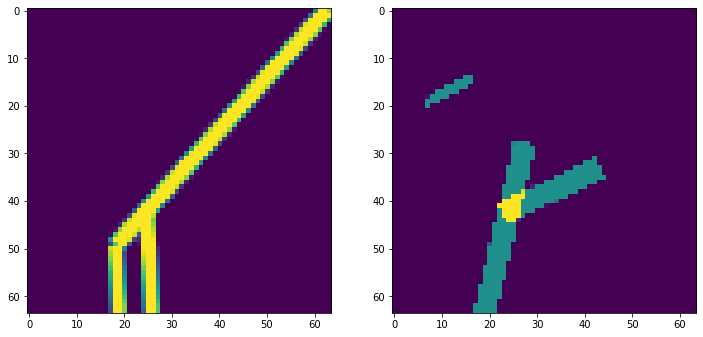

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9624.25346894991-1998.1796953601836j), end=(178.7840002388141+85.52024301296727j)) to Line(start=(31.3828748322166+61.84950811301049j), end=(-71.89769230676723+128.9206926428119j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1580.7254998793942+8936.630852430266j), end=(-16.40064166216983-121.12159773058764j)) to Line(start=(13.47787437601637+13.374411734426342j), end=(115.76167789087997+84.99430199229464j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5407.419258253222-9645.959112812849j), end=(-31.072345901132564+165.3394577242959j)) to Line(start=(57.00182228794637+22.841009877842076j), end=(178.814387365806-12.088181

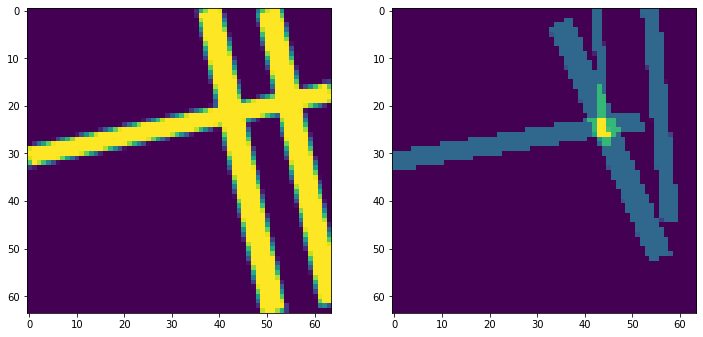

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6713.648168297207-4912.389468041664j), end=(162.818676494456+83.65613711831597j)) to Line(start=(-30.905064712039206+2.3602809455738463j), end=(114.33526013443733+58.112818090996896j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8301.283072483637+601.7542359454762j), end=(179.65780098778473+8.709078382206203j)) to Line(start=(54.96670973645388+29.574387634790554j), end=(-51.09080872015949+101.11108710894923j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7680.8841203796255+2227.00549589207j), end=(-87.02091370563694-0.40542964449301877j)) to Line(start=(25.742823190841712+25.482178647097655j), end=(130.35860983754174-7

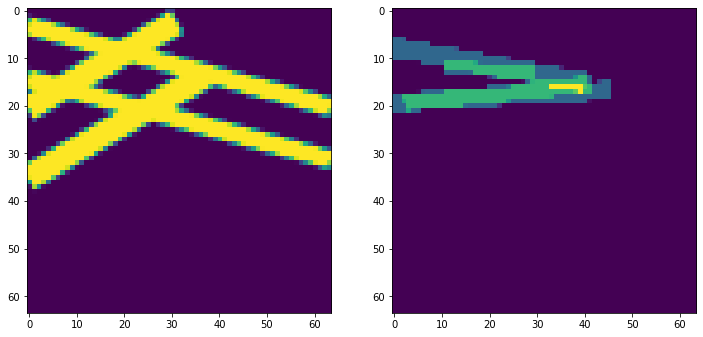

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5495.998750876823+5305.554659384668j), end=(-38.3330596327568-38.88744608214402j)) to Line(start=(47.9614247711385+34.3387704488366j), end=(223.96823328685133+31.266560178386463j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5500.9617926043375+5300.415279227219j), end=(-33.370017905241454-44.02682623959367j)) to Line(start=(47.9614247711385+34.3387704488366j), end=(223.96823328685133+31.266560178386463j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7158.87453340421-4132.648525458369j), end=(149.35293259135057+86.75856933317623j)) to Line(start=(-8739.48675107203-2304.8459755050685j), end=(94.64001955983935+62.251158519

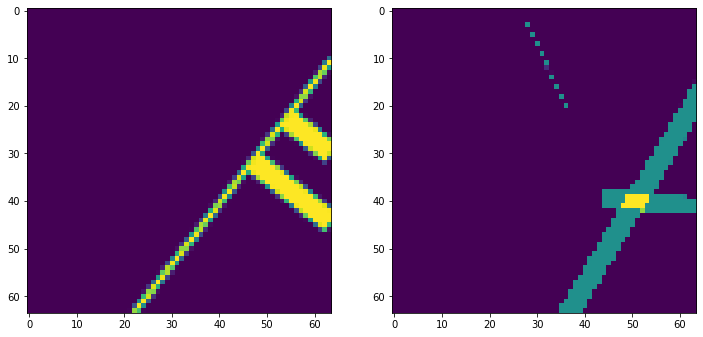

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1476.0188861314932-8531.017025636562j), end=(60.855247021462574+185.02930475452058j)) to Line(start=(73.43324013432363+48.87574796988797j), end=(58.68628948648733+217.43416518089737j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5481.997282023936+9579.573244415798j), end=(110.10613437185509-106.23399396121101j)) to Line(start=(31.498953583958524+42.75698108710614j), end=(77.57410099474492+214.71177219038663j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-10064.628116324546-1399.6773350436772j), end=(211.81368072938784+44.58237288482553j)) to Line(start=(-8338.75277576687+1071.5465253631007j), end=(118.51598778996981+3

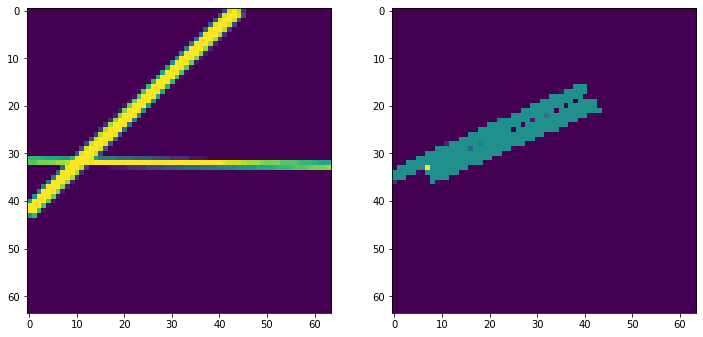

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9678.536205842767+2798.5701078335796j), end=(-103.30437431356634-6.32754275450786j)) to Line(start=(38.33785337491962+30.769926110564136j), end=(106.54923570659388-82.752877966808j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10657.52246021364-3841.3227607737117j), end=(-140.29710474451053+88.76215584829117j)) to Line(start=(21.130672453118773+23.95605723295547j), end=(79.40211276773208-101.00744978979269j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1817.5274109903621+10429.876330441926j), end=(33.08984408134471-65.495663317099j)) to Line(start=(-41.52153219350596+75.50938470790402j), end=(25.17026555269831-67.51163

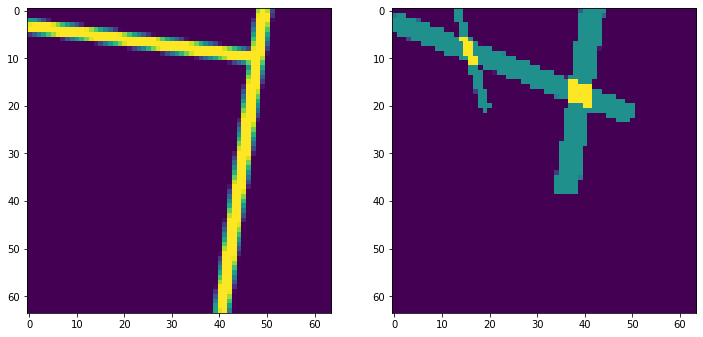

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8264.960850996655-4541.9442108939775j), end=(-96.69823156637555+92.99910373296746j)) to Line(start=(30.689909467218083+31.956787974259136j), end=(154.87819634381611+67.56720620141473j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-6439.74104627901-9211.328258420803j), end=(118.03710292244794+154.14953401825187j)) to Line(start=(-5952.91611052018-4977.618999312297j), end=(49.95508371762537+59.38800577736414j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2083.8488826727244-7938.295905532605j), end=(82.18326906159349+145.446135567609j)) to Line(start=(74.07063508307125-67.43967688938069j), end=(74.07063508307131+10

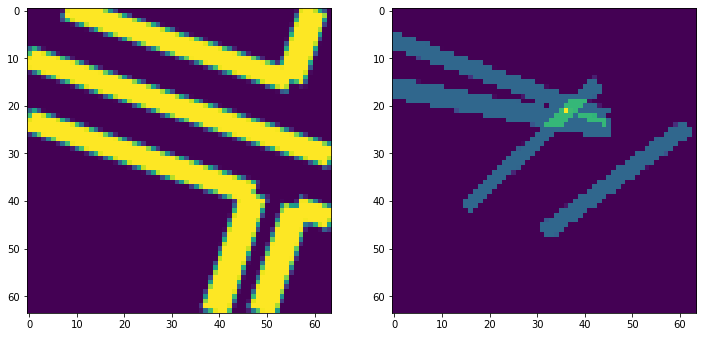

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8122.576448299424-1670.002301373389j), end=(-39.2207185177255+64.84124145339189j)) to Line(start=(-63.706591653978606+73.00126726194713j), end=(93.9819027362034-7.345033722310106j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-263.0943662981035-8167.607221695454j), end=(28.511075150323915+182.8800582981047j)) to Line(start=(21.24807929992983+55.306232928547274j), end=(-97.92673670553245-55.82608088422633j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6071.505163049041+4412.737337774364j), end=(-41.71485926165446-28.776991488235332j)) to Line(start=(52.07720355291445+29.717820825756128j), end=(175.72992631296188+10.13315

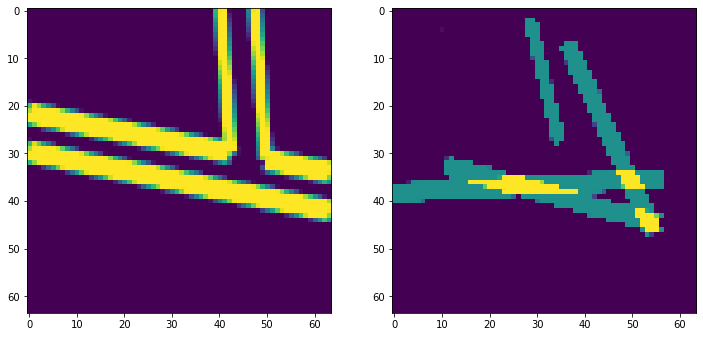

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9319.607178220882+503.7246023425246j), end=(-92.69719877859625+10.446632007931637j)) to Line(start=(43.77590480099626+17.598884298402567j), end=(34.399831022453995+196.50502966099177j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8244.288662907742+7714.607968192793j), end=(-45.84803142465296-16.069565415568405j)) to Line(start=(86.48461412191133+57.732245049331716j), end=(-24.709667265972612-1.3908031114265569j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9811.305524094309-1705.250180259308j), end=(-50.571858233963155+33.66488268373498j)) to Line(start=(95.83951170528329+49.912431728843735j), end=(-47.017992325764624+3

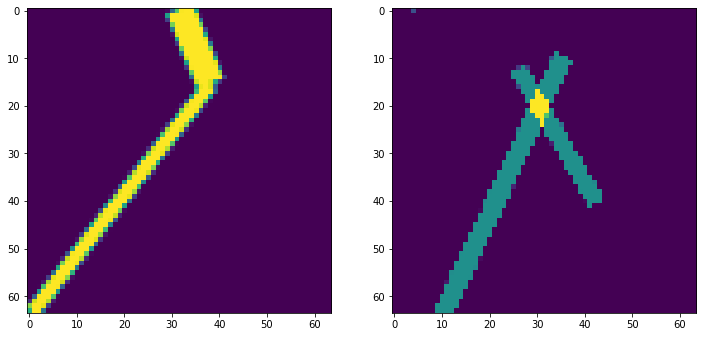

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8985.095460904675-4708.751643677401j), end=(-116.74137920215863+130.78084965131265j)) to Line(start=(7.586936077837358+49.69427906615867j), end=(45.91432883287316-75.66897388632027j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(4461.053096338805+6588.039556562986j), end=(-44.48913214083009-91.7014933668363j)) to Line(start=(2502.541953340944+7318.658924285795j), end=(-27.980943818943732-30.513199853688562j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(2243.770600058181+8276.91735471247j), end=(12.344725432899565-50.8773827128763j)) to Line(start=(80.32366841214552+61.16806181738315j), end=(-4141.294024068646-7250

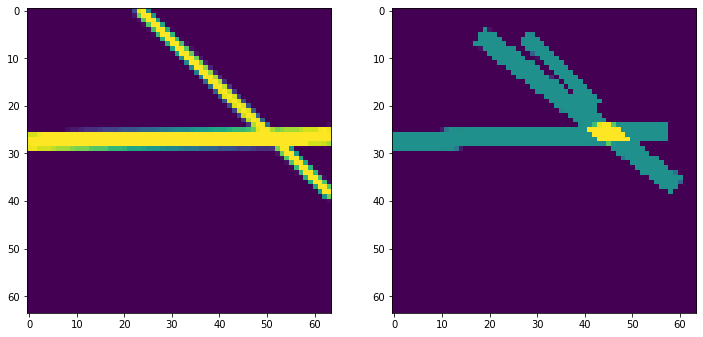

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4338.1420764537415-6195.202324077602j), end=(66.70089997066876+95.565392714918j)) to Line(start=(-41.44137273851479+20.771707813658086j), end=(70.34847219682247+114.5745254682647j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(8678.901088145354-1795.7958401436929j), end=(-41.299679042838235+57.740052002117494j)) to Line(start=(8894.485969514837+536.3823811560297j), end=(-41.65424715571987+68.05911703844966j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7519.9921066101415-3958.364178836677j), end=(-85.42325190488675+85.50689898882933j)) to Line(start=(21.277278681578775+28.773220512721526j), end=(-60.9781765911949

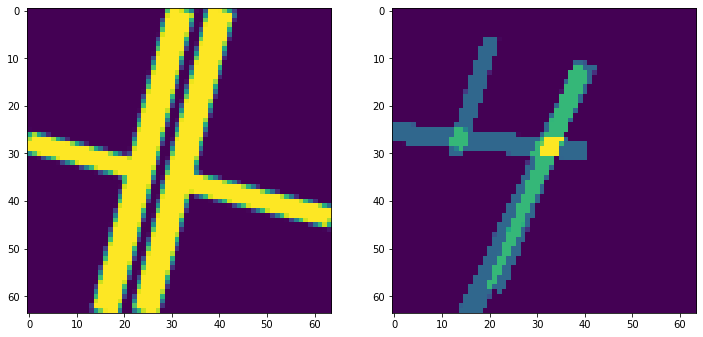

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(2842.83352133278-10405.910667401278j), end=(7.027908373945124+177.4599605501038j)) to Line(start=(24.800855560424306-9400.54944171079j), end=(24.80085556042499+83.70121367176448j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9388.436807878406-5158.21275274135j), end=(-109.3698591703191+106.50745175221427j)) to Line(start=(35.24046008304749+37.47364739365104j), end=(152.05042220639805+70.96836504318294j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-5877.2179815188865-8416.246784504845j), end=(118.85188015846022+147.02843673612247j)) to Line(start=(-6886.301532843123-5746.429901901791j), end=(57.185812016802075+79

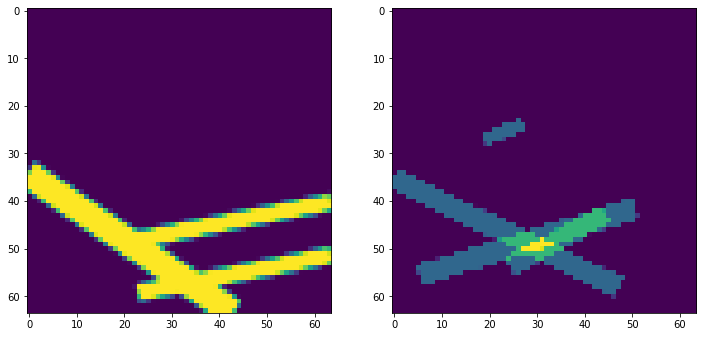

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10133.264489712577+2021.0712524759945j), end=(201.23385318338052+12.248269800631249j)) to Line(start=(47.84814991342139+39.689965817438406j), end=(-26.09686989041905-111.91979235203263j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6270.880068975775-6287.476480837018j), end=(140.9222278694565+124.3258160081979j)) to Line(start=(56.47684821331071+28.358665828270354j), end=(91.5851051697953-102.66713289851384j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2977.4200873045784+9310.557124417119j), end=(79.31044641709465-97.09211679900558j)) to Line(start=(46.2736719083869+36.64427711550994j), end=(129.5097500826614+129.08

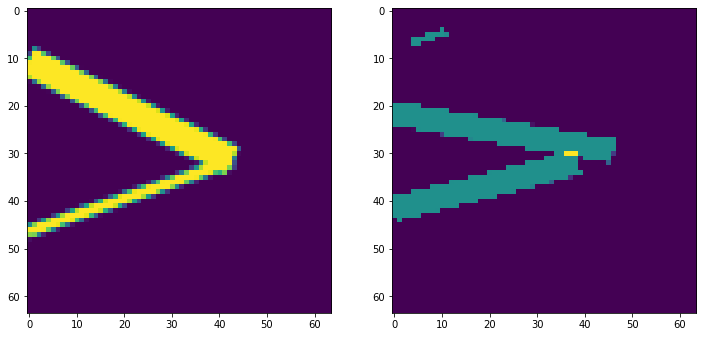

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-32.506836567631424+9.498209136557996j), end=(8766.226903538809-2348.1153909414334j)) to Line(start=(-33.725114649184576+59.031900325872805j), end=(118.98325034396052-29.134315310427063j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8687.36456491447+2354.143536335105j), end=(111.36917519196953-3.4700637428864383j)) to Line(start=(-20.80567692951025+81.40902286157055j), end=(131.90268806363486-6.757192774729319j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8690.562463449689+2342.208816524218j), end=(108.17127665675062-15.40478355377353j)) to Line(start=(-20.80567692951025+81.40902286157055j), end=(131.90268806363486-6

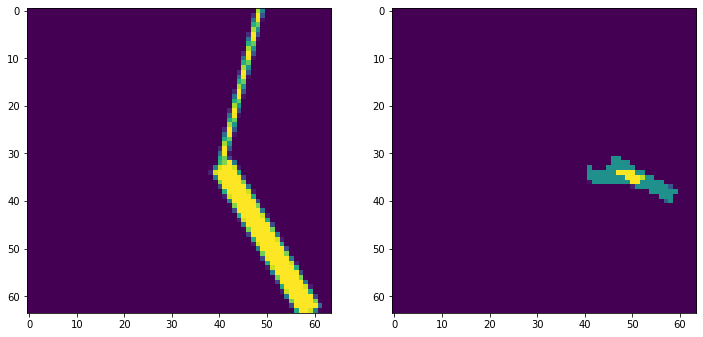

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(6040.9571576606295+4393.72146084039j), end=(-9.493831172794671-2.1884961591807865j)) to Line(start=(5244.506123797534+6487.3027997072695j), end=(-14.500653664180291-7.029715978759143j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7067.953440696707+3798.832368808692j), end=(148.3330291947272-38.13520880370146j)) to Line(start=(42.08231995529771+25.88141417466081j), end=(-37.63573550303878+153.45697091264645j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8824.944972176512+4333.669830619867j), end=(-29.81626976772307+14.914208953743398j)) to Line(start=(113.96116680794043+42.28810634109967j), end=(-20.3648298752594

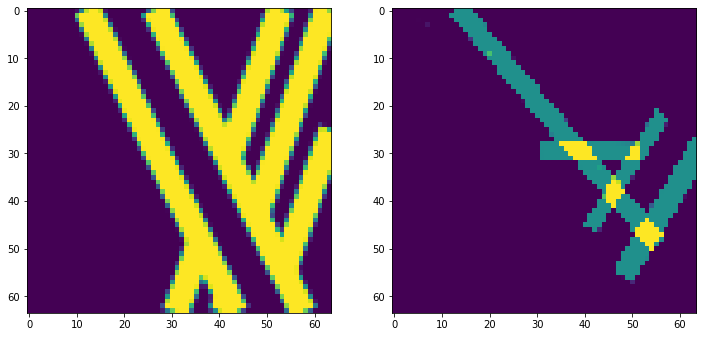

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1019.4567985249205+9491.574890250362j), end=(8.240085535408927-129.50945933277606j)) to Line(start=(17.180937426261416+11.378816753186417j), end=(-90.66332375941855+89.73225890590076j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4977.255391468786-5516.287284870854j), end=(94.76129550464849+116.757923104341j)) to Line(start=(1.4014917279855723+50.46838271662075j), end=(-138.89961005587253-40.64421811579342j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4984.799889363677-5509.494188454098j), end=(87.21679760975748+123.5510195210974j)) to Line(start=(1.4014917279855723+50.46838271662075j), end=(-138.89961005587253-40.64

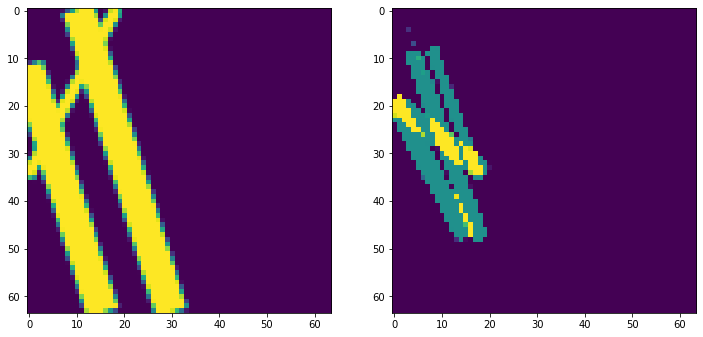

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2324.84019411609-7185.169852761152j), end=(54.9257711273862+138.99668079867072j)) to Line(start=(37.35350496762902-48.50648805298234j), end=(44.663780373569516+90.98187619270576j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2332.544546330001-7182.666556980137j), end=(47.22141891347511+141.49997657968603j)) to Line(start=(37.35350496762902-48.50648805298234j), end=(44.663780373569516+90.98187619270576j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(3191.6927444589423+8233.00988904313j), end=(12.816700262860586-48.24533170916125j)) to Line(start=(6195.913903248105+8460.675999324658j), end=(6.1644300506786465-58.78326783

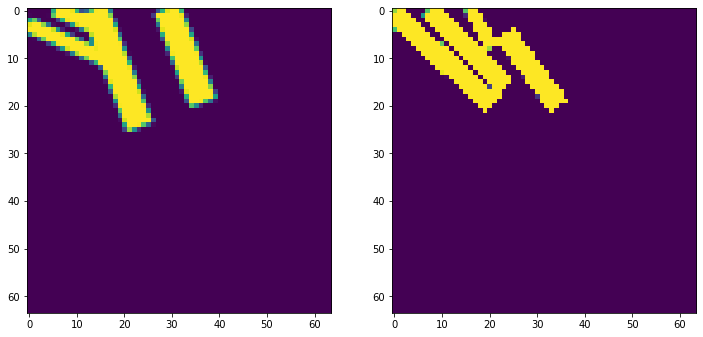

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3543.7344265255297+9750.090974852308j), end=(-41.872063056629486-101.28189032463584j)) to Line(start=(10.548669945605997+42.74288991026596j), end=(-152.80578264135298+102.19904828676869j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6028.3443914914915-5063.152483877902j), end=(133.51299248120142+107.2597743805841j)) to Line(start=(49.47245570138176+36.74139096469682j), end=(-45.910201583203076+150.41401545478308j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(11.39015917274373+132.8630078116891j), end=(5727.611150595308-8341.7831214646j)) to Line(start=(-7.016399284696675+94.98457550120014j), end=(84.79280442555708+15.1

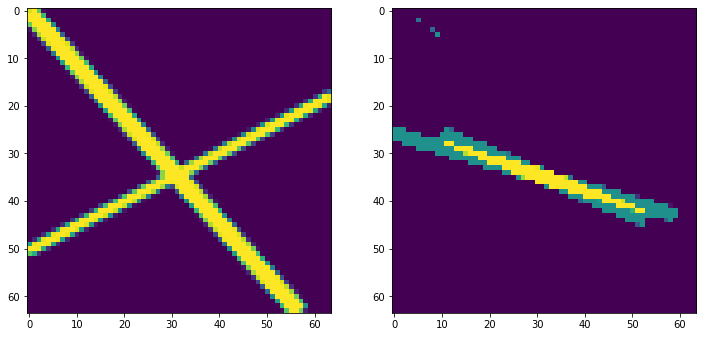

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4665.433307756078-9870.491158052062j), end=(-28.748437993840554+196.21408183830312j)) to Line(start=(48.21088612533852+48.847718491700476j), end=(161.75825400050678+7.519856405864836j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10834.04309078916+38.780075485787535j), end=(-150.99317672676102+38.7800754857889j)) to Line(start=(7.711633174940875+38.78007548578888j), end=(7.7116331749408475-112.52389561428126j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(113.09624720503132-30.494052542522194j), end=(-9399.34106660264+3060.2841898944303j)) to Line(start=(109.14973470810821+12.980522894738716j), end=(-16.882937124310715+1

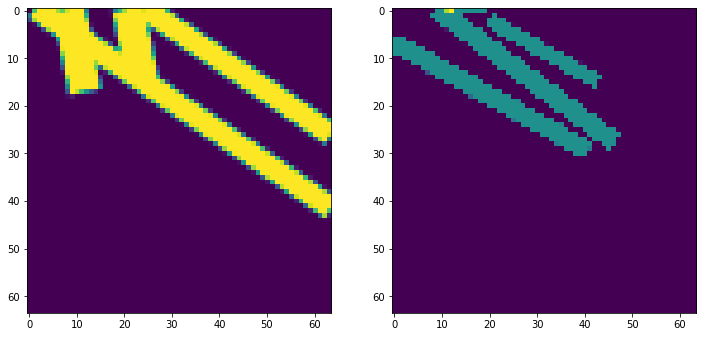

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7909.212593283452-4184.987331778702j), end=(-109.55800324079304+78.66862472297893j)) to Line(start=(8.31780285739184+9.781247820151735j), end=(47.67718664352895-118.95749569865707j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6293.071550667016-8042.676098704682j), end=(119.19896270693087+164.6558882467174j)) to Line(start=(18.27033588951124+42.41789520762292j), end=(-113.59706977149068+26.226613706131626j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-734.9566388275365-8968.637369176735j), end=(64.92629562950113+174.0664077534322j)) to Line(start=(-3.0888781816232065-47.88518094935087j), end=(57.31739723291067+118.079

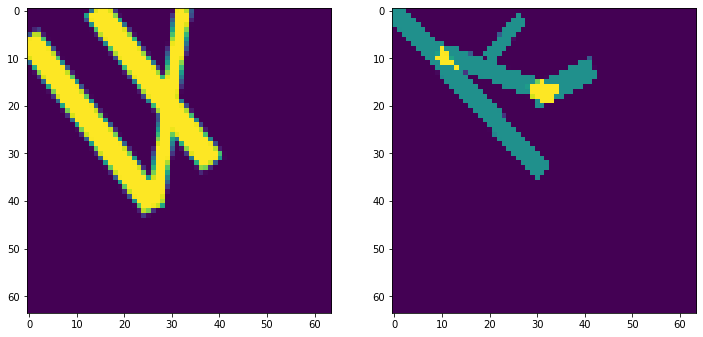

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7930.557722461797-1198.728455840812j), end=(-104.89689360238606+73.9625262777261j)) to Line(start=(14.07668730847472+63.13386978265984j), end=(111.65680041327612+134.0299718408713j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(1387.4917485203632+9697.298510086352j), end=(8.505356441092061-114.69951169430419j)) to Line(start=(3477.3597784534395+8094.552303637571j), end=(27.946140083184396-31.756977021710625j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-14.777169674250773+91.55730324794754j), end=(7170.594962699545-2523.7042750619844j)) to Line(start=(-46.93116813241389+54.84008550206705j), end=(112.7099097160934

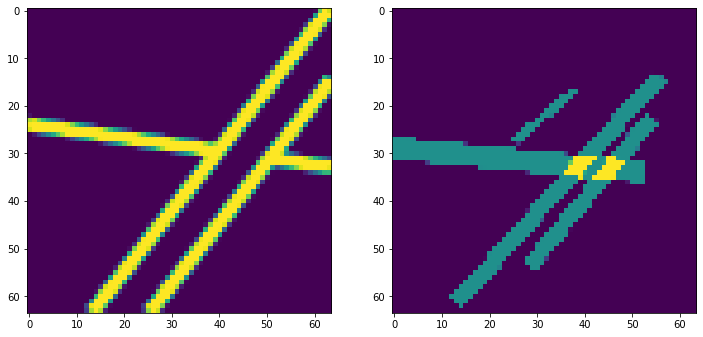

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8894.371016917123+6471.572870037732j), end=(-119.46187435063862-77.36006580181584j)) to Line(start=(11.809400233897016+13.14921305690402j), end=(133.54374247541926-85.4293135817773j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-1671.0344896795868+9664.438802675813j), end=(54.78263343172418-123.15647161032281j)) to Line(start=(-4288.654540664117+9228.028291209768j), end=(37.61627289482219-49.68940846591187j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-9316.834234208174-4175.985393058139j), end=(116.42890760845269+23.973953742351853j)) to Line(start=(-10710.717009491245+1166.74022888933j), end=(121.0772454811529

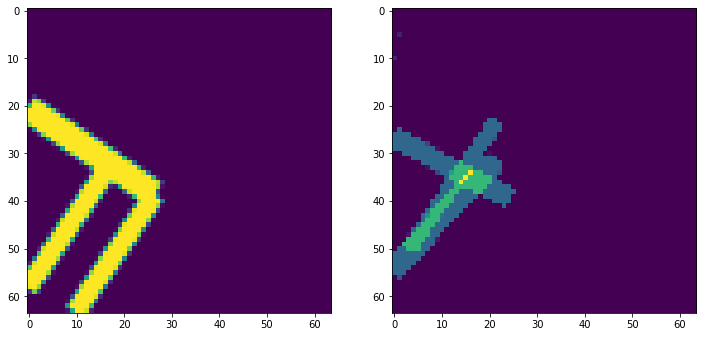

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1075.9387461867766+10570.632799854331j), end=(46.93975867212722-112.84253318587618j)) to Line(start=(-21.061714462891196+113.70035071355292j), end=(30.000067327702567-19.32013865290429j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(7893.538377100625+444.8659913370335j), end=(-88.65812794833658+26.536798706566564j)) to Line(start=(9992.400057448387+3294.5030954913345j), end=(-46.96687941971555+32.51503999346964j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7546.503514137226-1030.7092325633407j), end=(-95.02254761413889+43.23721855527311j)) to Line(start=(8.264452737562106+14.315659682056598j), end=(79.6583744765

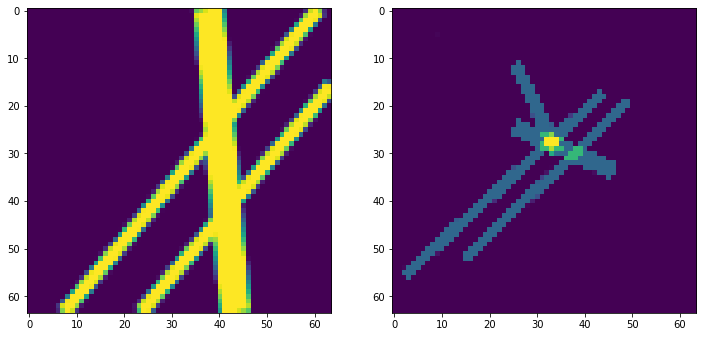

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9071.559135481766-6830.720688145572j), end=(158.97943652251845+124.9890374183123j)) to Line(start=(21.540657118323473+21.421488557096776j), end=(-50.89755138089223+117.55023803344048j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10281.67656933+1100.359976721812j), end=(194.45828027063516-0.7261651855737092j)) to Line(start=(-38.846459294645236+68.64974702933057j), end=(105.52587653093582+13.230399651834816j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9364.86774270405-4750.08670406904j), end=(174.13697333442377+110.27896159993617j)) to Line(start=(33.18385765267403+31.705902312074862j), end=(-13.406902069060507-111

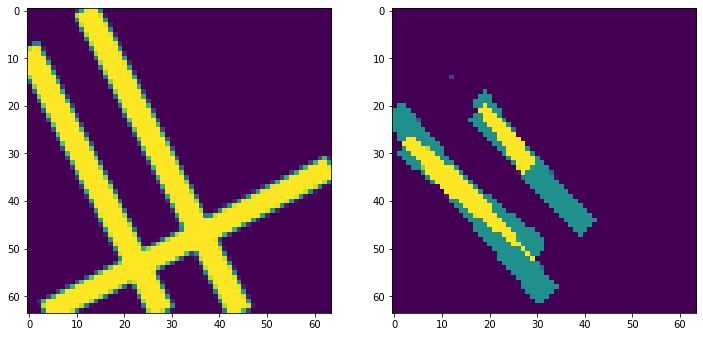

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4399.251442855388+9011.436307405056j), end=(-56.12817649051536-123.44564183394198j)) to Line(start=(11.13197265812218+7.170654143767779j), end=(154.83091922839816-20.76159151332707j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8595.916536379076-7159.806743660158j), end=(-112.66197927026688+147.5582768995936j)) to Line(start=(9.318842344422507+32.1479203943243j), end=(24.732511377148725-144.03112282718982j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8593.592152892605-7162.576836030725j), end=(-114.98636275673861+144.78818452902425j)) to Line(start=(9.318842344422507+32.1479203943243j), end=(24.732511377148725-144.0311

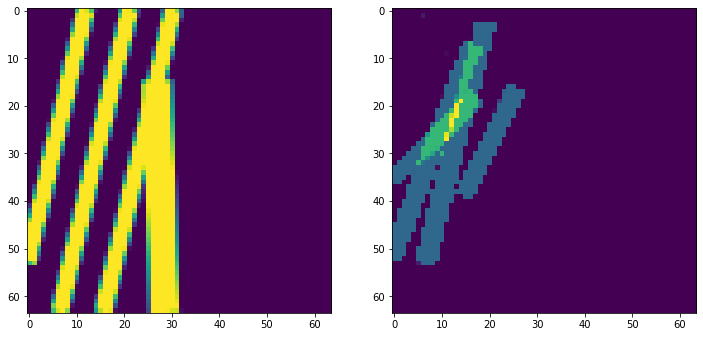

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1868.5078412925498-9784.347268203432j), end=(67.28354855094192+174.43610049664827j)) to Line(start=(34.185693569241195+27.11034814982249j), end=(-116.23666492917592-24.684223537339808j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8722.765211232654+623.9007075584318j), end=(-85.66068578840583+7.955566339093204j)) to Line(start=(-28.636558781181712+6.206952914792545j), end=(122.4486575523342-23.161038142255467j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4040.6731463203487+6815.700558283371j), end=(96.90917165108664-70.3928000527869j)) to Line(start=(40.120770617279696+9.78671839360742j), end=(-109.13349118309628-33.

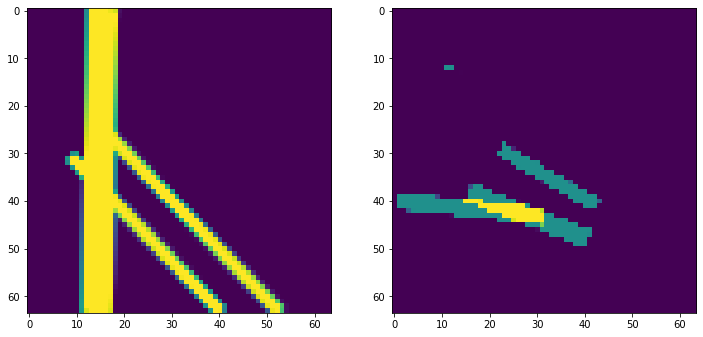

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7166.456123483058+5455.480883666178j), end=(143.97240284557563-53.32214033576666j)) to Line(start=(31.816747104037866+18.025585942176658j), end=(-93.69078092793475+0.3866531911294224j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4436.577926534817-8405.530495593583j), end=(114.57346060926137+153.94036600595612j)) to Line(start=(-11.878231957777906-11.787757175472338j), end=(67.27204158883478+73.0905195658095j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2003.1772732993395-11166.610974374995j), end=(-5.32493385761401+224.17107773627885j)) to Line(start=(7.7004707487666195+59.04412770907943j), end=(-86.59984990506199-7

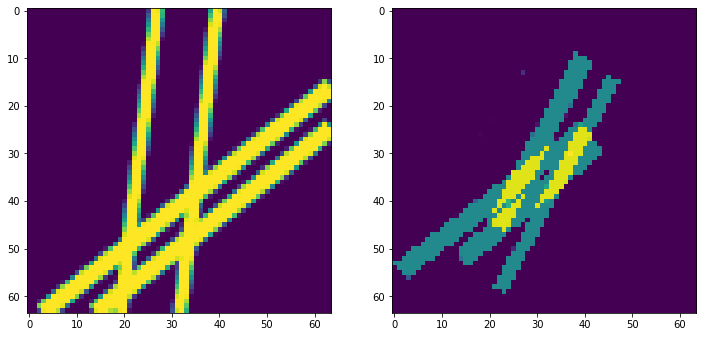

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1605.2730221623383-10051.138785282825j), end=(15.924537346444511+184.6997616532321j)) to Line(start=(46.68081334719826-33.339097443182986j), end=(2.2769691530529457+82.3368714973524j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-483.4800399229603-9981.67761999525j), end=(49.99416293357346+197.6165640870012j)) to Line(start=(48.55296350505305+44.77277956945826j), end=(128.08070643542058-43.5517270051269j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8927.327796586911-1882.207524265896j), end=(-115.19759226211481+39.84058120173254j)) to Line(start=(18.670855134610793+4.989318139048641j), end=(106.15939334319285-129.7312

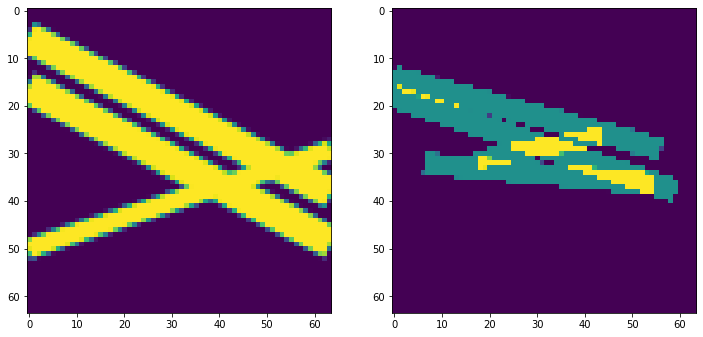

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1264.6992538436343+10051.6435249212j), end=(17.235288878012895-108.13516217360976j)) to Line(start=(30.311061698144822+45.59876715000918j), end=(-69.89399357706495+173.85538915295888j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10331.445814087007+1475.6436855906359j), end=(-151.26462557027287+2.3948104577278073j)) to Line(start=(3.4431526353396933+13.358689353002138j), end=(114.77732485643264-70.53762703904447j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10332.620844314008+1467.2829110905411j), end=(-150.08959534327107-5.965964042366998j)) to Line(start=(3.4431526353396933+13.358689353002138j), end=(114.777324856432

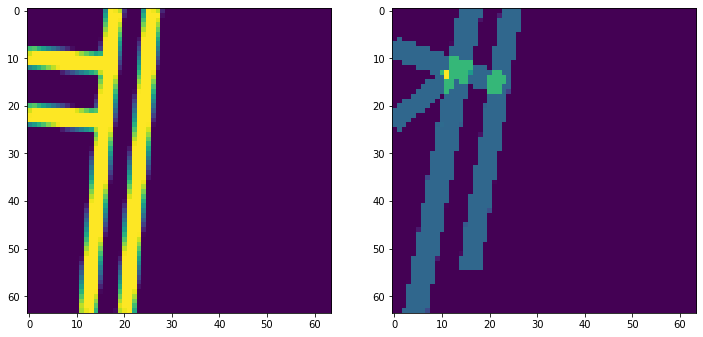

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-167.9816005455698-10455.234105492189j), end=(16.365354564153463+105.99587949059003j)) to Line(start=(16.798200254448613+111.47110075129086j), end=(2646.3745291485866-10435.183502454513j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(8076.5558723081085-6970.204512231422j), end=(-43.41212492650405+88.37597925681392j)) to Line(start=(8822.837291095533-4228.193949900598j), end=(-32.38013070258518+90.78416554651469j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7406.112427456911+4669.537630004255j), end=(-105.62409475018586-24.31630234091682j)) to Line(start=(9.175317490999134+37.88690110793291j), end=(183.1240

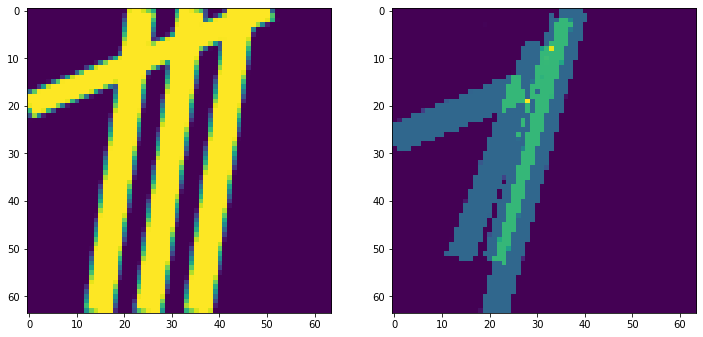

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7804.52776450392+2261.202789188385j), end=(145.9444787763884-18.558441175720073j)) to Line(start=(30.100029242159746+16.91652529290563j), end=(32.28265540864605+141.95909462519697j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6634.249709163511-5687.599611494279j), end=(-50.443583214271214+123.31561393881505j)) to Line(start=(53.30461328096298+42.532477645676146j), end=(209.8001382238425+53.47571078835783j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5409.769751722228+9791.372963149737j), end=(86.51094529782972-124.17989065095037j)) to Line(start=(7.574689816518417+113.99864329540357j), end=(43.93040005537127-31.8161

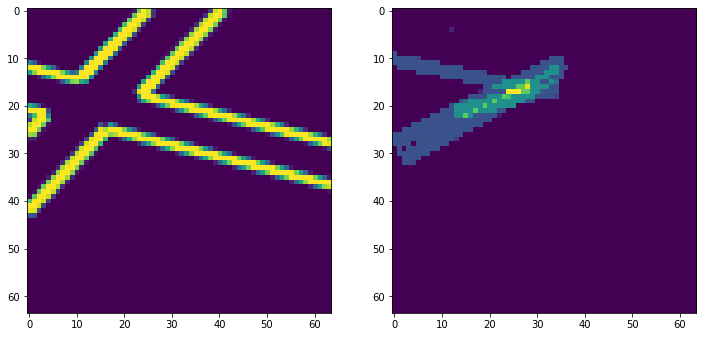

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(665.7852273480195-9458.824446309749j), end=(-9.269316321603938+194.9052877864994j)) to Line(start=(2681.836398777521-7685.398601637686j), end=(-1.847053359350646+108.58407229682314j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4721.898152983561-8781.980413159728j), end=(-49.199687208457945+191.1495636461394j)) to Line(start=(33.00216471095837+63.192485125489185j), end=(135.09232671996594-0.6005282453976335j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-3551.9136249722224+8869.888369867089j), end=(51.37913824019073-48.57417737003348j)) to Line(start=(-5578.298902686423+7416.510002577777j), end=(47.44168367616864

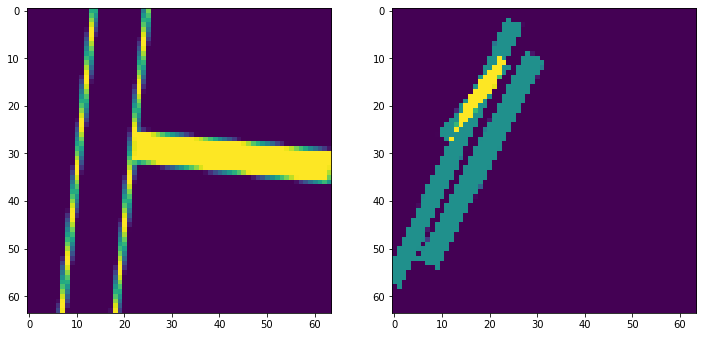

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(4251.14283170705-7898.780431628265j), end=(-7.560206262863396+110.67507993258204j)) to Line(start=(2530.881348996452-10907.327892880538j), end=(-16.560815037872164+126.85638176836679j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8472.316267370154+3111.288672439083j), end=(-91.5249765173002-5.69463131719818j)) to Line(start=(37.894394024929625+33.59245586633041j), end=(190.29335599626782-37.47234719577695j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8474.663915112156+3104.838563279096j), end=(-89.17732877529737-12.144740477184605j)) to Line(start=(37.894394024929625+33.59245586633041j), end=(190.29335599626782-

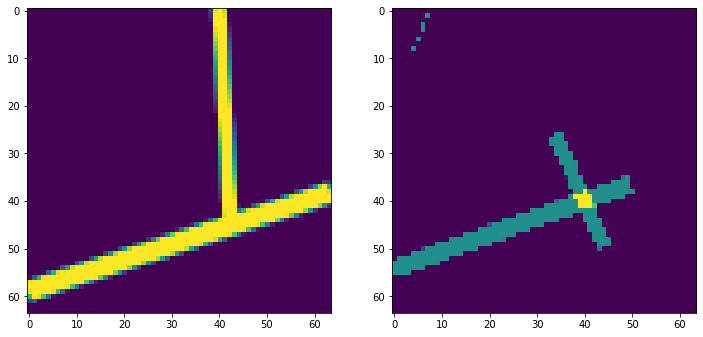

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10084.287707900814+536.6196322783735j), end=(-118.01058628811298+1.9398350967707039j)) to Line(start=(29.243817092382024+6.344318214560225j), end=(76.7429363732449-139.8429392264752j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10462.116376589132+1496.833572936779j), end=(-153.80297094502475+4.863406701060708j)) to Line(start=(6.377515769158858+20.62023851585794j), end=(138.51789308783253-78.95467799474002j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8884.442355848607+5987.919002646264j), end=(-114.33683363436968-81.83420184439055j)) to Line(start=(17.53525459792639+7.11464480208907j), end=(-58.24566388517639+119.464

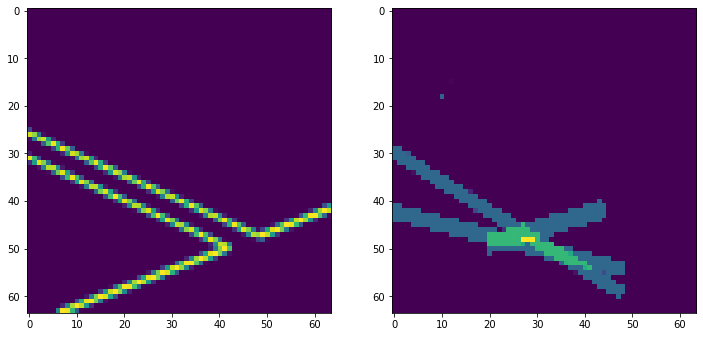

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8075.073414253434+13.127452798780672j), end=(177.5233619120085+13.127452798780672j)) to Line(start=(56.246927941347224+20.79784345570443j), end=(-28.092521641649057+105.13729303870073j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10537.085272604112-3594.724284470043j), end=(221.06056694214567+109.60239588305642j)) to Line(start=(61.726241216465425+47.4489234097003j), end=(2.1853805823699304-74.62793187932307j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10535.169044558697-3600.289414803648j), end=(222.9767949875619+104.0372655494511j)) to Line(start=(61.726241216465425+47.4489234097003j), end=(2.1853805823699304-74

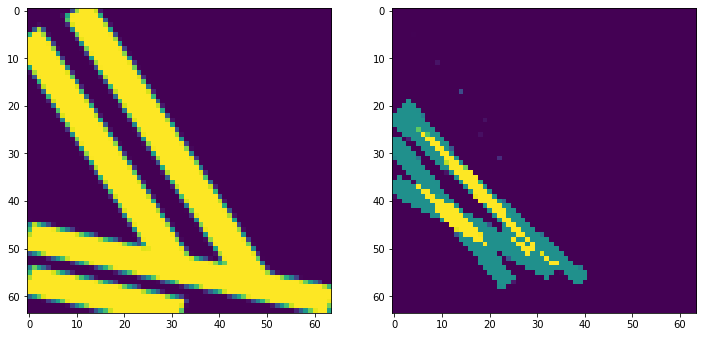

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1489.4117651287656-8155.223716870936j), end=(27.06102216944022+138.17946557873978j)) to Line(start=(44.96338992593806+12.058871337540879j), end=(-28.65428760807235-93.07806809363974j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7718.280610027438-1486.0996840208654j), end=(134.12290321072516+40.252938356477564j)) to Line(start=(20.485147794270016+10.295296130047578j), end=(-73.00090665873522-128.30347930223473j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9504.199674950069-1150.9307372971243j), end=(-139.67512823521156+33.188195814566235j)) to Line(start=(0.4004367515345031+18.973047180713095j), end=(61.8789645187897+

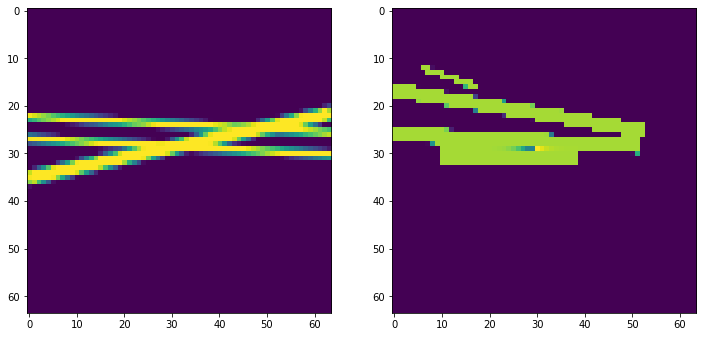

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6867.646635488166-6442.0435352095055j), end=(164.7954999143594+115.81484844350531j)) to Line(start=(61.37047919060675+13.122831713949704j), end=(56.67087435906241-121.45624257176884j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-9898.930809766396+4008.2355750248817j), end=(78.8598251819467-23.05351738667352j)) to Line(start=(-3061.1431008055624+7346.30445686229j), end=(63.73752319353558-15.4529541027958j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5680.692149024286+8082.301804791462j), end=(-60.729921925789334-117.29868170106514j)) to Line(start=(3.0042187375142753+6.239880448721263j), end=(-21.27720227444193

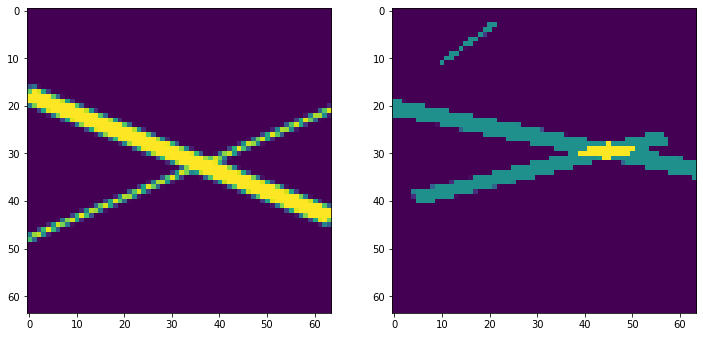

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9230.245259777828-4085.741257039396j), end=(-117.55088312264634+76.16573019639112j)) to Line(start=(24.80627975557899+6.5641567225321245j), end=(147.62748759843447-92.89449632633774j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-8384.234161246382+3971.3735818341684j), end=(188.95059203591438-26.368123399035618j)) to Line(start=(-9187.518708117172+1640.107220039201j), end=(119.50951108908703-0.9729652219203508j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5600.946130317205-8269.103613728015j), end=(-73.62083296523203+143.78787924639522j)) to Line(start=(6.76120537604168+24.616606632128203j), end=(-103.9227704759

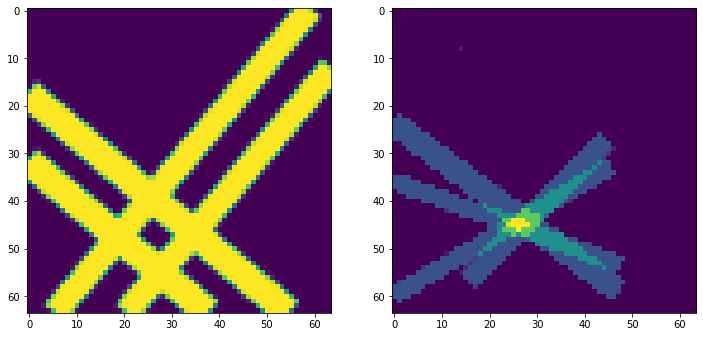

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9514.156936070583-5891.558304702022j), end=(-107.19057912857845+120.52688161489677j)) to Line(start=(32.830585440345075+24.207247671009874j), end=(72.0057469237621-145.47901916559698j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7197.7183797069165-8518.21800845429j), end=(-105.05961799652766+184.8939062267371j)) to Line(start=(66.65957662013685+30.239145750295904j), end=(-28.201397189380373+96.66151469363376j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))


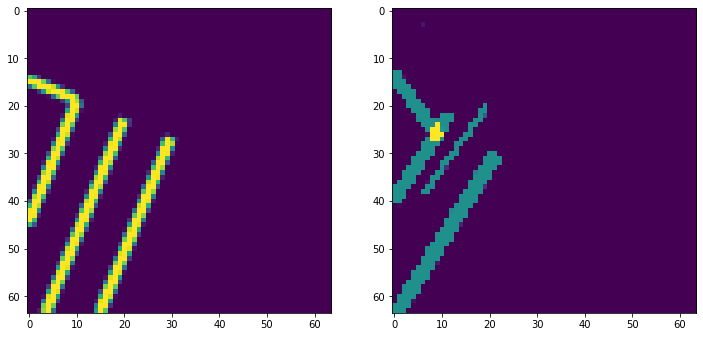

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7964.994423202269-1643.976783749469j), end=(-82.50980259296624+66.57304451053946j)) to Line(start=(19.100814648877602+44.975041080444456j), end=(-14.089214614912564-111.17176992845408j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-26.735142170689123+86.15117799698955j), end=(7402.690951797374-6372.15039507526j)) to Line(start=(-9477.201426109828+4644.491672479395j), end=(88.44927526568497-20.987905419338823j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7340.076453420502+6443.541788989985j), end=(89.34964054756185-14.75978408226436j)) to Line(start=(-9478.980555804159+4640.843916032443j), end=(86.67014557135582

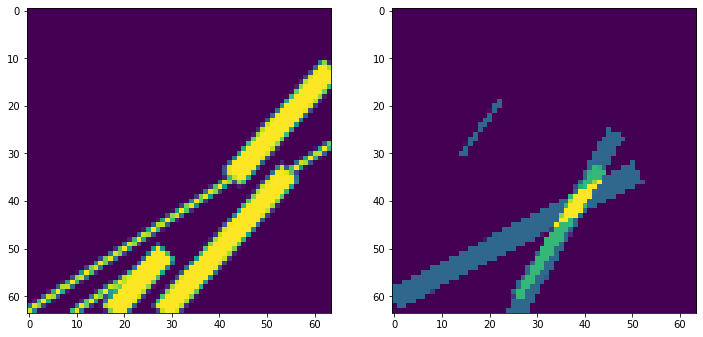

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10706.00414840515-704.3298657980267j), end=(-143.017205491335+54.30761018702377j)) to Line(start=(15.88146020930082+33.22442766833831j), end=(120.25008926163197-86.83794589843234j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10705.44432924438-712.3356527803331j), end=(-143.57702465210656+46.30182320471735j)) to Line(start=(15.88146020930082+33.22442766833831j), end=(120.25008926163197-86.83794589843234j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8092.712998749208-7741.0294038847705j), end=(-107.63075630353508+177.95050992895182j)) to Line(start=(10.37997387161014+54.03980978494983j), end=(12.882278462889712-89.31712

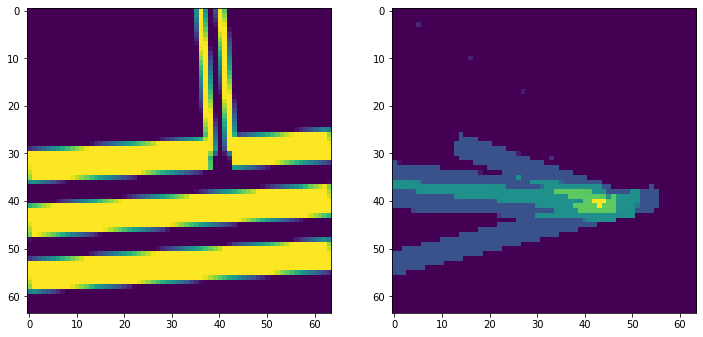

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8387.42639568316-6033.193417533701j), end=(-112.52876974678588+142.38549628999786j)) to Line(start=(12.937874534093961+44.72871746938562j), end=(36.409274842001935-103.46387177621284j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))


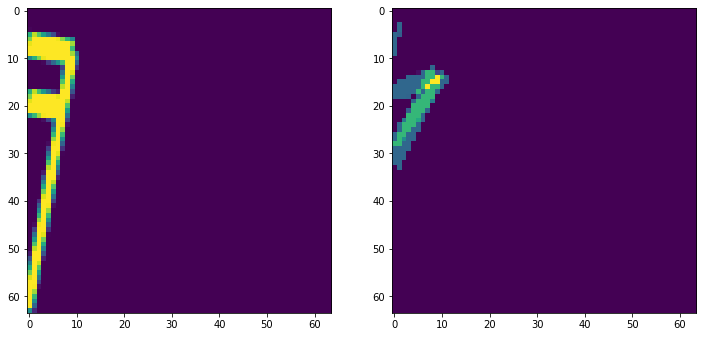

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8592.032077672306-6450.03964005847j), end=(-99.02864219311327+99.14436508542038j)) to Line(start=(57.28055985557896+28.468480937645456j), end=(-49.62433863189716+71.66086359683102j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10115.474164176785-672.333694952232j), end=(-126.76962365582378+43.87376027912914j)) to Line(start=(25.655350459539857+26.06767276655134j), end=(106.57281425513828-67.017221176355j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(7434.005812123494+7987.444659441799j), end=(-113.79475939957072-106.58050296595275j)) to Line(start=(6729.155456712079+4185.85394556454j), end=(-29.84284240366331-37.6369411

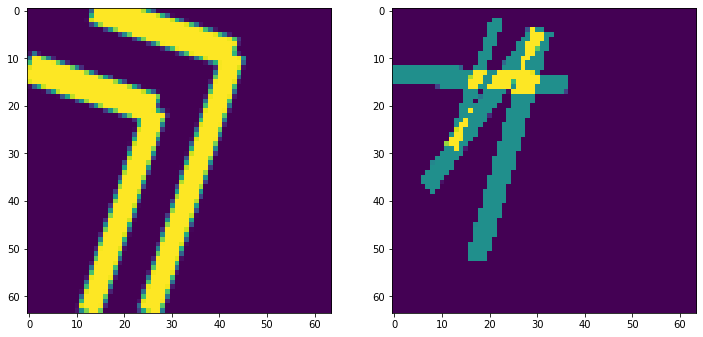

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3818.137033662173-8126.628184553532j), end=(-48.04316273484461+164.4220025568922j)) to Line(start=(17.282115577717164+48.381526886277776j), end=(157.98300090450755-2.829407307576176j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1113.521348174193+10445.954154819276j), end=(2.736537959035605-122.4573597822091j)) to Line(start=(24.15870225393276+37.65279104098491j), end=(134.5661225470963+127.05895714063917j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1700.9757609209491-7090.256562446129j), end=(27.223732862592406+159.55996662282917j)) to Line(start=(61.664995004764705+59.54657495546384j), end=(196.41271121784183-24.653

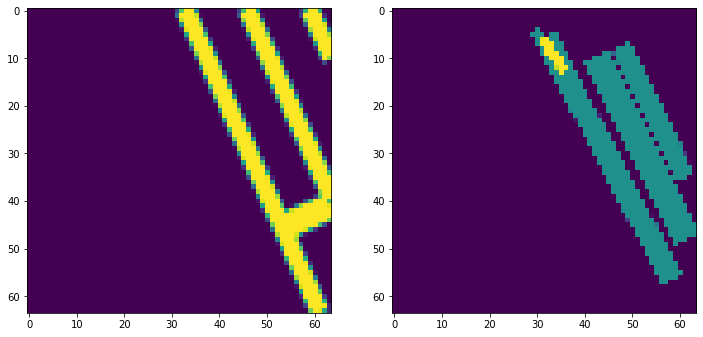

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1606.2798047278561+9290.781436061856j), end=(53.67289233089423-123.27811619284151j)) to Line(start=(35.76561743097701+18.194257691852503j), end=(127.75765393670369+149.57250126365372j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9869.814556379957+2328.6268908395123j), end=(187.87913791335066+6.625340743030634j)) to Line(start=(37.18916302874286+32.56607086557932j), end=(-75.87738809016705-38.08575165471673j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9871.340229468871+2322.018474662847j), end=(186.35346482443884+0.01692456636450146j)) to Line(start=(37.18916302874286+32.56607086557932j), end=(-75.87738809016705-38

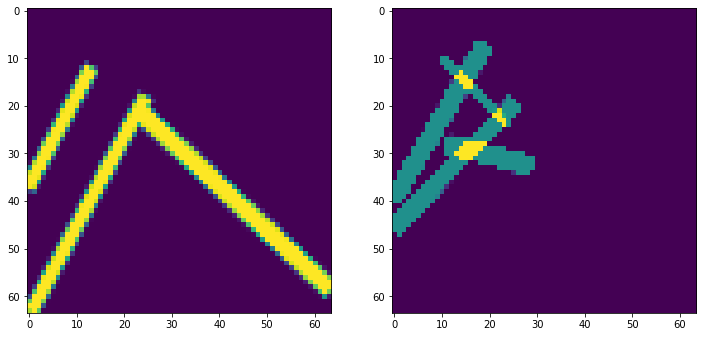

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10341.211321274204+45.66193476744109j), end=(-112.62395562893151+45.66193476744245j)) to Line(start=(45.6439170174489+45.66193476744243j), end=(45.64391701744888-80.64580876273831j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(5013.57695784918-6372.872572546085j), end=(-60.51030769148957+121.66296400015594j)) to Line(start=(7096.643400836041-5289.486004159832j), end=(-23.21373367813149+75.71117570659459j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7065.564585318492+6898.83045569446j), end=(149.56476825510214-68.73896983258516j)) to Line(start=(41.11519504404822+40.204129214002826j), end=(38.47976921483002+191.

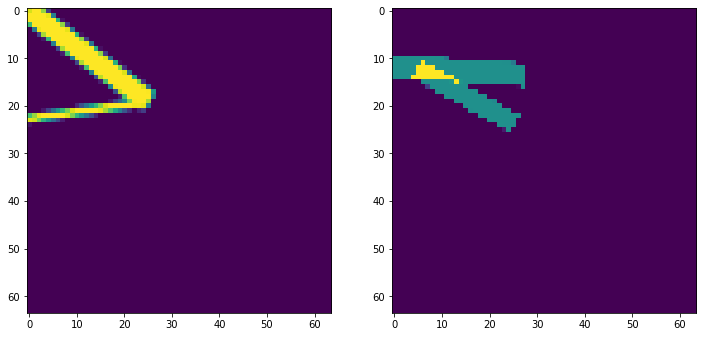

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8931.663674326015-584.4772520229807j), end=(116.80614382098891+48.25339532711455j)) to Line(start=(-28.546211794677916-5.779057146338788j), end=(130.10028010934246+48.84731076775074j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8932.386394891273-574.1418664223437j), end=(116.08342325572949+58.58878092775159j)) to Line(start=(-28.546211794677916-5.779057146338788j), end=(130.10028010934246+48.84731076775074j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10418.321130991937-3966.6816690784126j), end=(-153.4379133840367+91.43641511789978j)) to Line(start=(3.44505758399805+46.67214147319963j), end=(145.83547934339964+110.

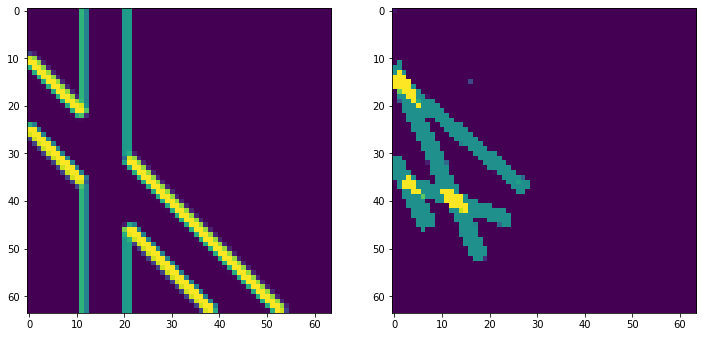

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5088.019651696408-10000.765185311211j), end=(111.6165350662015+204.09541963381858j)) to Line(start=(35.42187765908624+46.28520602858307j), end=(80.68185827469424-93.01069120494486j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-37.36569334951567+20.577127380475694j), end=(10718.113781357377+961.559652203085j)) to Line(start=(-8679.495527295558+1592.2108294386073j), end=(113.07640284979738+41.843168334076054j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-10624.790801264113-905.7025454917803j), end=(130.68867344277953+35.279979330828965j)) to Line(start=(-8678.00411597203+1600.6690433632966j), end=(114.5678141733

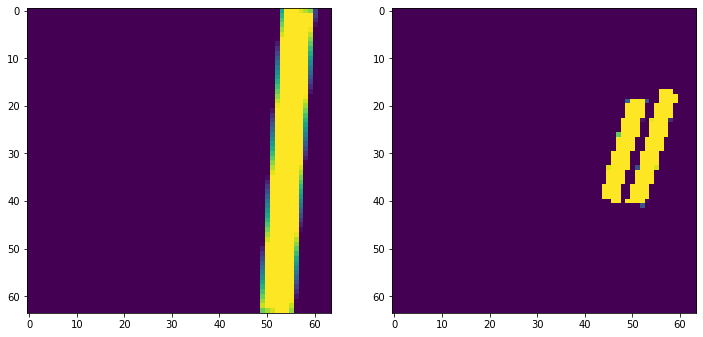

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8637.896712927151-1774.6074204004137j), end=(-92.61681714129978+81.12051716454303j)) to Line(start=(37.68058360316478+48.15242426150649j), end=(112.73986730343535-67.42873691755929j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9440.180809982501-6056.373972156493j), end=(-119.99324979975952+152.07565455598052j)) to Line(start=(28.26761400975477+60.323022914111725j), end=(200.27400836382412+96.88411068327062j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5679.415942334628-9377.992853816353j), end=(-78.26938135004272+204.4046962227468j)) to Line(start=(3.44602367623364+62.64514898372417j), end=(-119.9280265543071-65.11241

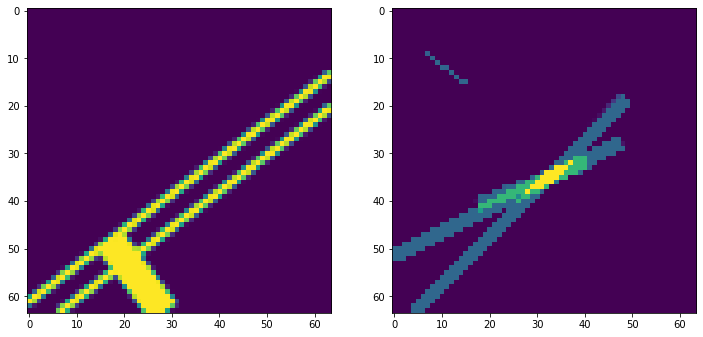

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2009.8820430111623-7860.516244229693j), end=(11.035914773098128+156.41769597947473j)) to Line(start=(31.755802476035957+37.469399892868424j), end=(-51.91415750671415-101.78079779551136j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1146.493753794831+11032.190286860956j), end=(30.32237361152602-164.46724489001917j)) to Line(start=(16.198020972885452+7.028096321138412j), end=(107.20720287376125+119.41507626911104j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9860.304744126423+4645.953527906217j), end=(199.84149986678682-45.16970782705956j)) to Line(start=(46.21846109071119+25.13623723792029j), end=(-42.987095887334846-

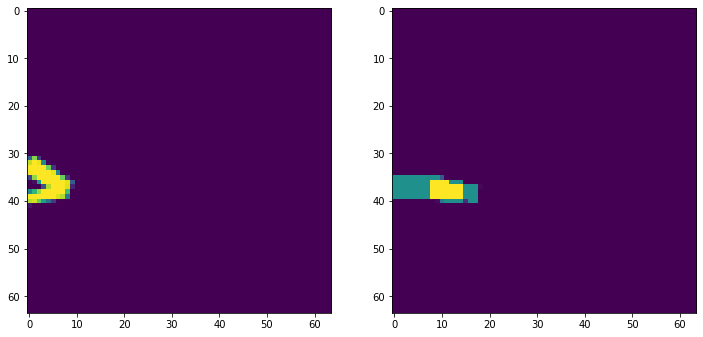

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7148.067163248152+5445.24962740384j), end=(147.04050996671288-52.0083056831929j)) to Line(start=(-48.196936880451375+33.4792910952943j), end=(91.21904429633534-22.848421600668154j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6393.758638406516-4636.334658180297j), end=(117.19083465308331+94.14703169159588j)) to Line(start=(14.533769769360118+29.019574552528894j), end=(-154.03611838218268+11.302165369540447j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(33.66179054582138-8905.364861645014j), end=(33.66179054582184+97.65459698605824j)) to Line(start=(72.76320105753834-39.996163719111294j), end=(34.98670405401993+100.987

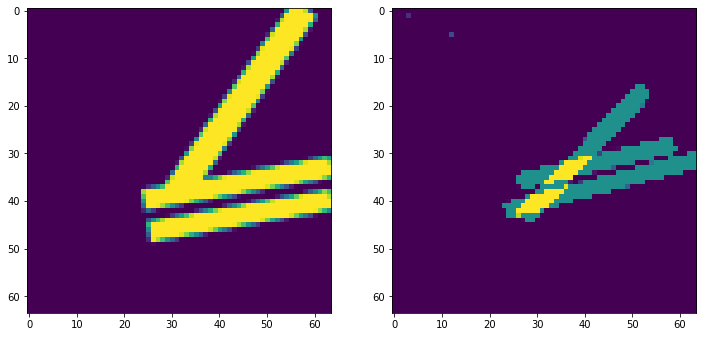

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1649.809281861626+7424.019368140488j), end=(64.68711780998339-2.280423584136585j)) to Line(start=(70.12130869404423+145.32673911425894j), end=(63.82601657284835-34.94684055825027j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9833.3333499444-841.7900915260257j), end=(209.1269150441725+36.8113355700175j)) to Line(start=(56.617829424977685+10.982319556014033j), end=(-67.34120240518301-34.135078298621174j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9832.41394477457-852.2989407046148j), end=(210.04632021400278+26.30248639142826j)) to Line(start=(56.617829424977685+10.982319556014033j), end=(-67.34120240518301-34.135078

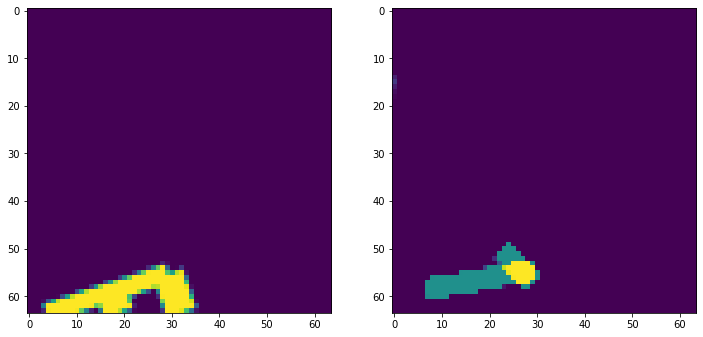

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7080.693739265159+2218.8173494980188j), end=(134.335358296287+12.961586756491187j)) to Line(start=(32.45859733747625+49.934865727040446j), end=(-0.9153799538749823+194.49344319343572j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8538.519499145272+6008.0507185964425j), end=(-101.20931808945397-41.552527318971606j)) to Line(start=(25.552133654676172+54.42445459973807j), end=(53.080559735872896+210.545916956719j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-9537.34549364501+215.44389632345244j), end=(175.32663882329155+45.90857362472795j)) to Line(start=(-32.75013309691488+18.852347306923793j), end=(79.33318435125759+46

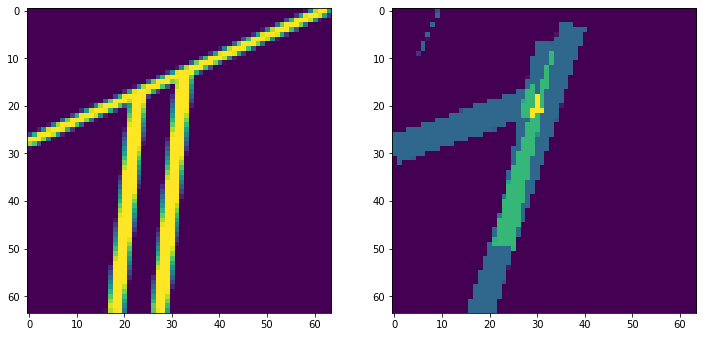

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(10099.050288120563-4479.361386475462j), end=(-68.17680010511818+47.37976324859745j)) to Line(start=(7997.803353308587-1221.8409728237561j), end=(-44.510077878396245+51.93633888929615j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1369.0451935662181-11192.82567918792j), end=(30.259851616908193+203.59936719612017j)) to Line(start=(15.834308059694749+31.341895368383202j), end=(113.15376381255388-93.22132767207333j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-9086.090619747083+1962.3762623003672j), end=(129.8965479881476+3.457717531515719j)) to Line(start=(-7713.718117912861-413.57492848695347j), end=(117.77376972

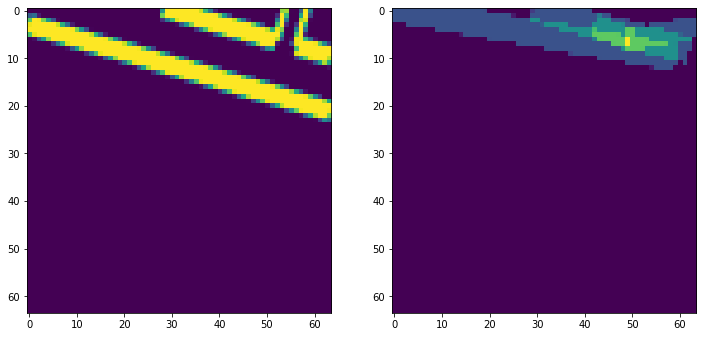

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3559.7468222852754+8749.340689269391j), end=(-14.364112195601805-96.89429731565231j)) to Line(start=(51.56178668444187+33.73198640130772j), end=(121.92895487341586+127.11237255857793j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3835.113781419855+6689.330902369184j), end=(80.2451283137114-92.2696591568386j)) to Line(start=(44.497875560256944-0.9893006409460039j), end=(114.55641701683145+120.35565266601164j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))


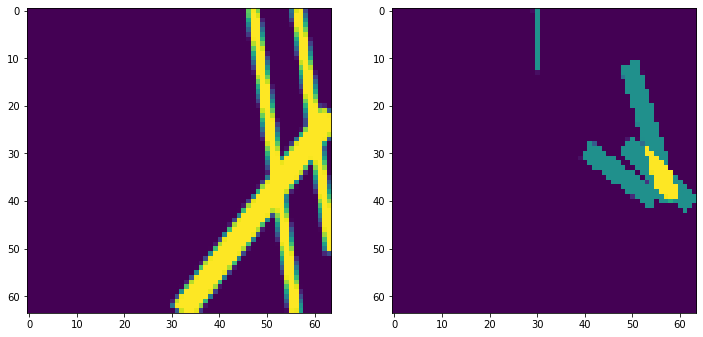

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6117.389495159956+6137.096006678861j), end=(-79.31296042865654-59.60644890975122j)) to Line(start=(-2.5386129414965843+25.641657290795187j), end=(-70.97666564996186+144.17984175293392j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6566.588499287918-3460.762483253435j), end=(-74.87220613903762+70.56481383117395j)) to Line(start=(58.580942474989776-43.66437440210521j), end=(-32.078128461714165+40.87657694159566j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8678.046411578223+3560.0350670983903j), end=(109.23574601553122+9.742621617178685j)) to Line(start=(-44.330670982398715+27.944847838274146j), end=(117.55940300582085+

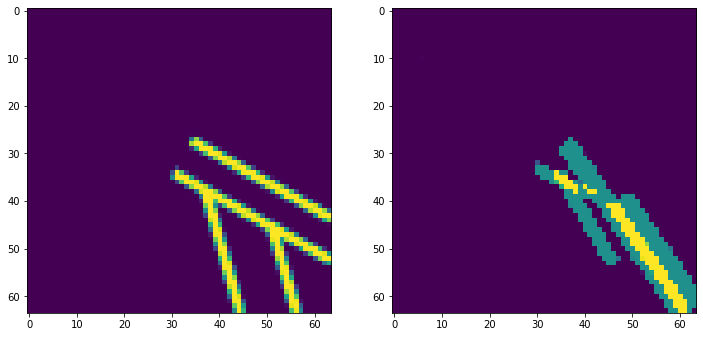

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3250.0304737198144-10399.566458500263j), end=(30.351946327186475+131.52748349904954j)) to Line(start=(37.55791550711758-12.91305548555218j), end=(33.37691921414492+106.8150133349465j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5713.84776455928+8164.452155819008j), end=(-63.67530262874919-86.70589649215803j)) to Line(start=(11.147252601750855+39.49397710272201j), end=(-20.194162684973627+217.23997581941114j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5704.892068650865+8170.723001603995j), end=(-72.63099853716467-80.43505070717165j)) to Line(start=(11.147252601750855+39.49397710272201j), end=(-20.194162684973627+217.2

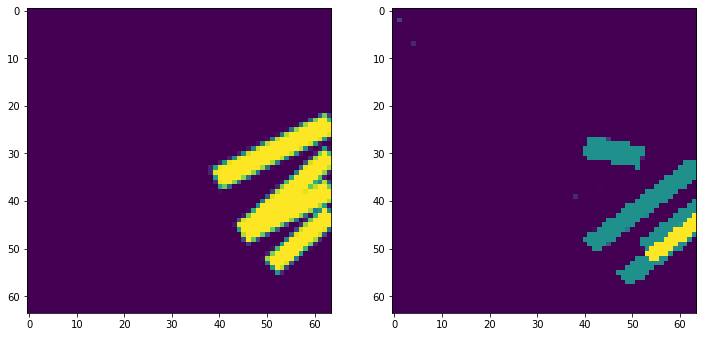

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8727.037665670774+3927.5195764571135j), end=(152.6539543004566-25.973849447901628j)) to Line(start=(22.227807129145607+38.992863440691885j), end=(-40.75865452460454+203.07820591863185j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(620.5563555299303+8248.181326610138j), end=(38.00686775012889-82.664476147252j)) to Line(start=(-1860.3051095957615+9684.712502033723j), end=(28.489848533501874-32.29518515468084j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(7870.547205229524-667.5244203910211j), end=(-32.34870682970147+23.889380939529225j)) to Line(start=(7643.954709880985+1384.887149597602j), end=(-31.07050675594112

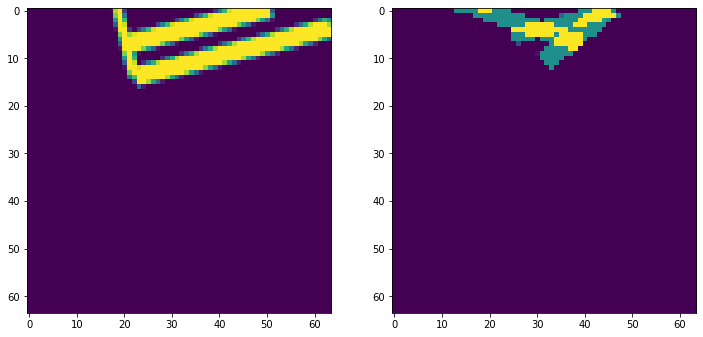

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1402.1147362465617+11343.060639865193j), end=(-7.29649599734887-135.67269500779946j)) to Line(start=(-5.388307629381941+27.967841969318293j), end=(-79.34137669164589+122.62345389055989j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1388.9485240662239+11344.677247446512j), end=(-20.462708177686622-134.05608742648224j)) to Line(start=(-5.388307629381941+27.967841969318293j), end=(-79.34137669164589+122.62345389055989j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8951.64830969552+634.8502045185342j), end=(-124.41313240880133+0.19016286875965172j)) to Line(start=(11.458943373243034+3.271945282215585j), end=(98.834686806193

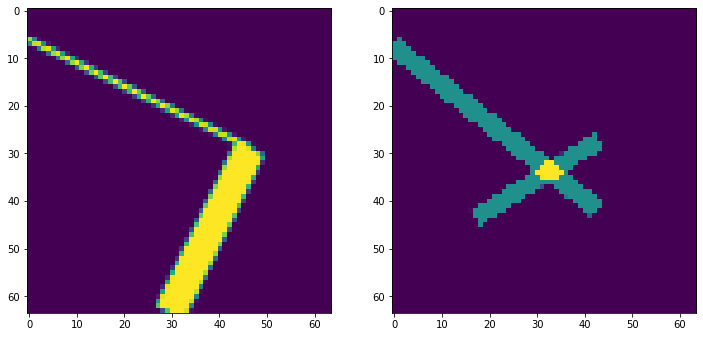

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8231.934618620113-6835.705040324909j), end=(-17.726749401749345+86.58277091969265j)) to Line(start=(-11.315326791020013+74.92073707469524j), end=(66.73340428510014-36.54440264041729j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8107.573551838843-4854.685517403458j), end=(159.54075129203926+112.69790034736117j)) to Line(start=(46.57439554830178+31.041599397376768j), end=(16.47065050907182-89.69792723399098j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10908.097560418671+8.160541723959545j), end=(187.6946069540659+8.160541723959545j)) to Line(start=(20.91805602926619+19.583766137895267j), end=(-108.5177769488883+94.31

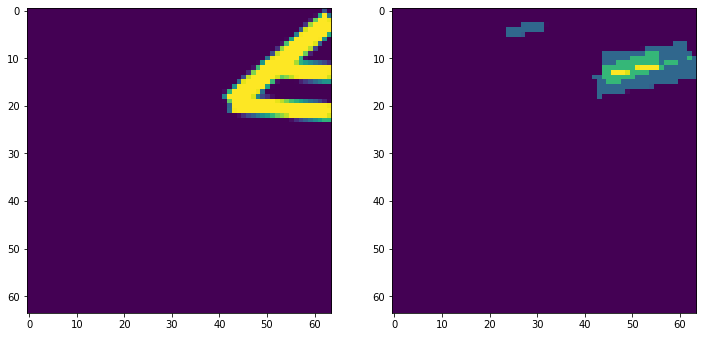

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2993.6636182001753-6850.163360618031j), end=(82.07611477054843+58.061186592549944j)) to Line(start=(-9.518160892465582-51.47722492468556j), end=(94.76171666401682+77.29769935363775j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3612.4564949544206-7484.790943421369j), end=(103.46135692431703+133.96970327869195j)) to Line(start=(38.82249964548275+34.02942426035396j), end=(-105.3715858806623-15.62058105934937j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6491.419031000604-4189.426707521541j), end=(-89.49271699097528+84.26735178689414j)) to Line(start=(7.591192062623687+44.508806015483835j), end=(132.25481936590614+71.00

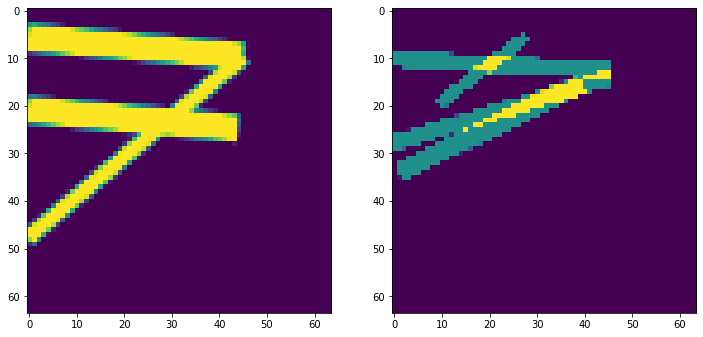

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6758.020226226712-7964.046022829498j), end=(-64.59228318946124+166.82694614541518j)) to Line(start=(37.7514055872189+48.91686562808506j), end=(169.94826211181234+110.56127220952061j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3845.6889893766593-8127.933571013559j), end=(9.872634680902664+98.00114743525297j)) to Line(start=(26.178452210665082-54.4741250800393j), end=(-2.148731935906902+106.17731937137785j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7833.57862894836+33.49042036525404j), end=(-101.73058752912789+33.49042036525495j)) to Line(start=(83.41404264849302+72.77557585592072j), end=(-45.20894809764684+38.311149

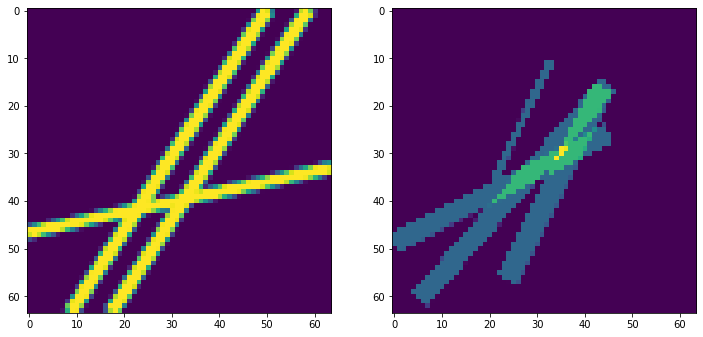

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(7533.79070979185+4220.189567447974j), end=(-80.0076969170996-0.20780532746584868j)) to Line(start=(10727.608388523899+2701.3434041449455j), end=(-30.787631688176333+18.97401062944784j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-298.73618833021806+9271.136976449923j), end=(26.932079023051262-54.78201368649211j)) to Line(start=(-2673.0501574106825+8758.208683958732j), end=(21.308351578090726-54.64090030222113j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7932.90863500735+5790.633950833333j), end=(-88.83739141336326-37.50568621932779j)) to Line(start=(35.20384197394284+45.36028446819261j), end=(149.260990

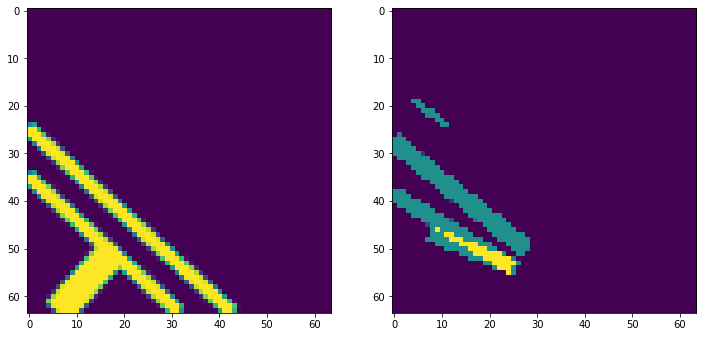

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-8185.445036636826-1463.058139816682j), end=(106.46434650464565-0.9707939791597511j)) to Line(start=(-6881.854875524825+4898.210904965873j), end=(110.1137660168001+2.38175523251914j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8587.991309067866-548.0535377582156j), end=(-99.38143390654434+59.426742322936015j)) to Line(start=(21.18005910031205+50.996261473816695j), end=(9.129545825921443-121.33410708531952j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(129.56631571203852+76.43254004608171j), end=(-8895.822377710596-6480.896177504197j)) to Line(start=(5219.475913995309+6426.216568286641j), end=(7.45119832120325-10

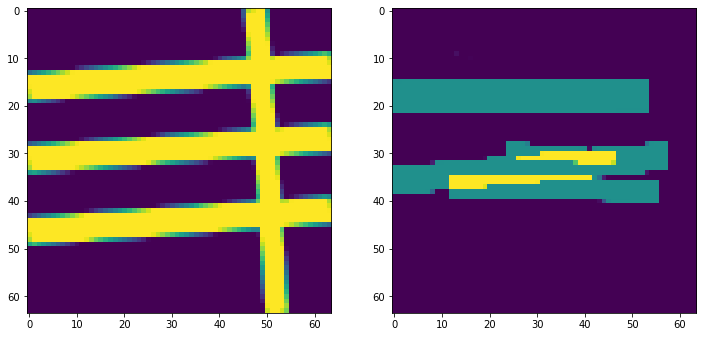

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-4928.485838989944-7057.841667167903j), end=(58.927699952346686+64.92303727116209j)) to Line(start=(-58.85635511520874-24.780723482949888j), end=(63.94178071547823+78.25914700183708j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7222.637411026989+2105.400966259745j), end=(-83.53807878950097+10.388857010769321j)) to Line(start=(26.788147820828836+36.208929368864425j), end=(129.0352672790485-20.46757443179937j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(8931.89793032611-911.7912460666804j), end=(-98.1441618294492+37.304422446197j)) to Line(start=(11272.436565995582+1840.693401484491j), end=(-47.477956272504+47.795075353

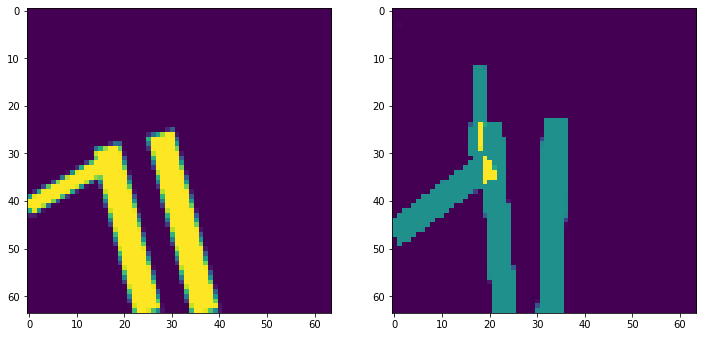

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-2836.646257057967-10684.331765605482j), end=(74.47433021178185+180.11817304495545j)) to Line(start=(-5493.151080076778-9508.397279463888j), end=(50.509302624646445+93.5041632817055j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5555.549031309585-9644.791134951192j), end=(115.31151665756124+177.42745676578852j)) to Line(start=(22.75745206601857+38.6852051533084j), end=(-146.25855750472724-6.602498119103771j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1223.8990787482778+10436.041515215815j), end=(71.97483888506133-118.00459696669606j)) to Line(start=(48.27597451995132+22.348410914569147j), end=(-81.50643545811

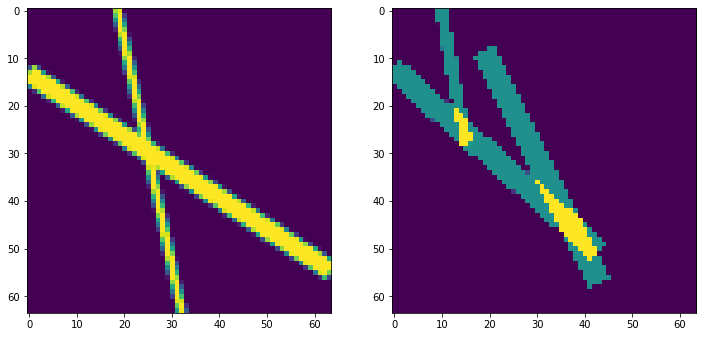

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3037.844310985489-9183.923177613979j), end=(-1.7419687228633123+170.96147526819672j)) to Line(start=(23.557550442864784+44.77498474195085j), end=(-81.42584479395657-71.82088785732233j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(3029.445802312552-9186.6520185008j), end=(-10.14047739579992+168.23263438137673j)) to Line(start=(23.557550442864784+44.77498474195085j), end=(-81.42584479395657-71.82088785732233j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5900.864330642171-8443.12924938802j), end=(115.66593541874953+149.36645759047838j)) to Line(start=(28.480244618838473+16.311719676640795j), end=(53.04929167359283-123.02

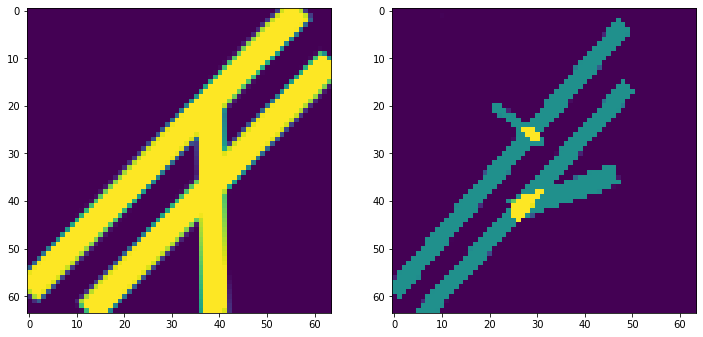

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6523.62691450268-3204.0287808496337j), end=(124.31352467498562+38.388418182157736j)) to Line(start=(8.322112670834922+17.766732131135846j), end=(140.62081483976542+43.48299475725154j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(9869.133230525335+2867.2748273605625j), end=(-107.66662067856547+6.473505388683613j)) to Line(start=(38.77947160849993+48.466246614408135j), end=(84.79461630547075-112.00763363723718j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7382.051006004306+7617.537192030426j), end=(-15.182660708311417-42.52250804265674j)) to Line(start=(104.17443015478142+32.248911576474974j), end=(0.5247077054748814-30

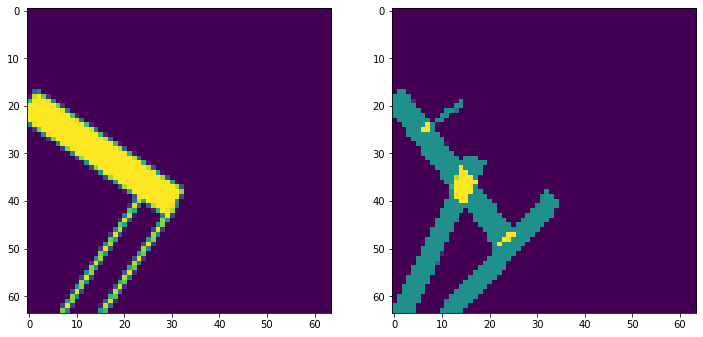

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1970.3029198605877+10965.01228550423j), end=(15.260291337227695-122.58543021792171j)) to Line(start=(48.47978144499487+46.84234539880077j), end=(162.93155273854575+126.98233841999874j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-5113.101271328304-7953.303400679829j), end=(101.24475587276355+76.08535581284397j)) to Line(start=(-6020.825054294664-5421.202971078867j), end=(84.8428244100999+76.36508004630733j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(602.3550713184508-8354.50829835158j), end=(12.89589680877417+75.1506282682151j)) to Line(start=(66.79742347543679-64.8090496816835j), end=(12.567308811307583+92.68

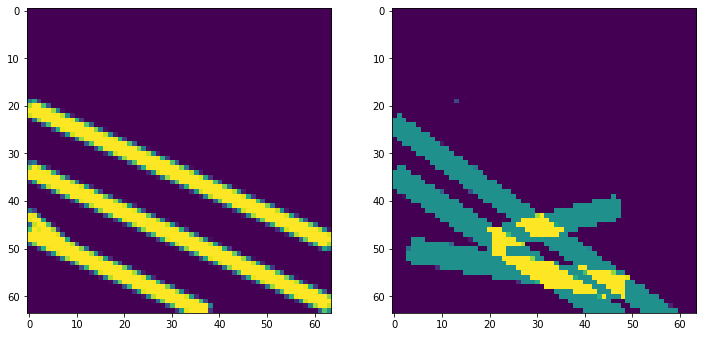

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-3513.4579610207775+7319.969723717521j), end=(108.38387257106746-105.90650128843855j)) to Line(start=(60.91158802712019+11.895367620614364j), end=(30.798997501020956+166.81121614292752j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(6446.044824983646+9223.555550456575j), end=(-83.93520341495487-102.22241116669383j)) to Line(start=(8.448006341898727+29.714485703995212j), end=(-119.91062564577534+119.59216741605066j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-1516.807614705782-10951.375525164844j), end=(54.12272604985682+226.37465742249643j)) to Line(start=(1166.2858791599074-9027.250824756016j), end=(42.71223090352017+

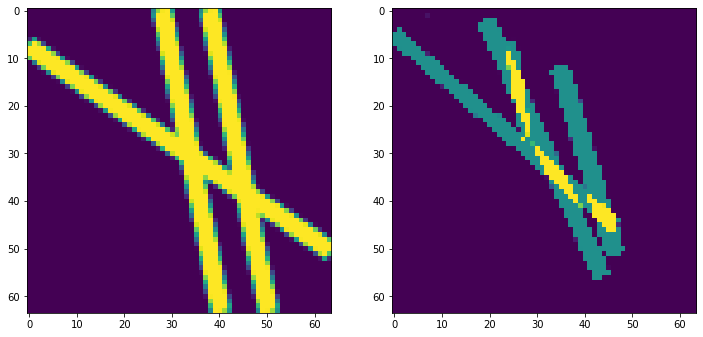

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-2690.5200692702183-10960.961473451945j), end=(72.38165336519859+120.43207692752912j)) to Line(start=(72.21563094981948-36.12951805765565j), end=(69.76002975414245+104.5517802231289j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(5609.799438506623-9240.82231419155j), end=(-37.3559034863862+157.62245513353457j)) to Line(start=(48.383091448855744+19.482644810886143j), end=(175.74263502195762+56.00240626282095j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(10099.924720843963+3484.820507333413j), end=(-128.0112658406061-36.9402798411581j)) to Line(start=(28.319066582380742+19.785111230538224j), end=(82.36977659742689+130.605

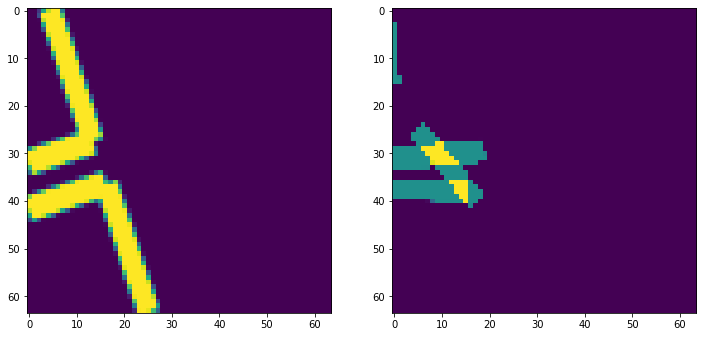

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(8421.244853152724-704.0012846077193j), end=(-115.68241515014859+42.88307271411647j)) to Line(start=(11.88845813805051+38.14736029367431j), end=(113.55742873681118+123.45775602526811j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7598.5611913038+320.433223330794j), end=(152.56274689971713+49.75801098282214j)) to Line(start=(55.23715634056687+53.15669549638643j), end=(49.322280397238494-116.22319015379033j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2668.7685619369604+9218.732064544145j), end=(-6.8999193287924925-112.43284395188797j)) to Line(start=(25.82370930270673+18.248806541847138j), end=(-84.13014363153579+84.315

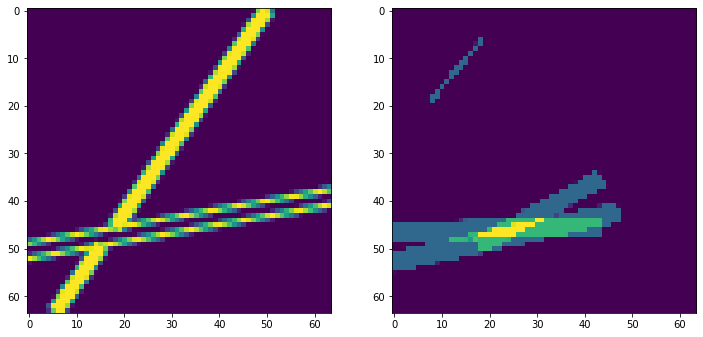

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2573.784182875509+9070.500826249086j), end=(-51.00994796494413-83.24413775273518j)) to Line(start=(61.955816944019666+86.83070610004089j), end=(-25.128312561889736+2.734539772338664j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(7605.32912384929-509.22628235822447j), end=(-87.8197518090561+28.73109232336708j)) to Line(start=(25.601798131517935+14.428352964000059j), end=(102.16792905560011-73.6509051142117j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-10503.868992431146+4300.305459936556j), end=(214.16225453743408-30.06025315944251j)) to Line(start=(-15.527871190050874+28.089251215816375j), end=(100.2724837307436+13.87

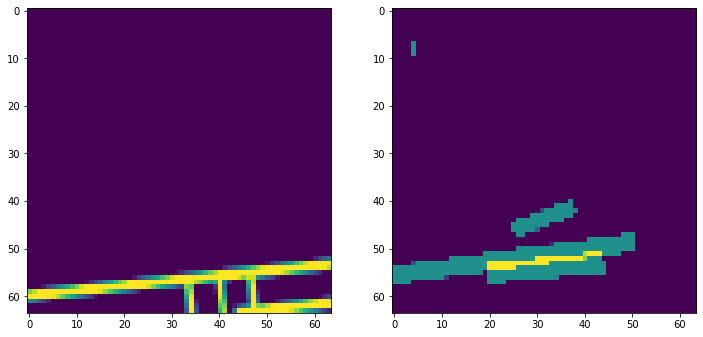

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-1654.3549835902318-10606.649771746628j), end=(57.070326443144154+198.8643717297836j)) to Line(start=(36.67145434381648+44.27291170241519j), end=(144.86085225864903-3.896111695527779j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8845.808161366003+4010.6134185147134j), end=(190.28703623856083-12.515366637542364j)) to Line(start=(56.09463425735525+53.03175816480889j), end=(8.500280611296425+177.01928838932633j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(411.6588135155552-7274.26467718268j), end=(21.788536821078203+164.90336290705406j)) to Line(start=(23.394519198883348+55.573797214480614j), end=(-117.45242475008614-35

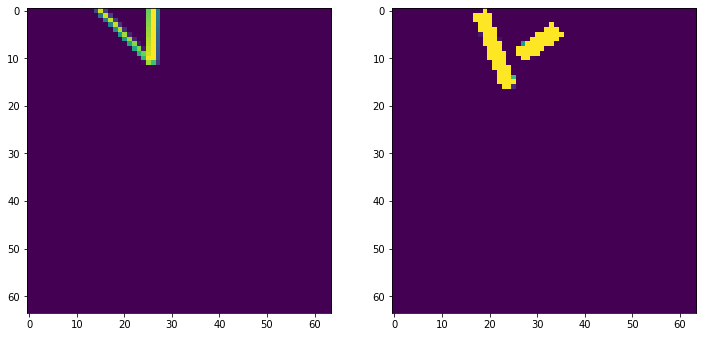

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-7724.0042845629705-2069.9486868452677j), end=(171.34828816626788+45.60465897651367j)) to Line(start=(52.01704471676768+10.220314519908952j), end=(-35.18574416486248-140.8193463847767j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(2119.6608158365157+10862.074643344571j), end=(-16.699793177154547-128.54790731744555j)) to Line(start=(10.966099435248694+31.463612758400753j), end=(-148.46908382345867+109.22534739764266j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(1865.7123745160134+8758.085614678785j), end=(-19.3143369284455-110.26780915398831j)) to Line(start=(9.161839016980355+23.702065601668544j), end=(-112.70710187941

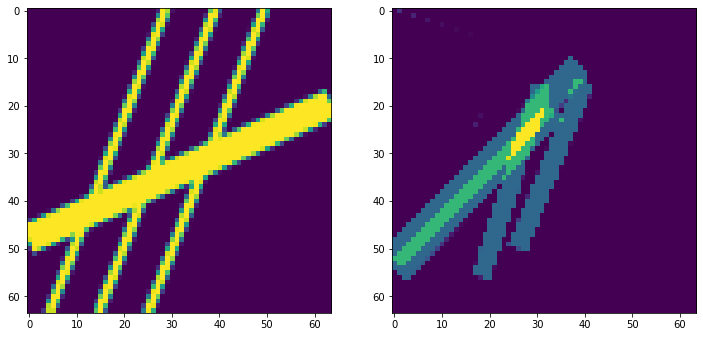

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-8137.820112852511-6795.491181348918j), end=(140.81140196818853+151.10546938973675j)) to Line(start=(12.522029670536742+54.7292741227532j), end=(-127.34607152455936+66.96614736622087j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(-7307.611447485438+8755.282891585142j), end=(93.99997748728777-65.61411511245429j)) to Line(start=(-3501.129319116222+7648.121444427084j), end=(85.20589294493013-42.79923710518702j))
  warn('failed to snap {} to {}'.format(line_svg_first, line_svg_second))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:64: UserWarning: failed to snap Line(start=(7344.203993228217-505.13826959191636j), end=(-75.21015793851902+13.67770848774167j)) to Line(start=(9262.75579334393+1834.1402031136104j), end=(-36.38186359914691+

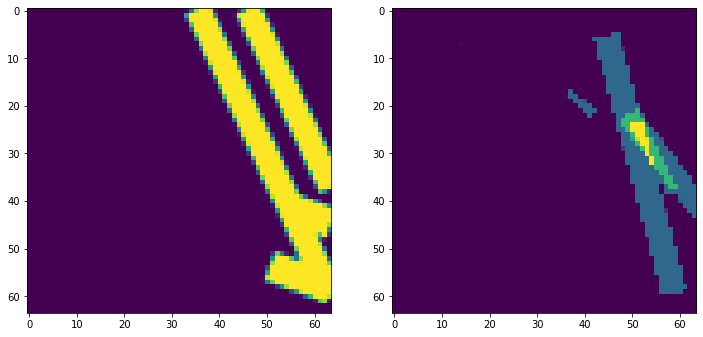

/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-5460.820187833891-5123.509871200864j), end=(81.91110577055119+45.170678492593794j)) to Line(start=(-39.0765605429335-13.157811519372165j), end=(92.33028567875235+56.71244800158775j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(-6133.918832718379+5030.991610955445j), end=(152.87902576253794-59.956914766971195j)) to Line(start=(67.39800214123271+17.569723778179913j), end=(86.64232699751012+139.0736089883991j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
/home/apankov/dev.vectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(4365.232806760228+7536.8155547912775j), end=(-29.49672182289899-75.07927423791288j)) to Line(start=(39.17092706121238+31.858096633529893j), end=(178.2968514655461+31.8580

KeyboardInterrupt: 

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

mse = torch.nn.MSELoss()

for i, batch in enumerate(loader):
    raster = batch['raster']
    raster = 1. - raster / 255.
    vectors, x, render = model.forward(raster.unsqueeze(dim=1))
    if i % 100 == 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(raster[1].detach().cpu().numpy())
        plt.subplot(1, 2, 2)
        plt.imshow(render[1][0].detach().cpu().numpy())
        plt.show()
    optimizer.zero_grad()
    loss = mse(x, raster.unsqueeze(1)) + 10 * mse(vectors, batch['vector'][PrimitiveType.PT_LINE].float())
    loss.backward()
    optimizer.step()